## Import libraries

In [1]:
!python -V

Python 3.6.10


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
#import keras
from sklearn import preprocessing

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

Numpy version: 1.18.1
Pandas version: 1.0.3


In [3]:
import sklearn as sk
sk.__version__

'0.22.2.post1'

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## Import dataset

In [5]:
df=pd.read_csv('dengue data-1070801codedSM.csv')
df=df.drop(['date', 'RNA'],  axis=1)
df['age']=df['age']/100
df=df.dropna(how='any')

In [6]:
train_df, test_df = train_test_split(df, test_size=.1, 
                                         stratify=df.Severity, random_state=42)

In [7]:
pd.set_option('display.max_columns', train_df.shape[1])
pd.set_option('max_colwidth', 1000)

In [8]:
train_df.head()

Severity  sex   age  NS1  IgM  IgG
397         0    1  0.45  1.0  0.0  0.0
252         0    0  0.62  1.0  1.0  0.0
420         0    1  0.31  1.0  0.0  0.0
638         0    0  0.89  0.0  0.0  1.0
374         0    0  0.27  0.0  0.0  0.0

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 397 to 501
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Severity  718 non-null    int64  
 1   sex       718 non-null    int64  
 2   age       718 non-null    float64
 3   NS1       718 non-null    float64
 4   IgM       718 non-null    float64
 5   IgG       718 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 39.3 KB


## Data preprocessing piprlines
Prepare the data to a format that can be fit into scikit learn algorithms

**Transform data in a pipeline** 

 
For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

In [10]:
def PreprocessData (raw_df):
    ndarray=raw_df.values
    Label=ndarray[:,0]
    Features=raw_df.drop(['Severity'], axis=1)
    scaleFeatures=Features.values
    
    #minmax_scale=preprocessing.MinMaxScaler(feature_range=(0,1))
    #scaleFeatures=minmax_scale.fit_transform(Features)
    
    return scaleFeatures, Label
    #return Features, Label

In [11]:
train_Features, train_Label=PreprocessData(train_df)
test_Features, test_Label=PreprocessData(test_df)

In [12]:
np.random.seed(10)

In [13]:
train_Features

array([[1.  , 0.45, 1.  , 0.  , 0.  ],
       [0.  , 0.62, 1.  , 1.  , 0.  ],
       [1.  , 0.31, 1.  , 0.  , 0.  ],
       ...,
       [0.  , 0.39, 1.  , 0.  , 0.  ],
       [0.  , 0.56, 1.  , 0.  , 0.  ],
       [0.  , 0.53, 1.  , 0.  , 0.  ]])

## Fitting classifiers

In [14]:
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, balanced_accuracy_score
import numpy as np
import scipy.stats as stats

In [15]:
train_df['Severity'].value_counts()

0    594
1    124
Name: Severity, dtype: int64

This is an unbalanced dataset(i.e., the number of positive and negative cases are not the same), and we'll use recall as our metric to optimise the model performance.

**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [16]:
def plot_learning_curves(model, X, y):

    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Average_precision")
    plt.title('{} learning curve'.format(model.__class__.__name__))

In [17]:
from sklearn.metrics import precision_recall_curve, make_scorer, auc, average_precision_score

def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score[:, 1])
    return auc(recall, precision, reorder=True)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,needs_proba=True)

In [18]:
sk.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### Logistic Regression
Our first model is logistic regression

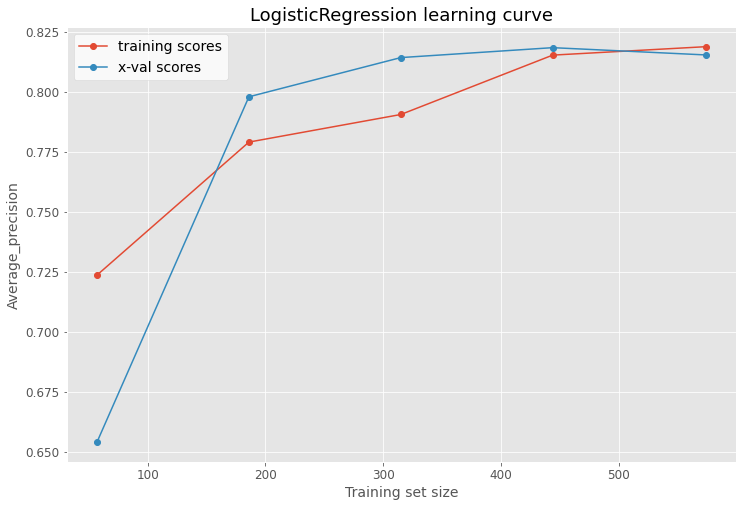

In [19]:
lr_clf = LogisticRegression(n_jobs = -1, 
                           class_weight='balanced'
                           )
plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

Let's see if we can squeeze some more performance out by optimising C.

In [20]:
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
   'class_weight': ['balanced', None]
    }
lr_clf = LogisticRegression(random_state=42)
#scorings ={'precision', 'recall', 'roc_auc'}
#scoring = {make_scorer(auc)}
#make_scorer(accuracy_score)
grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [21]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                   Params
0       0.818964      0.821653          {'C': 10, 'class_weight': None}
1       0.818350      0.822159         {'C': 100, 'class_weight': None}
2       0.818350      0.822185        {'C': 1000, 'class_weight': None}
3       0.817306      0.820682  {'C': 1000, 'class_weight': 'balanced'}
4       0.817239      0.820665   {'C': 100, 'class_weight': 'balanced'}
5       0.816789      0.818569           {'C': 1, 'class_weight': None}
6       0.816711      0.820567    {'C': 10, 'class_weight': 'balanced'}
7       0.815395      0.818801     {'C': 1, 'class_weight': 'balanced'}
8       0.800860      0.806208   {'C': 0.1, 'class_weight': 'balanced'}
9       0.795823      0.800048         {'C': 0.1, 'class_weight': None}
10      0.781377      0.789455  {'C': 0.01, 'class_weight': 'balanced'}
11      0.775889      0.785464        {'C': 0.01, 'class_weight': None}

Looks like C=1000 is our best value.

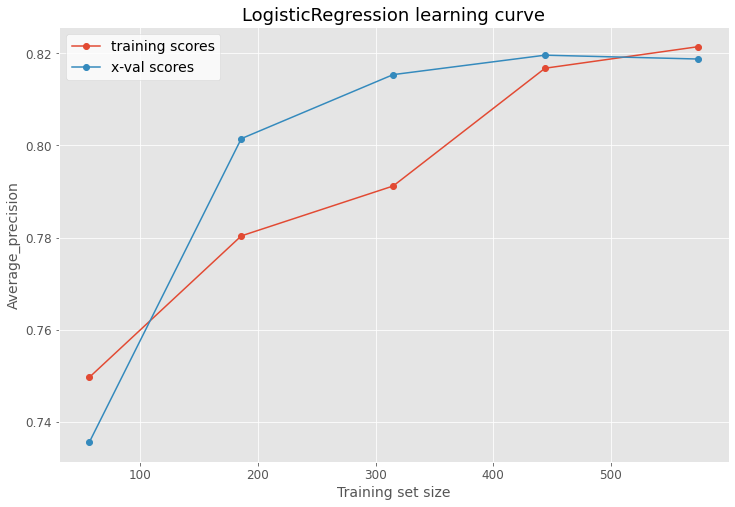

In [22]:
lr_clf = grid_search.best_estimator_

plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

In [23]:
with open('20200225lr_clf_final_round.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

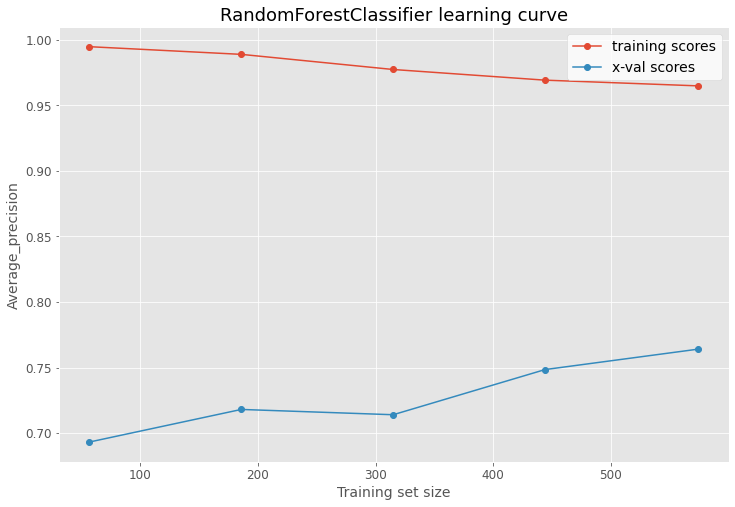

In [24]:
rf_clf = RandomForestClassifier(random_state=42, 
                              class_weight='balanced'
                               )
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

This is a typical overfitting curve. The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [25]:
param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
        'class_weight': ['balanced', None]
    }
#rf_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [26]:
cv_rlt = rnd_search.cv_results_
rf_clf = rnd_search.best_estimator_

pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.818617      0.870089   
1       0.816172      0.886700   
2       0.815024      0.848527   
3       0.814575      0.859386   
4       0.813677      0.832286   
..           ...           ...   
95      0.739168      0.764660   
96      0.738926      0.757674   
97      0.738143      0.761213   
98      0.732721      0.749899   
99      0.727428      0.754075   

                                                                                                                                        Params  
0    {'class_weight': 'balanced', 'max_depth': 34, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 42, 'n_estimators': 28}  
1    {'class_weight': 'balanced', 'max_depth': 95, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 17, 'n_estimators': 26}  
2   {'class_weight': 'balanced', 'max_depth': 31, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 64, 'n_estimators': 19}  
3          {'class_weight': None, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 57, 'n_estimators': 17}  
4    {'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 36, 'min_samples_split': 79, 'n_estimators': 17}  
..                                                                                                                                         ...  
95        {'class_weight': None, 'max_depth': 76, 'max_features': 'log2', 'min_samples_leaf': 93, 'min_samples_split': 90, 'n_estimators': 39}  
96         {'class_weight': None, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 94, 'min_samples_split': 64, 'n_estimators': 18}  
97        {'class_weight': None, 'max_depth': 22, 'max_features': 'log2', 'min_samples_leaf': 98, 'min_samples_split': 29, 'n_estimators': 47}  
98         {'class_weight': None, 'max_depth': 88, 'max_features': 'auto', 'min_samples_leaf': 93, 'min_samples_split': 99, 'n_estimators': 2}  
99          {'class_weight': None, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 97, 'min_samples_split': 2, 'n_estimators': 5}  

[100 rows x 3 columns]

As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

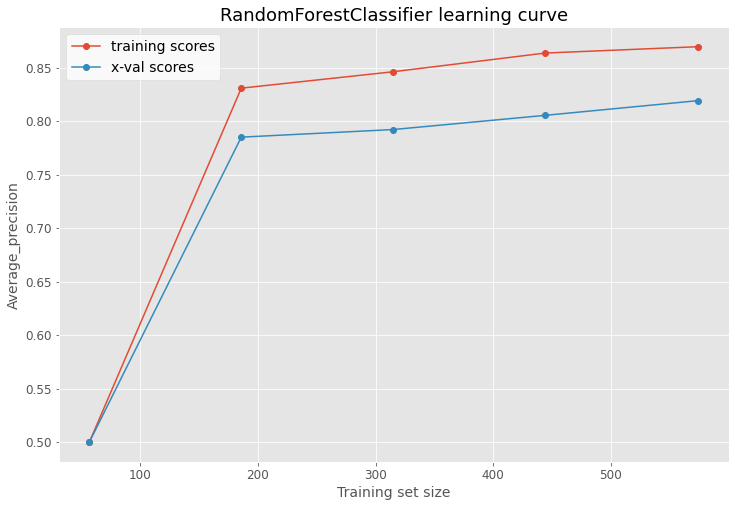

In [27]:
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

In [28]:
#rf_clf = rnd_search.best_estimator_
rf_clf.fit(train_Features, train_df['Severity'], )
with open('20200225rf_clf_final_round.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

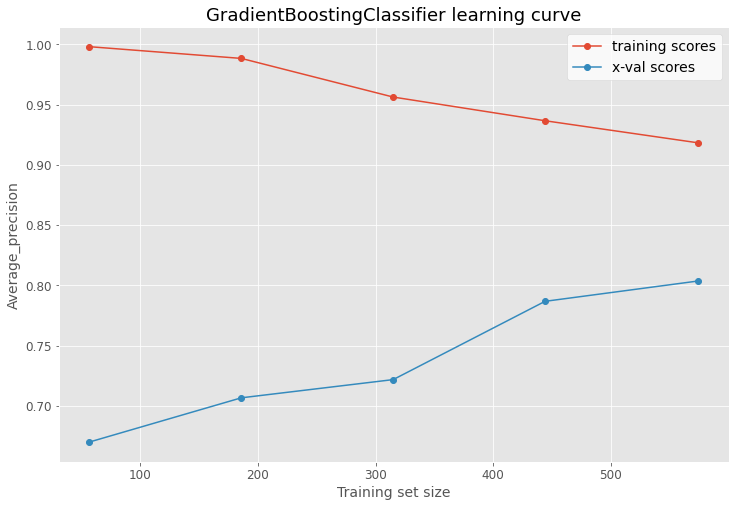

In [29]:
plot_learning_curves(GradientBoostingClassifier(random_state=42), train_Features, train_df['Severity'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [30]:
param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
# this will take a long time
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [31]:
cv_rlt = rnd_search.cv_results_
gbm_clf = rnd_search.best_estimator_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.814079      0.860575   
1       0.812466      0.854072   
2       0.812158      0.865003   
3       0.811658      0.859051   
4       0.811256      0.890228   
..           ...           ...   
95      0.767978      0.967342   
96      0.766117      0.965672   
97      0.763343      0.969680   
98      0.762962      0.971254   
99      0.750064      0.971512   

                                                                                     Params  
0   {'max_depth': 27, 'min_samples_leaf': 96, 'min_samples_split': 55, 'n_estimators': 137}  
1    {'max_depth': 11, 'min_samples_leaf': 91, 'min_samples_split': 54, 'n_estimators': 81}  
2   {'max_depth': 32, 'min_samples_leaf': 98, 'min_samples_split': 29, 'n_estimators': 190}  
3   {'max_depth': 18, 'min_samples_leaf': 98, 'min_samples_split': 74, 'n_estimators': 138}  
4   {'max_depth': 27, 'min_samples_leaf': 51, 'min_samples_split': 24, 'n_estimators': 110}  
..                                                                                      ...  
95   {'max_depth': 21, 'min_samples_leaf': 5, 'min_samples_split': 36, 'n_estimators': 143}  
96   {'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 54, 'n_estimators': 123}  
97     {'max_depth': 42, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 85}  
98   {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 28, 'n_estimators': 141}  
99   {'max_depth': 42, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 171}  

[100 rows x 3 columns]

We'll save the best model, retrain it on the whole dataset and save the model

In [32]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(train_Features, train_df['Severity'])
with open('20200225gbm_clf_final_round.pkl', 'wb') as f:
    pickle.dump(gbm_clf, f)

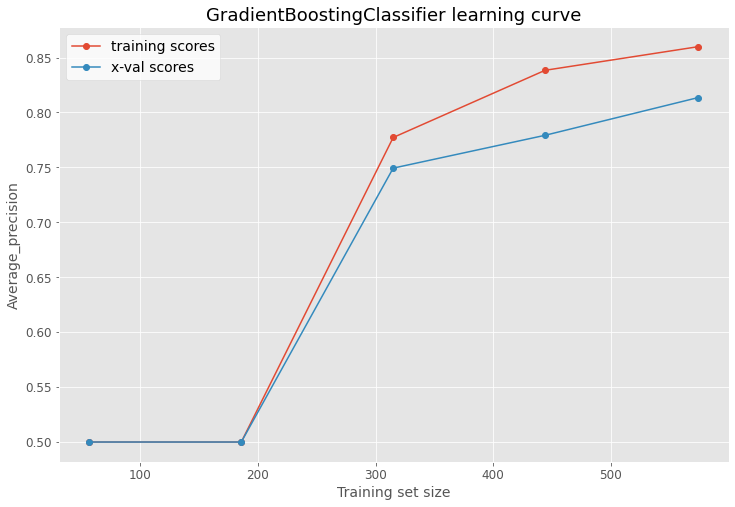

In [33]:
plot_learning_curves(gbm_clf, train_Features, train_df['Severity'])

The learning curve of the best Gradient Boosting model suggests that the performance of the model might continue to increase with more traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

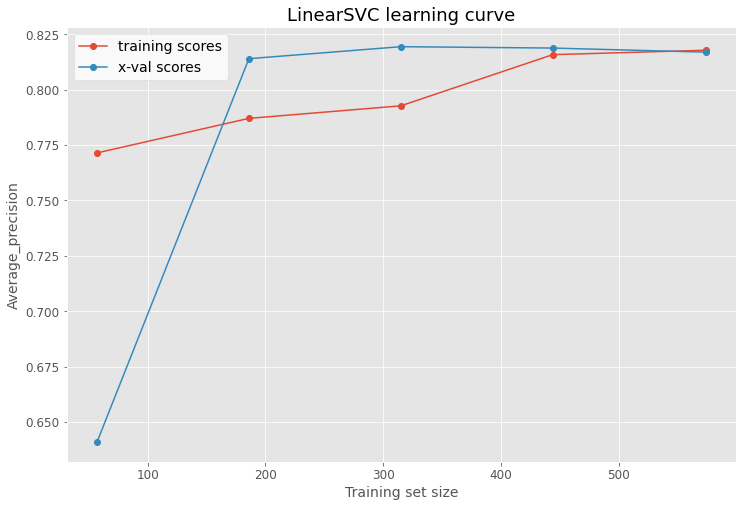

In [34]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=42, class_weight= 'balanced'), train_Features, train_df['Severity'] )

Try Polynomial kernel

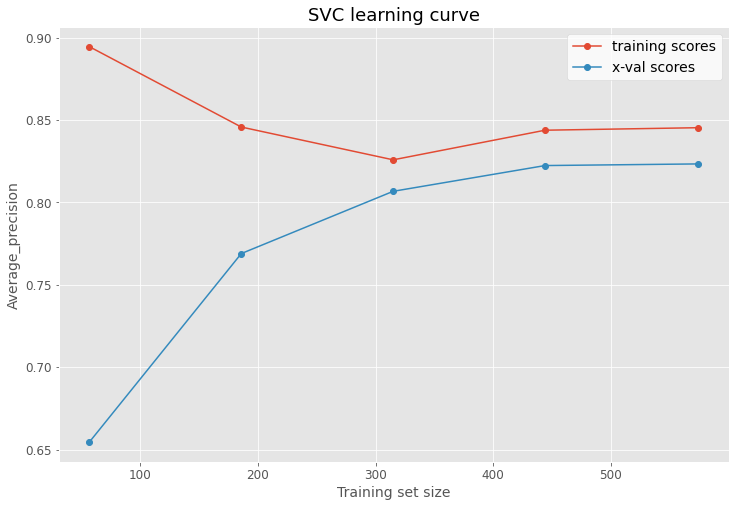

In [35]:
plot_learning_curves(SVC(kernel='poly', random_state=42,class_weight= 'balanced'), train_Features, train_df['Severity'])

Try Gaussian RBF kernel

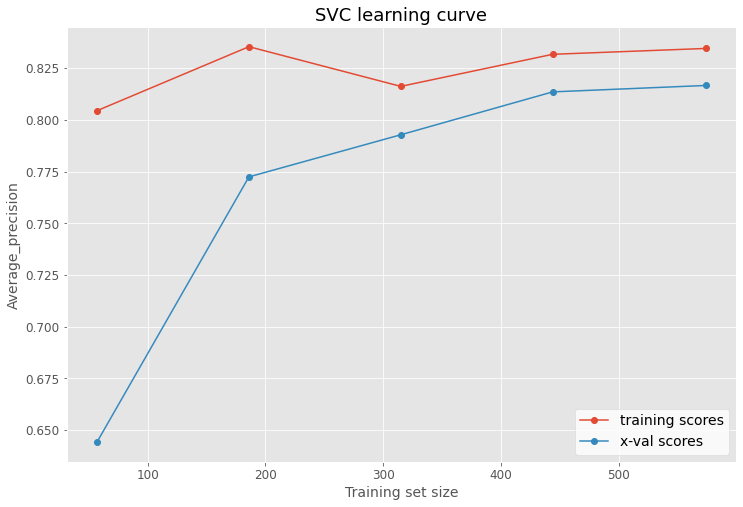

In [36]:
plot_learning_curves(SVC(random_state=42, class_weight= 'balanced'), train_Features, train_df['Severity'])

The learning curve of the Linear SVC shows sign of underfitting, and provide evidence that the data set is not linearly seperatable.  

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [37]:
rbf_gamma = [1/len(train_df.columns) * x for x in range(1, 15, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 3, 9],  'class_weight': ['balanced']},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 3, 9],  'class_weight': ['balanced']},
    
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 3, 9], 'class_weight': ['balanced'],
                          'degree': [3, 9, 15], 'kernel': ['poly']},
                         {'C': [1, 3, 9], 'class_weight': ['balanced'],
                          'gamma': [0.16666666666666666, 1.0,
                                    1.8333333333333333]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [38]:
cv_rlt = grid_search.cv_results_
svc_clf = grid_search.best_estimator_

In [39]:
cv_rlt

{'mean_fit_time': array([4.57948685e-02, 1.86731906e+00, 1.42097438e+02, 5.64760685e-02,
        3.25166736e+00, 2.21281494e+02, 8.47504616e-02, 7.04724731e+00,
        3.66719014e+02, 8.87999058e-02, 7.88033009e-02, 7.76076317e-02,
        8.03827286e-02, 7.48861313e-02, 7.68990040e-02, 7.90499687e-02,
        7.66808510e-02, 7.53142357e-02]),
 'std_fit_time': array([7.23218116e-03, 4.65208167e-01, 1.63451374e+01, 7.98563111e-03,
        5.35298856e-01, 5.94791200e+01, 8.37279810e-03, 2.40813989e+00,
        9.11137060e+01, 2.22996524e-03, 3.96777039e-03, 3.87249610e-03,
        2.69932076e-03, 1.43991048e-03, 3.76373132e-03, 3.15596044e-03,
        6.58288716e-03, 3.17575799e-03]),
 'mean_score_time': array([0.00280995, 0.00252051, 0.00301089, 0.00286789, 0.00280604,
        0.00287366, 0.00341392, 0.00268178, 0.00312519, 0.00529337,
        0.00496058, 0.00494823, 0.00493884, 0.00482969, 0.00476074,
        0.00518832, 0.00609837, 0.00457139]),
 'std_score_time': array([0.00054599, 

pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

SVM training is very computationaly expensive, making it not scalable to big data sets. As it turns out the default RBF SVM results the best cross-validation score.

In [40]:
svc_clf.fit(train_Features, train_df['Severity'])
with open('20200225svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

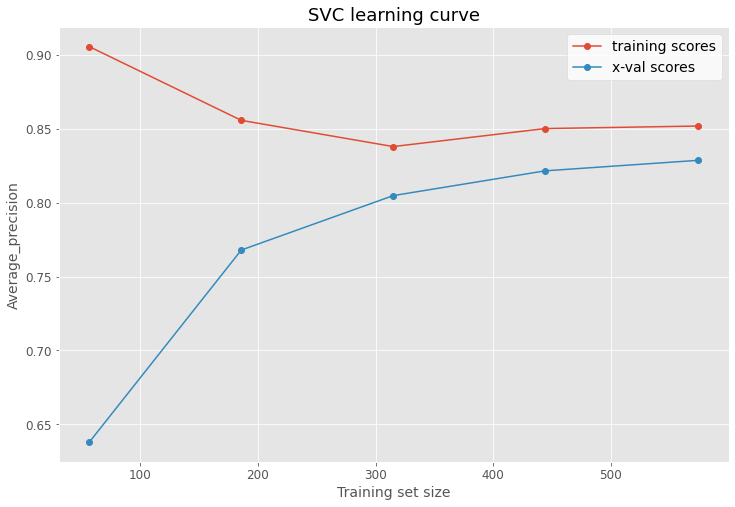

In [41]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, train_Features, train_df['Severity']) 

## Compute and compare test metrics

**Compute test accuracy score**

In [42]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

### _Logistic Regression model_

In [43]:
# Import model and retrain
with open('20200225lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(train_Features, train_df['Severity'])

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy scores

In [44]:
accu_lr = accuracy_score(test_df['Severity'], lr_clf.predict(test_Features))

In [45]:
accu_lr

0.85

In [46]:
pd.crosstab(test_df['Severity'], lr_clf.predict(test_Features))

col_0      0  1
Severity       
0         66  0
1         12  2

ROC and AUC

In [47]:
pred_proba_lr = lr_clf.predict_proba(test_Features)

In [48]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(test_df['Severity'], pred_proba_lr[:, 1])

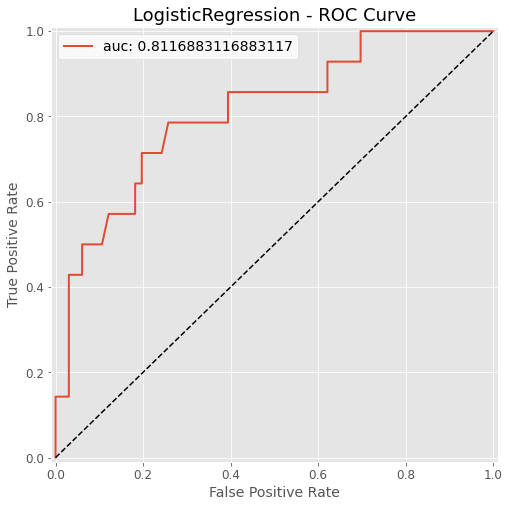

In [49]:
plot_roc_curve(fpr, tpr, auc_lr, lr_clf)

In [50]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

In [51]:
def plot_precision_recall_curve(fpr, tpr, ap, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(recall, precision, linewidth=2, label='average_precision: {}'.format(ap))
    plt.plot([0, 1], [0.1, 0.1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - PR Curve'.format(title))

f1=0.250 auc_lr=0.551 ap_lr=0.565


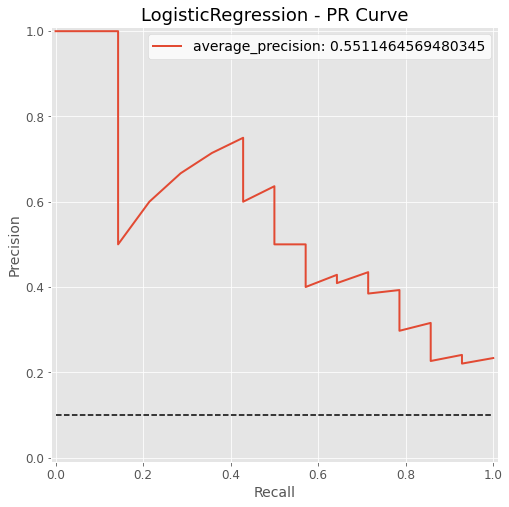

In [52]:
# predict probabilities
pred_proba_lr = lr_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_lr = pred_proba_lr[:, 1]
# predict class values
yhat = lr_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_lr)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_lr_pr=auc(recall, precision)
# calculate average precision score
ap_lr_pr = average_precision_score(test_Label, pred_proba_lr)
print('f1=%.3f auc_lr=%.3f ap_lr=%.3f' % (f1, auc_lr_pr, ap_lr_pr))

plot_precision_recall_curve(recall, precision, auc_lr_pr, lr_clf)

### _Random forests model_

In [53]:
# Import model and retrain
with open('20200225rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_df['Severity'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=34, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=42,
                       min_weight_fraction_leaf=0.0, n_estimators=28,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy scores

In [54]:
accu_rf = accuracy_score(test_df['Severity'], rf_clf.predict(test_Features))

In [55]:
accu_rf

0.75

In [56]:
pd.crosstab(test_df['Severity'], rf_clf.predict(test_Features))

col_0      0   1
Severity        
0         49  17
1          3  11

ROC and AUC

In [57]:
pred_proba_rf = rf_clf.predict_proba(test_Features)

In [58]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(test_df['Severity'], pred_proba_rf[:, 1])

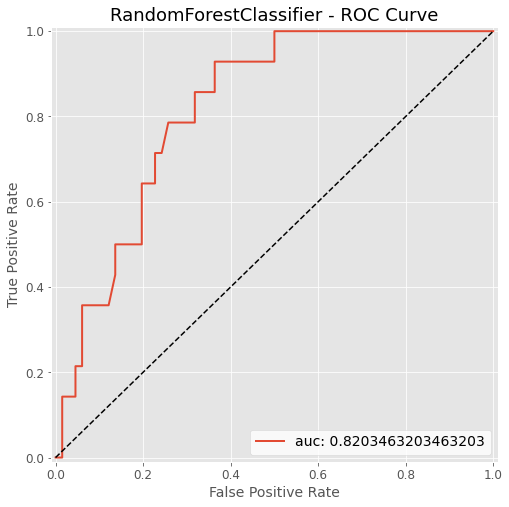

In [59]:
plot_roc_curve(fpr, tpr, auc_rf, rf_clf)

f1=0.524 auc_rf=0.820 ap_rf=0.452


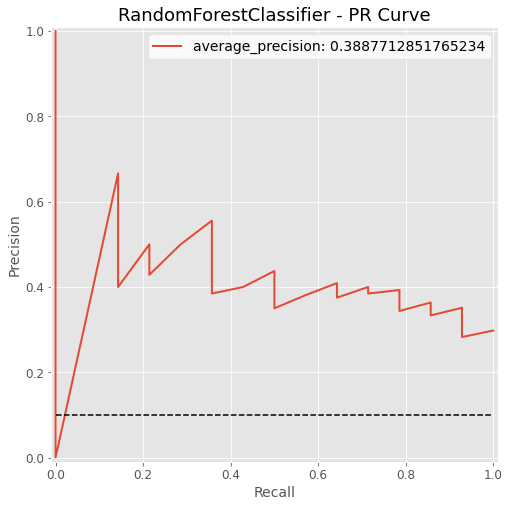

In [60]:
# predict probabilities
pred_proba_rf = rf_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_rf = pred_proba_rf[:, 1]
# predict class values
yhat = rf_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_rf)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_rf_pr=auc(recall, precision)
# calculate average precision score
ap_rf_pr = average_precision_score(test_Label, pred_proba_rf)
print('f1=%.3f auc_rf=%.3f ap_rf=%.3f' % (f1, auc_rf, ap_rf_pr))

plot_precision_recall_curve(recall, precision, auc_rf_pr, rf_clf)

### _Gradient boosting machine model_

In [61]:
# Import model and retrain
with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(train_Features, train_df['Severity'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=27,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=96, min_samples_split=55,
                           min_weight_fraction_leaf=0.0, n_estimators=137,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy scores

In [62]:
accu_gbm = accuracy_score(test_df['Severity'], gbm_clf.predict(test_Features))

In [63]:
accu_gbm

0.7875

In [64]:
pd.crosstab(test_df['Severity'], gbm_clf.predict(test_Features))

col_0      0  1
Severity       
0         60  6
1         11  3

ROC and AUC

In [65]:
pred_proba_gbm = gbm_clf.predict_proba(test_Features)

In [66]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(test_df['Severity'], pred_proba_gbm[:, 1])

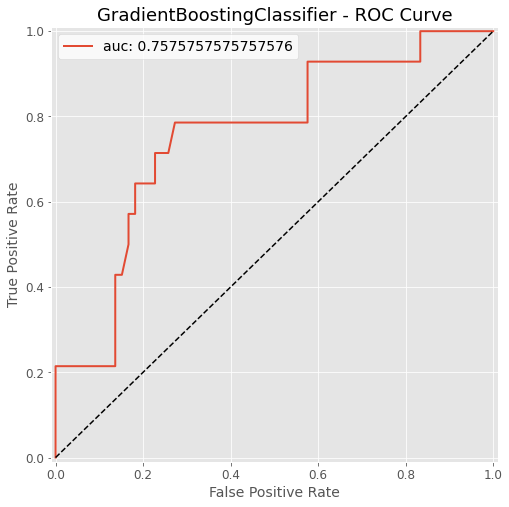

In [67]:
plot_roc_curve(fpr, tpr, auc_gbm, gbm_clf)

f1=0.261 auc_gbm=0.473 ap_gbm=0.494


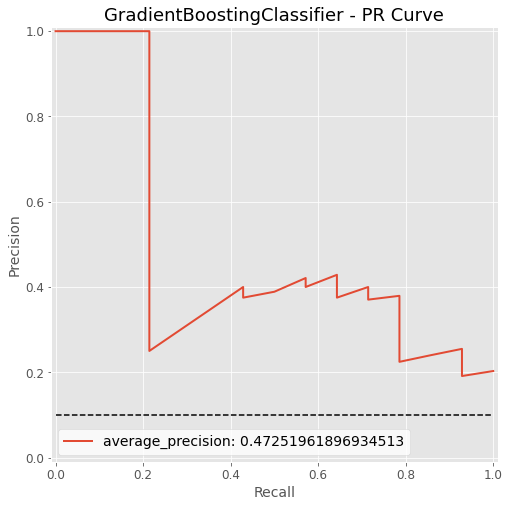

In [68]:
# predict probabilities
pred_proba_gbm = gbm_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_gbm = pred_proba_gbm[:, 1]
# predict class values
yhat = gbm_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_gbm)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_gbm_pr=auc(recall, precision)
# calculate average precision score
ap_gbm_pr = average_precision_score(test_Label, pred_proba_gbm)
print('f1=%.3f auc_gbm=%.3f ap_gbm=%.3f' % (f1, auc_gbm_pr, ap_gbm_pr))

plot_precision_recall_curve(recall, precision, auc_gbm_pr, gbm_clf)

### _Support vector machine model_

In [69]:
# Import model and retrain
with open('20200225svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(train_Features, train_df['Severity'])

SVC(C=3, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Accuracy scores

In [70]:
accu_svc = accuracy_score(test_df['Severity'], svc_clf.predict(test_Features))

In [71]:
accu_svc

0.7125

In [72]:
pd.crosstab(test_df['Severity'], svc_clf.predict(test_Features))

col_0      0   1
Severity        
0         46  20
1          3  11

ROC and AUC

In [73]:
pred_proba_svc = svc_clf.predict_proba(test_Features)

In [74]:
fpr, tpr, _ = roc_curve(test_df['Severity'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(test_df['Severity'], pred_proba_svc[:, 1])

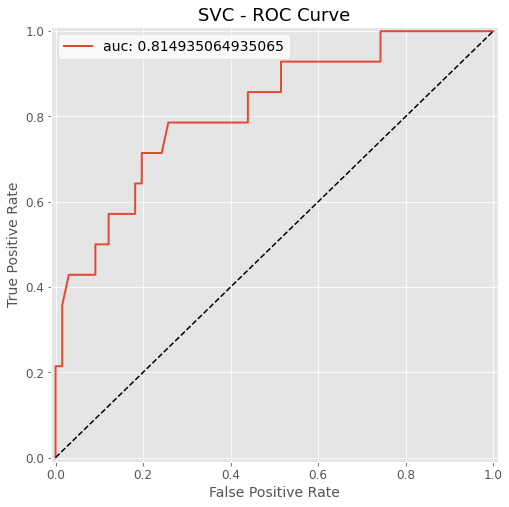

In [75]:
plot_roc_curve(fpr, tpr, auc_svc, svc_clf)

f1=0.489 auc_svc=0.599 ap_svc=0.605


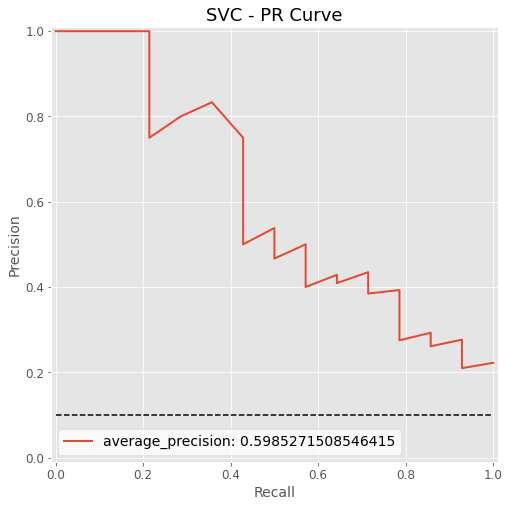

In [76]:
# predict probabilities
pred_proba_svc = svc_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_svc = pred_proba_svc[:, 1]
# predict class values
yhat = svc_clf.predict(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_svc)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_svc_pr=auc(recall, precision)
# calculate average precision score
ap_svc_pr = average_precision_score(test_Label, pred_proba_svc)
print('f1=%.3f auc_svc=%.3f ap_svc=%.3f' % (f1, auc_svc_pr, ap_svc_pr))

plot_precision_recall_curve(recall, precision, auc_svc_pr, svc_clf)

### Deep Learning

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

In [15]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Set CPU as available physical device
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

# To find out which devices your operations and tensors are assigned to
tf.debugging.set_log_device_placement(True)

In [16]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

In [19]:
import kerastuner
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
import numpy as np
from sklearn import model_selection

In [20]:
INPUT_SHAPE = (train_Features.shape[-1],) 

In [21]:
class HyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Dense(units=hp.Int('units1',
                                        min_value=50,
                                        max_value=300,
                                        step=50),
                           input_shape=INPUT_SHAPE,
                           activation='relu'))
    
        #model.add(layers.Dropout(rates=hp.Float(
        #        'dropout_1',
        #        min_value=0.1,
        #        max_value=0.5,
        #        #default=0.1,
        #        step=0.2,)))

        model.add(layers.Dense(units=hp.Int('units2',
                                        min_value=50,
                                        max_value=300,
                                        step=50),
                           activation='relu'))
    
        #model.add(layers.Dropout(rates=hp.Float(
        #        'dropout_2',
        #        min_value=0.1,
        #        max_value=0.5,
        #        #default=0.1,
        #        step=0.2,)))
                  
        model.add(layers.Dense(units=hp.Int('units3',
                                        min_value=50,
                                        max_value=300,
                                        step=50),
                           activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(
            optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name='ROCAUC')])
        
        return model

In [22]:
hypermodel = HyperModel(input_shape=INPUT_SHAPE)

In [23]:
SEED=1
HYPERBAND_MAX_EPOCHS = 300
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

In [28]:
tuner = RandomSearch(
    hypermodel,
    objective=kerastuner.Objective("val_ROCAUC", direction="max"),
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='DVpatient2'
)

In [29]:
tuner.search_space_summary()

In [31]:
N_EPOCH_SEARCH = 300

tuner.search(train_Features, train_Label, epochs=N_EPOCH_SEARCH, validation_split=0.1)

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7000 - ROCAUC: 0.477 - ETA: 0s - loss: 0.5215 - ROCAUC: 0.517 - ETA: 0s - loss: 0.4490 - ROCAUC: 0.63 - 1s 1ms/sample - loss: 0.4460 - ROCAUC: 0.6325 - val_loss: 0.4928 - val_ROCAUC: 0.8281
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.4408 - ROCAUC: 0.67 - ETA: 0s - loss: 0.4745 - ROCAUC: 0.66 - ETA: 0s - loss: 0.4440 - ROCAUC: 0.67 - 0s 262us/sample - loss: 0.4338 - ROCAUC: 0.6847 - val_loss: 0.4155 - val_ROCAUC: 0.7924
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.3698 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3991 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3955 - ROCAUC: 0.76 - 0s 317us/sample - loss: 0.3906 - ROCAUC: 0.7760 - val_loss: 0.4047 - val_ROCAUC: 0.8649
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.5107 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3715 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3798 - ROCAU

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.3583 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3406 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3465 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3494 - ROCAUC: 0.8270 - val_loss: 0.3929 - val_ROCAUC: 0.8275
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.2953 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3491 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3529 - ROCAUC: 0.83 - 0s 266us/sample - loss: 0.3457 - ROCAUC: 0.8304 - val_loss: 0.4194 - val_ROCAUC: 0.8199
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.1738 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3243 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3504 - ROCAUC: 0.83 - 0s 276us/sample - loss: 0.3459 - ROCAUC: 0.8306 - val_loss: 0.4216 - val_ROCAUC: 0.8404
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.4926 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3374 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3411 - ROCAUC: 0.83 - 0s 273us/sample - loss: 0.3453 -

Epoch 63/300
646/646 [==============================] - ETA: 0s - loss: 0.3085 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3450 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3152 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.3282 - ROCAUC: 0.8509 - val_loss: 0.3807 - val_ROCAUC: 0.8544
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.3694 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3575 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3412 - ROCAUC: 0.83 - 0s 265us/sample - loss: 0.3429 - ROCAUC: 0.8385 - val_loss: 0.3850 - val_ROCAUC: 0.8497
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3088 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3315 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3391 - ROCAUC: 0.83 - 0s 260us/sample - loss: 0.3435 - ROCAUC: 0.8317 - val_loss: 0.3998 - val_ROCAUC: 0.8520
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.3065 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3351 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3328 -

Epoch 94/300
646/646 [==============================] - ETA: 0s - loss: 0.3280 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3047 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.85 - 0s 279us/sample - loss: 0.3179 - ROCAUC: 0.8549 - val_loss: 0.4118 - val_ROCAUC: 0.8491
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.4242 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3133 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3118 - ROCAUC: 0.86 - 0s 276us/sample - loss: 0.3152 - ROCAUC: 0.8658 - val_loss: 0.3868 - val_ROCAUC: 0.8526
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2869 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2972 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3179 - ROCAUC: 0.86 - 0s 268us/sample - loss: 0.3147 - ROCAUC: 0.8663 - val_loss: 0.3735 - val_ROCAUC: 0.8550
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.2312 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.87 - 0s 279us/sample - loss: 0.3191 -

Epoch 125/300
646/646 [==============================] - ETA: 0s - loss: 0.3434 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2801 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2973 - ROCAUC: 0.86 - 0s 292us/sample - loss: 0.3202 - ROCAUC: 0.8587 - val_loss: 0.3822 - val_ROCAUC: 0.8398
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.3927 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3194 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3179 - ROCAUC: 0.85 - 0s 280us/sample - loss: 0.3148 - ROCAUC: 0.8648 - val_loss: 0.4207 - val_ROCAUC: 0.8480
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2854 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2889 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3138 - ROCAUC: 0.86 - 0s 274us/sample - loss: 0.3270 - ROCAUC: 0.8543 - val_loss: 0.3789 - val_ROCAUC: 0.8637
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3262 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3351 - ROCAUC: 0.85 - 0s 268us/sample - loss: 0.32

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.4694 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3476 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3372 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3286 - ROCAUC: 0.8495 - val_loss: 0.3959 - val_ROCAUC: 0.8345
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.3534 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3211 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3116 - ROCAUC: 0.87 - 0s 263us/sample - loss: 0.3087 - ROCAUC: 0.8709 - val_loss: 0.4065 - val_ROCAUC: 0.8509
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2029 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3110 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3019 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.3028 - ROCAUC: 0.8758 - val_loss: 0.4133 - val_ROCAUC: 0.8450
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.1085 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2946 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.31

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.3305 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3241 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3228 - ROCAUC: 0.85 - 0s 265us/sample - loss: 0.3164 - ROCAUC: 0.8646 - val_loss: 0.4231 - val_ROCAUC: 0.8357
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.4796 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3071 - ROCAUC: 0.8768 - val_loss: 0.4045 - val_ROCAUC: 0.8491
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2511 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3169 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2991 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3056 - ROCAUC: 0.8748 - val_loss: 0.3830 - val_ROCAUC: 0.8444
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3188 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2970 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3072 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.30

Epoch 218/300
646/646 [==============================] - ETA: 0s - loss: 0.3142 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3171 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2947 - ROCAUC: 0.88 - 0s 280us/sample - loss: 0.3034 - ROCAUC: 0.8734 - val_loss: 0.4130 - val_ROCAUC: 0.8374
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.1870 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3111 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3130 - ROCAUC: 0.8680 - val_loss: 0.4246 - val_ROCAUC: 0.8433
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.4986 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3807 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3518 - ROCAUC: 0.83 - 0s 248us/sample - loss: 0.3504 - ROCAUC: 0.8322 - val_loss: 0.4074 - val_ROCAUC: 0.8146
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3627 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3441 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.4093 - ROCAUC: 0.80 - ETA: 0s - loss: 0.2927 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.87 - 0s 276us/sample - loss: 0.3004 - ROCAUC: 0.8783 - val_loss: 0.4303 - val_ROCAUC: 0.8368
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.2647 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.87 - 0s 269us/sample - loss: 0.3016 - ROCAUC: 0.8770 - val_loss: 0.3953 - val_ROCAUC: 0.8544
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.3209 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3118 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2886 - ROCAUC: 0.89 - 0s 271us/sample - loss: 0.2955 - ROCAUC: 0.8838 - val_loss: 0.4270 - val_ROCAUC: 0.8409
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.3932 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3154 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3102 - ROCAUC: 0.87 - 0s 266us/sample - loss: 0.3051 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2378 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2907 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3051 - ROCAUC: 0.87 - 0s 242us/sample - loss: 0.3000 - ROCAUC: 0.8820 - val_loss: 0.3798 - val_ROCAUC: 0.8544
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2798 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2780 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2988 - ROCAUC: 0.88 - 0s 240us/sample - loss: 0.2999 - ROCAUC: 0.8793 - val_loss: 0.4004 - val_ROCAUC: 0.8596
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.3056 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2706 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3063 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3044 - ROCAUC: 0.8758 - val_loss: 0.3974 - val_ROCAUC: 0.8433
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.2350 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3219 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3077 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3011 - ROCAUC: 0

Epoch 11/300
646/646 [==============================] - ETA: 0s - loss: 0.4621 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3971 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3842 - ROCAUC: 0.77 - 0s 277us/sample - loss: 0.3833 - ROCAUC: 0.7795 - val_loss: 0.3984 - val_ROCAUC: 0.8310
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.3108 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3720 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3735 - ROCAUC: 0.81 - 0s 280us/sample - loss: 0.3607 - ROCAUC: 0.8188 - val_loss: 0.4151 - val_ROCAUC: 0.8357
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.3003 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3675 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3641 - ROCAUC: 0.83 - 0s 276us/sample - loss: 0.3628 - ROCAUC: 0.8136 - val_loss: 0.4383 - val_ROCAUC: 0.8480
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.2997 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3640 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3620 - ROCAUC: 0.82 - 0s 281us/sample - loss: 0.3609 -

Epoch 42/300
646/646 [==============================] - ETA: 0s - loss: 0.4308 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3404 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3409 - ROCAUC: 0.84 - 0s 273us/sample - loss: 0.3450 - ROCAUC: 0.8365 - val_loss: 0.4556 - val_ROCAUC: 0.8240
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.4641 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3460 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3376 - ROCAUC: 0.84 - 0s 271us/sample - loss: 0.3432 - ROCAUC: 0.8359 - val_loss: 0.3911 - val_ROCAUC: 0.8275
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.3927 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3385 - ROCAUC: 0.83 - 0s 265us/sample - loss: 0.3411 - ROCAUC: 0.8380 - val_loss: 0.3678 - val_ROCAUC: 0.8480
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.4850 - ROCAUC: 0.52 - ETA: 0s - loss: 0.3698 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3609 - ROCAUC: 0.82 - 0s 263us/sample - loss: 0.3443 -

Epoch 73/300
646/646 [==============================] - ETA: 0s - loss: 0.3785 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3358 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3378 - ROCAUC: 0.8442 - val_loss: 0.4048 - val_ROCAUC: 0.8509
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.3551 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3229 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3439 - ROCAUC: 0.85 - 0s 270us/sample - loss: 0.3268 - ROCAUC: 0.8531 - val_loss: 0.4100 - val_ROCAUC: 0.8544
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.3275 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3235 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3346 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3283 - ROCAUC: 0.8521 - val_loss: 0.4187 - val_ROCAUC: 0.8561
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2630 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3546 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.86 - 0s 267us/sample - loss: 0.3233 -

646/646 [==============================] - ETA: 0s - loss: 0.3961 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3340 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.86 - 0s 261us/sample - loss: 0.3128 - ROCAUC: 0.8651 - val_loss: 0.4433 - val_ROCAUC: 0.8439
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.1831 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3246 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3229 - ROCAUC: 0.85 - 0s 274us/sample - loss: 0.3159 - ROCAUC: 0.8640 - val_loss: 0.4127 - val_ROCAUC: 0.8532
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.1193 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3162 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3103 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3170 - ROCAUC: 0.8642 - val_loss: 0.4101 - val_ROCAUC: 0.8439
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2881 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3295 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3307 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.2561 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3008 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3153 - ROCAUC: 0.8651 - val_loss: 0.3722 - val_ROCAUC: 0.8550
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.3327 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3278 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3267 - ROCAUC: 0.8573 - val_loss: 0.3920 - val_ROCAUC: 0.8345
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.3191 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3303 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3156 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3257 - ROCAUC: 0.8574 - val_loss: 0.4143 - val_ROCAUC: 0.8444
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.3804 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2933 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.31

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.3870 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3116 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3118 - ROCAUC: 0.8688 - val_loss: 0.3859 - val_ROCAUC: 0.8620
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.2729 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2504 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.86 - 0s 245us/sample - loss: 0.3133 - ROCAUC: 0.8691 - val_loss: 0.3692 - val_ROCAUC: 0.8684
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.3238 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.87 - 0s 236us/sample - loss: 0.3075 - ROCAUC: 0.8739 - val_loss: 0.3856 - val_ROCAUC: 0.8737
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.3887 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3278 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3138 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.31

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.2210 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2604 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3113 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.3102 - ROCAUC: 0.8709 - val_loss: 0.4064 - val_ROCAUC: 0.8637
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.5473 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3476 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3194 - ROCAUC: 0.8607 - val_loss: 0.4132 - val_ROCAUC: 0.8515
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.1703 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2841 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3239 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3216 - ROCAUC: 0.8599 - val_loss: 0.3853 - val_ROCAUC: 0.8743
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2506 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2910 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.86 - 0s 264us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.3518 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3410 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3050 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3090 - ROCAUC: 0.8737 - val_loss: 0.4155 - val_ROCAUC: 0.8509
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.6534 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3070 - ROCAUC: 0.86 - 0s 265us/sample - loss: 0.3097 - ROCAUC: 0.8690 - val_loss: 0.3951 - val_ROCAUC: 0.8474
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2691 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2972 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2971 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.3037 - ROCAUC: 0.8755 - val_loss: 0.3881 - val_ROCAUC: 0.8544
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2263 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2347 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2979 - ROCAUC: 0.87 - 0s 264us/sample - loss: 0.3042 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2356 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2571 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3087 - ROCAUC: 0.8721 - val_loss: 0.4299 - val_ROCAUC: 0.8263
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2065 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3041 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3032 - ROCAUC: 0.8771 - val_loss: 0.3914 - val_ROCAUC: 0.8491
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3539 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2975 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3007 - ROCAUC: 0.8795 - val_loss: 0.3785 - val_ROCAUC: 0.8520
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3725 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3155 - ROCAUC: 0.86 - 0s 262us/sample - loss: 0.3172 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2727 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2871 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2974 - ROCAUC: 0.88 - 0s 251us/sample - loss: 0.2973 - ROCAUC: 0.8823 - val_loss: 0.3769 - val_ROCAUC: 0.8678
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.2287 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3118 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3048 - ROCAUC: 0.88 - 0s 262us/sample - loss: 0.2984 - ROCAUC: 0.8818 - val_loss: 0.3959 - val_ROCAUC: 0.8538
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.4449 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3351 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3462 - ROCAUC: 0.84 - 0s 242us/sample - loss: 0.3441 - ROCAUC: 0.8417 - val_loss: 0.4358 - val_ROCAUC: 0.8035
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.4592 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3553 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3200 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3185 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7083 - ROCAUC: 0.371 - ETA: 0s - loss: 0.5470 - ROCAUC: 0.489 - ETA: 0s - loss: 0.5362 - ROCAUC: 0.43 - 1s 1ms/sample - loss: 0.5329 - ROCAUC: 0.4345 - val_loss: 0.5178 - val_ROCAUC: 0.5971
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.4783 - ROCAUC: 0.58 - ETA: 0s - loss: 0.4566 - ROCAUC: 0.49 - 0s 255us/sample - loss: 0.4528 - ROCAUC: 0.5512 - val_loss: 0.4656 - val_ROCAUC: 0.8684
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4149 - ROCAUC: 0.73 - ETA: 0s - loss: 0.4023 - ROCAUC: 0.74 - ETA: 0s - loss: 0.4156 - ROCAUC: 0.75 - 0s 243us/sample - loss: 0.4137 - ROCAUC: 0.7568 - val_loss: 0.4404 - val_ROCAUC: 0.7673
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.4732 - ROCAUC: 0.87 - ETA: 0s - loss: 0.4466 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3936 - ROCAUC: 0.78 - 0s 258us/sample - loss: 0.3897

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.4208 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3432 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3390 - ROCAUC: 0.83 - 0s 245us/sample - loss: 0.3399 - ROCAUC: 0.8383 - val_loss: 0.4075 - val_ROCAUC: 0.8304
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3504 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3342 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3344 - ROCAUC: 0.8433 - val_loss: 0.4098 - val_ROCAUC: 0.8468
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3316 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3065 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3346 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3342 - ROCAUC: 0.8415 - val_loss: 0.3961 - val_ROCAUC: 0.8281
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3577 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3185 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3288 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3331 -

646/646 [==============================] - ETA: 0s - loss: 0.3160 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2808 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3275 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3271 - ROCAUC: 0.8520 - val_loss: 0.4072 - val_ROCAUC: 0.8491
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.2512 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3416 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3198 - ROCAUC: 0.8610 - val_loss: 0.4437 - val_ROCAUC: 0.8480
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2518 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3308 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3286 - ROCAUC: 0.8503 - val_loss: 0.3938 - val_ROCAUC: 0.8444
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.3397 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3421 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3196 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3182 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.2198 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3179 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3156 - ROCAUC: 0.8667 - val_loss: 0.3978 - val_ROCAUC: 0.8515
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.3447 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3267 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.86 - 0s 268us/sample - loss: 0.3167 - ROCAUC: 0.8609 - val_loss: 0.4102 - val_ROCAUC: 0.8567
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.0981 - ROCAUC: 0.0000e+ - ETA: 0s - loss: 0.2803 - ROCAUC: 0.9009   - 0s 234us/sample - loss: 0.3100 - ROCAUC: 0.8722 - val_loss: 0.3942 - val_ROCAUC: 0.8673
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.5768 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3464 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3157 - ROCAUC: 0.8646 - val_loss: 0.3889 - val_ROCA

646/646 [==============================] - ETA: 0s - loss: 0.2476 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3092 - ROCAUC: 0.8721 - val_loss: 0.3886 - val_ROCAUC: 0.8520
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.2961 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3064 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.86 - 0s 241us/sample - loss: 0.3101 - ROCAUC: 0.8684 - val_loss: 0.4067 - val_ROCAUC: 0.8550
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2828 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3020 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.87 - 0s 238us/sample - loss: 0.3050 - ROCAUC: 0.8769 - val_loss: 0.4399 - val_ROCAUC: 0.8515
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3054 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3050 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3207 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3207 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2715 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2763 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2991 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3057 - ROCAUC: 0.8714 - val_loss: 0.3915 - val_ROCAUC: 0.8538
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.2605 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3221 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2863 - ROCAUC: 0.88 - 0s 264us/sample - loss: 0.3013 - ROCAUC: 0.8763 - val_loss: 0.4395 - val_ROCAUC: 0.8497
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2546 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2818 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.3027 - ROCAUC: 0.8771 - val_loss: 0.3859 - val_ROCAUC: 0.8485
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.3002 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3035 - ROCAUC: 0.86 - 0s 268us/sample - loss: 0.3041 - ROCAUC: 0

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.2574 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2784 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2898 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.3009 - ROCAUC: 0.8787 - val_loss: 0.4216 - val_ROCAUC: 0.8415
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.4207 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3293 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.3069 - ROCAUC: 0.8735 - val_loss: 0.4309 - val_ROCAUC: 0.8456
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2452 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2883 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3075 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3050 - ROCAUC: 0.8785 - val_loss: 0.3918 - val_ROCAUC: 0.8503
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.2892 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2967 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2990 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2771 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2913 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2888 - ROCAUC: 0.88 - 0s 263us/sample - loss: 0.2971 - ROCAUC: 0.8823 - val_loss: 0.3903 - val_ROCAUC: 0.8509
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.2374 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2929 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.88 - 0s 280us/sample - loss: 0.2956 - ROCAUC: 0.8829 - val_loss: 0.4102 - val_ROCAUC: 0.8567
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.2880 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2438 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2856 - ROCAUC: 0.88 - 0s 286us/sample - loss: 0.3012 - ROCAUC: 0.8793 - val_loss: 0.3934 - val_ROCAUC: 0.8421
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.5653 - ROCAUC: 0.56 - ETA: 0s - loss: 0.3445 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3050 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3042 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2693 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2616 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2872 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.2982 - ROCAUC: 0.8804 - val_loss: 0.3923 - val_ROCAUC: 0.8462
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3561 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2863 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3000 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3029 - ROCAUC: 0.8745 - val_loss: 0.3941 - val_ROCAUC: 0.8509
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.3023 - ROCAUC: 0.63 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2925 - ROCAUC: 0.88 - 0s 253us/sample - loss: 0.2951 - ROCAUC: 0.8836 - val_loss: 0.3850 - val_ROCAUC: 0.8538
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2778 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2815 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2940 - ROCAUC: 0.88 - 0s 263us/sample - loss: 0.3027 - ROCAUC: 0

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.1861 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2626 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2971 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.2991 - ROCAUC: 0.8776 - val_loss: 0.3928 - val_ROCAUC: 0.8573
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.3972 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2841 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3027 - ROCAUC: 0.88 - 0s 245us/sample - loss: 0.3023 - ROCAUC: 0.8800 - val_loss: 0.3744 - val_ROCAUC: 0.8614
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.2030 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3125 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2990 - ROCAUC: 0.88 - 0s 250us/sample - loss: 0.3019 - ROCAUC: 0.8796 - val_loss: 0.4164 - val_ROCAUC: 0.8485
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.3450 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2941 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.30

Epoch 11/300
646/646 [==============================] - ETA: 0s - loss: 0.3935 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3647 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3492 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3492 - ROCAUC: 0.8281 - val_loss: 0.3846 - val_ROCAUC: 0.8415
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.3263 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3526 - ROCAUC: 0.82 - 0s 258us/sample - loss: 0.3524 - ROCAUC: 0.8253 - val_loss: 0.3973 - val_ROCAUC: 0.8550
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.2544 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3389 - ROCAUC: 0.83 - 0s 229us/sample - loss: 0.3514 - ROCAUC: 0.8249 - val_loss: 0.3885 - val_ROCAUC: 0.8433
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.3546 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3547 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3496 - ROCAUC: 0.83 - 0s 251us/sample - loss: 0.3469 - ROCAUC: 0.8322 - val_loss: 0.4081 - val

646/646 [==============================] - ETA: 0s - loss: 0.3115 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3550 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.85 - 0s 263us/sample - loss: 0.3384 - ROCAUC: 0.8392 - val_loss: 0.4019 - val_ROCAUC: 0.8292
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.3552 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3448 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3449 - ROCAUC: 0.82 - 0s 270us/sample - loss: 0.3489 - ROCAUC: 0.8270 - val_loss: 0.4154 - val_ROCAUC: 0.8275
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.1893 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3185 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 271us/sample - loss: 0.3402 - ROCAUC: 0.8365 - val_loss: 0.4054 - val_ROCAUC: 0.8567
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2323 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2948 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.85 - 0s 272us/sample - loss: 0.3324 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.2239 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3115 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.85 - 0s 262us/sample - loss: 0.3189 - ROCAUC: 0.8616 - val_loss: 0.4147 - val_ROCAUC: 0.8322
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.3537 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3246 - ROCAUC: 0.85 - 0s 263us/sample - loss: 0.3214 - ROCAUC: 0.8569 - val_loss: 0.3879 - val_ROCAUC: 0.8567
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.4070 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.85 - 0s 261us/sample - loss: 0.3181 - ROCAUC: 0.8614 - val_loss: 0.3952 - val_ROCAUC: 0.8468
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3782 - ROCAUC: 0.65 - ETA: 0s - loss: 0.3651 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3387 - ROCAUC: 0.84 - 0s 266us/sample - loss: 0.3385 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.2205 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2962 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.87 - 0s 276us/sample - loss: 0.3144 - ROCAUC: 0.8661 - val_loss: 0.3832 - val_ROCAUC: 0.8591
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.3096 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3059 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3118 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3118 - ROCAUC: 0.8678 - val_loss: 0.3999 - val_ROCAUC: 0.8544
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.1709 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3413 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3196 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.3142 - ROCAUC: 0.8639 - val_loss: 0.3976 - val_ROCAUC: 0.8632
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.1899 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2902 - ROCAUC: 0.87 - 0s 225us/sample - loss: 0.3125 - ROCAUC: 0.8696 - val_loss: 0.3924 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1948 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3674 - ROCAUC: 0.83 - 0s 225us/sample - loss: 0.3058 - ROCAUC: 0.8746 - val_loss: 0.4459 - val_ROCAUC: 0.8491
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.1817 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3240 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3148 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3137 - ROCAUC: 0.8660 - val_loss: 0.4128 - val_ROCAUC: 0.8485
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.2032 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2867 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3079 - ROCAUC: 0.8715 - val_loss: 0.3867 - val_ROCAUC: 0.8503
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.1406 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3081 - ROCAUC: 0.8699 - val_loss: 0.3930 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3147 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3504 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3127 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3115 - ROCAUC: 0.8670 - val_loss: 0.3890 - val_ROCAUC: 0.8579
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.1733 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.87 - 0s 268us/sample - loss: 0.3042 - ROCAUC: 0.8745 - val_loss: 0.4023 - val_ROCAUC: 0.8556
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2430 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3130 - ROCAUC: 0.87 - 0s 242us/sample - loss: 0.3117 - ROCAUC: 0.8704 - val_loss: 0.3865 - val_ROCAUC: 0.8480
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.2625 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2807 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3090 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3070 - ROCAUC: 0

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.3525 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2947 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3044 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3041 - ROCAUC: 0.8758 - val_loss: 0.4224 - val_ROCAUC: 0.8468
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.3557 - ROCAUC: 0.59 - ETA: 0s - loss: 0.3210 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3056 - ROCAUC: 0.8725 - val_loss: 0.4226 - val_ROCAUC: 0.8468
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.3295 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.3023 - ROCAUC: 0.8798 - val_loss: 0.3954 - val_ROCAUC: 0.8509
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2808 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2898 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2867 - ROCAUC: 0.87 - 0s 271us/sample - loss: 0.30

Epoch 228/300
646/646 [==============================] - ETA: 0s - loss: 0.2766 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3160 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2999 - ROCAUC: 0.88 - 0s 250us/sample - loss: 0.2988 - ROCAUC: 0.8827 - val_loss: 0.3957 - val_ROCAUC: 0.8526
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.4220 - ROCAUC: 0.76 - ETA: 0s - loss: 0.2964 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3017 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.2992 - ROCAUC: 0.8802 - val_loss: 0.3895 - val_ROCAUC: 0.8509
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2849 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3026 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3024 - ROCAUC: 0.8783 - val_loss: 0.4044 - val_ROCAUC: 0.8526
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.4170 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3102 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3031 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2384 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2835 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2960 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3060 - ROCAUC: 0.8735 - val_loss: 0.3853 - val_ROCAUC: 0.8550
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2942 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3243 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3023 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3059 - ROCAUC: 0.8740 - val_loss: 0.3758 - val_ROCAUC: 0.8462
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3931 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2829 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3037 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.3042 - ROCAUC: 0.8756 - val_loss: 0.4068 - val_ROCAUC: 0.8602
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.5124 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3344 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3059 - ROCAUC: 0.88 - 0s 263us/sample - loss: 0.3031 - ROCAUC: 0

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.4300 - ROCAUC: 0.66 - ETA: 0s - loss: 0.3222 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3024 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3046 - ROCAUC: 0.8742 - val_loss: 0.3922 - val_ROCAUC: 0.8579
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.2619 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.2995 - ROCAUC: 0.8799 - val_loss: 0.4004 - val_ROCAUC: 0.8503
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.1938 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2593 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2910 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.2986 - ROCAUC: 0.8808 - val_loss: 0.3852 - val_ROCAUC: 0.8585
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.3178 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2658 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3020 - ROCAUC: 0.87 - 0s 269us/sample - loss: 0.29

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6904 - ROCAUC: 0.484 - ETA: 0s - loss: 0.5886 - ROCAUC: 0.516 - ETA: 0s - loss: 0.5233 - ROCAUC: 0.52 - 1s 1ms/sample - loss: 0.5090 - ROCAUC: 0.5320 - val_loss: 0.5615 - val_ROCAUC: 0.5269
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.8666 - ROCAUC: 0.18 - ETA: 0s - loss: 0.4647 - ROCAUC: 0.30 - ETA: 0s - loss: 0.4778 - ROCAUC: 0.43 - 0s 265us/sample - loss: 0.4796 - ROCAUC: 0.4405 - val_loss: 0.4956 - val_ROCAUC: 0.5901
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4735 - ROCAUC: 0.60 - ETA: 0s - loss: 0.4848 - ROCAUC: 0.62 - ETA: 0s - loss: 0.4436 - ROCAUC: 0.63 - 0s 279us/sample - loss: 0.4436 - ROCAUC: 0.6323 - val_loss: 0.4863 - val_ROCAUC: 0.7082
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.6489 - ROCAUC: 0.55 - ETA: 0s - loss: 0.4177 - ROCAUC: 0.74 - ETA: 0s - loss: 0.4106 - ROCAU

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.4372 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3450 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3478 - ROCAUC: 0.82 - 0s 267us/sample - loss: 0.3413 - ROCAUC: 0.8345 - val_loss: 0.4183 - val_ROCAUC: 0.8263
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.2303 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3270 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3355 - ROCAUC: 0.84 - 0s 249us/sample - loss: 0.3333 - ROCAUC: 0.8437 - val_loss: 0.4111 - val_ROCAUC: 0.8292
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.4250 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3419 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3522 - ROCAUC: 0.82 - 0s 266us/sample - loss: 0.3443 - ROCAUC: 0.8300 - val_loss: 0.3888 - val_ROCAUC: 0.8392
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.2655 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3262 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3334 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3331 -

646/646 [==============================] - ETA: 0s - loss: 0.2396 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3467 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3281 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3268 - ROCAUC: 0.8527 - val_loss: 0.4239 - val_ROCAUC: 0.8468
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.1472 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2819 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3502 - ROCAUC: 0.84 - 0s 265us/sample - loss: 0.3491 - ROCAUC: 0.8351 - val_loss: 0.3990 - val_ROCAUC: 0.8281
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.4055 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3328 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.3363 - ROCAUC: 0.8437 - val_loss: 0.3981 - val_ROCAUC: 0.8456
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2393 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3442 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3342 - ROCAUC: 0.85 - 0s 270us/sample - loss: 0.3283 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.2807 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2827 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3041 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3166 - ROCAUC: 0.8663 - val_loss: 0.3936 - val_ROCAUC: 0.8409
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2964 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3009 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3047 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.3188 - ROCAUC: 0.8611 - val_loss: 0.3888 - val_ROCAUC: 0.8538
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2987 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3041 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3108 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3132 - ROCAUC: 0.8677 - val_loss: 0.3932 - val_ROCAUC: 0.8608
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.4244 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3510 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3155 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.2713 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3267 - ROCAUC: 0.85 - 0s 244us/sample - loss: 0.3270 - ROCAUC: 0.8543 - val_loss: 0.4169 - val_ROCAUC: 0.8509
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.4660 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3209 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.3168 - ROCAUC: 0.8682 - val_loss: 0.3841 - val_ROCAUC: 0.8462
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2501 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2962 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3158 - ROCAUC: 0.8655 - val_loss: 0.3821 - val_ROCAUC: 0.8392
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.2102 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3179 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3161 - ROCAUC: 0

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.3735 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3032 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3033 - ROCAUC: 0.8771 - val_loss: 0.3838 - val_ROCAUC: 0.8620
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.2702 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3077 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3072 - ROCAUC: 0.8704 - val_loss: 0.4008 - val_ROCAUC: 0.8544
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2031 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3130 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3060 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3066 - ROCAUC: 0.8707 - val_loss: 0.4138 - val_ROCAUC: 0.8550
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2721 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2716 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3517 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3170 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3064 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3153 - ROCAUC: 0.8645 - val_loss: 0.4203 - val_ROCAUC: 0.8544
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.2325 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2877 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2950 - ROCAUC: 0.88 - 0s 248us/sample - loss: 0.3023 - ROCAUC: 0.8791 - val_loss: 0.4034 - val_ROCAUC: 0.8532
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2891 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3233 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3149 - ROCAUC: 0.86 - 0s 267us/sample - loss: 0.3055 - ROCAUC: 0.8734 - val_loss: 0.3795 - val_ROCAUC: 0.8526
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3835 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3006 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3010 - ROCAUC: 0

Epoch 218/300
646/646 [==============================] - ETA: 0s - loss: 0.3541 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3300 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3133 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3048 - ROCAUC: 0.8756 - val_loss: 0.4402 - val_ROCAUC: 0.8398
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.2743 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3262 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3151 - ROCAUC: 0.87 - 0s 264us/sample - loss: 0.3106 - ROCAUC: 0.8696 - val_loss: 0.4076 - val_ROCAUC: 0.8515
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.2430 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2911 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2987 - ROCAUC: 0.88 - 0s 265us/sample - loss: 0.3042 - ROCAUC: 0.8786 - val_loss: 0.3989 - val_ROCAUC: 0.8427
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2150 - ROCAUC: 0.99 - ETA: 0s - loss: 0.2805 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2883 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.30

Epoch 249/300
646/646 [==============================] - ETA: 0s - loss: 0.1827 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2769 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2972 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3014 - ROCAUC: 0.8793 - val_loss: 0.4039 - val_ROCAUC: 0.8573
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3996 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3132 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3013 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.3089 - ROCAUC: 0.8768 - val_loss: 0.4339 - val_ROCAUC: 0.8515
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.2889 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2665 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3055 - ROCAUC: 0.8774 - val_loss: 0.3755 - val_ROCAUC: 0.8731
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.3890 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2870 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2981 - ROCAUC: 0.88 - 0s 253us/sample - loss: 0.29

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.3497 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2493 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2975 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3008 - ROCAUC: 0.8778 - val_loss: 0.4101 - val_ROCAUC: 0.8544
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2825 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2802 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2955 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.2997 - ROCAUC: 0.8805 - val_loss: 0.4271 - val_ROCAUC: 0.8468
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.2669 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2781 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3002 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.3100 - ROCAUC: 0.8728 - val_loss: 0.4294 - val_ROCAUC: 0.8456
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.4316 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.1608 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3567 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3562 - ROCAUC: 0.8212 - val_loss: 0.3970 - val_ROCAUC: 0.8257
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.2431 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3453 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3584 - ROCAUC: 0.82 - 0s 250us/sample - loss: 0.3499 - ROCAUC: 0.8279 - val_loss: 0.3842 - val_ROCAUC: 0.8363
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.3832 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3432 - ROCAUC: 0.83 - 0s 253us/sample - loss: 0.3451 - ROCAUC: 0.8332 - val_loss: 0.3834 - val_ROCAUC: 0.8368
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.4351 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3337 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3485 - ROCAUC: 0.83 - 0s 245us/sample - loss: 0.3459 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3633 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3257 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3265 - ROCAUC: 0.8489 - val_loss: 0.4155 - val_ROCAUC: 0.8310
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.3730 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3248 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3247 - ROCAUC: 0.85 - 0s 263us/sample - loss: 0.3284 - ROCAUC: 0.8464 - val_loss: 0.4194 - val_ROCAUC: 0.8363
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.4420 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3359 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3283 - ROCAUC: 0.84 - 0s 241us/sample - loss: 0.3281 - ROCAUC: 0.8484 - val_loss: 0.4041 - val_ROCAUC: 0.8444
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.1812 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3330 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3248 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3289 - ROCAUC: 0.84

Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.2651 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2995 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3146 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3186 - ROCAUC: 0.8591 - val_loss: 0.4153 - val_ROCAUC: 0.8503
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.1364 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3045 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3159 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.3179 - ROCAUC: 0.8646 - val_loss: 0.4114 - val_ROCAUC: 0.8515
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3266 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3076 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3127 - ROCAUC: 0.8685 - val_loss: 0.4180 - val_ROCAUC: 0.8678
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.3461 - ROCAUC: 0.80 - ETA: 0s - loss: 0.2893 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3186 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.3178 -

Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.4148 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3192 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3095 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3101 - ROCAUC: 0.8682 - val_loss: 0.3982 - val_ROCAUC: 0.8608
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3068 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3115 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3156 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3166 - ROCAUC: 0.8647 - val_loss: 0.3881 - val_ROCAUC: 0.8643
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2082 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2907 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3042 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3126 - ROCAUC: 0.8682 - val_loss: 0.3826 - val_ROCAUC: 0.8526
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.2137 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2837 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3210 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.3811 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3108 - ROCAUC: 0.86 - 0s 262us/sample - loss: 0.3202 - ROCAUC: 0.8610 - val_loss: 0.4158 - val_ROCAUC: 0.8316
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.4353 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2960 - ROCAUC: 0.89 - 0s 230us/sample - loss: 0.3072 - ROCAUC: 0.8702 - val_loss: 0.4147 - val_ROCAUC: 0.8520
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.2843 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3283 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.3057 - ROCAUC: 0.8730 - val_loss: 0.3824 - val_ROCAUC: 0.8485
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.2333 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3333 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3045 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3035 - ROCAUC: 0.8780 - val_loss: 0.4250 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1961 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3022 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3111 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3101 - ROCAUC: 0.8703 - val_loss: 0.4035 - val_ROCAUC: 0.8474
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.3264 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3217 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3079 - ROCAUC: 0.8748 - val_loss: 0.3784 - val_ROCAUC: 0.8427
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.2216 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2989 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3048 - ROCAUC: 0.8751 - val_loss: 0.3958 - val_ROCAUC: 0.8503
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.3000 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3113 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3101 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2115 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3063 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3021 - ROCAUC: 0.8767 - val_loss: 0.4046 - val_ROCAUC: 0.8480
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.4104 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2987 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3090 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.2978 - ROCAUC: 0.8814 - val_loss: 0.4131 - val_ROCAUC: 0.8439
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.4363 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3162 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3015 - ROCAUC: 0.8760 - val_loss: 0.4270 - val_ROCAUC: 0.8456
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.4360 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2900 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2963 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.3023 - ROCAUC: 0

Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.4215 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3146 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2919 - ROCAUC: 0.88 - 0s 272us/sample - loss: 0.2944 - ROCAUC: 0.8862 - val_loss: 0.4010 - val_ROCAUC: 0.8497
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2691 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3297 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2936 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.2975 - ROCAUC: 0.8803 - val_loss: 0.4131 - val_ROCAUC: 0.8439
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2698 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2923 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2986 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.3005 - ROCAUC: 0.8763 - val_loss: 0.3915 - val_ROCAUC: 0.8573
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.4353 - ROCAUC: 0.66 - ETA: 0s - loss: 0.2920 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 274us/sample - loss: 0.29

Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2222 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3140 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3089 - ROCAUC: 0.87 - 0s 269us/sample - loss: 0.2985 - ROCAUC: 0.8801 - val_loss: 0.4369 - val_ROCAUC: 0.8392
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3118 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2926 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3019 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3053 - ROCAUC: 0.8725 - val_loss: 0.3977 - val_ROCAUC: 0.8398
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.1834 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2700 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2936 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.2974 - ROCAUC: 0.8816 - val_loss: 0.3790 - val_ROCAUC: 0.8556
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.2359 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2888 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2987 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.30

Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.1749 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2659 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.87 - 0s 272us/sample - loss: 0.2977 - ROCAUC: 0.8797 - val_loss: 0.3807 - val_ROCAUC: 0.8515
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.3540 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3117 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2963 - ROCAUC: 0.88 - 0s 262us/sample - loss: 0.2946 - ROCAUC: 0.8832 - val_loss: 0.4266 - val_ROCAUC: 0.8520
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.1829 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3104 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2969 - ROCAUC: 0.87 - 0s 271us/sample - loss: 0.2956 - ROCAUC: 0.8832 - val_loss: 0.3971 - val_ROCAUC: 0.8491
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.2757 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2748 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3012 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.29

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7129 - ROCAUC: 0.234 - ETA: 0s - loss: 0.6941 - ROCAUC: 0.444 - ETA: 0s - loss: 0.6818 - ROCAUC: 0.46 - 1s 1ms/sample - loss: 0.6813 - ROCAUC: 0.4723 - val_loss: 0.6577 - val_ROCAUC: 0.3263
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.6494 - ROCAUC: 0.66 - ETA: 0s - loss: 0.6373 - ROCAUC: 0.43 - ETA: 0s - loss: 0.6283 - ROCAUC: 0.40 - 0s 264us/sample - loss: 0.6288 - ROCAUC: 0.3977 - val_loss: 0.6123 - val_ROCAUC: 0.3947
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.6348 - ROCAUC: 0.28 - ETA: 0s - loss: 0.5968 - ROCAUC: 0.32 - ETA: 0s - loss: 0.5787 - ROCAUC: 0.38 - 0s 277us/sample - loss: 0.5784 - ROCAUC: 0.3817 - val_loss: 0.5730 - val_ROCAUC: 0.4123
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.5301 - ROCAUC: 0.16 - ETA: 0s - loss: 0.5470 - ROCAUC: 0.36 - ETA: 0s - loss: 0.5351 - ROCAU

Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3207 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3192 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3605 - ROCAUC: 0.82 - 0s 256us/sample - loss: 0.3583 - ROCAUC: 0.8267 - val_loss: 0.4060 - val_ROCAUC: 0.8351
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.5041 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3762 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3575 - ROCAUC: 0.82 - 0s 246us/sample - loss: 0.3565 - ROCAUC: 0.8269 - val_loss: 0.4052 - val_ROCAUC: 0.8351
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3940 - ROCAUC: 0.62 - ETA: 0s - loss: 0.3673 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3583 - ROCAUC: 0.82 - 0s 250us/sample - loss: 0.3575 - ROCAUC: 0.8245 - val_loss: 0.4018 - val_ROCAUC: 0.8409
Epoch 36/300
646/646 [==============================] - ETA: 0s - loss: 0.3107 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3327 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3439 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3553 -

646/646 [==============================] - ETA: 0s - loss: 0.1847 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3104 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3486 - ROCAUC: 0.83 - 0s 253us/sample - loss: 0.3429 - ROCAUC: 0.8376 - val_loss: 0.3932 - val_ROCAUC: 0.8468
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3197 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3292 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3434 - ROCAUC: 0.83 - 0s 245us/sample - loss: 0.3421 - ROCAUC: 0.8383 - val_loss: 0.3971 - val_ROCAUC: 0.8363
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.3423 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3389 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3452 - ROCAUC: 0.83 - 0s 259us/sample - loss: 0.3418 - ROCAUC: 0.8385 - val_loss: 0.3965 - val_ROCAUC: 0.8468
Epoch 67/300
646/646 [==============================] - ETA: 0s - loss: 0.3504 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3670 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3434 - ROCAUC: 0.83 - 0s 242us/sample - loss: 0.3423 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2840 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3617 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3385 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3366 - ROCAUC: 0.8440 - val_loss: 0.3977 - val_ROCAUC: 0.8357
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3530 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3720 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3463 - ROCAUC: 0.83 - 0s 260us/sample - loss: 0.3384 - ROCAUC: 0.8412 - val_loss: 0.4086 - val_ROCAUC: 0.8333
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.3306 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3775 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3373 - ROCAUC: 0.8433 - val_loss: 0.4019 - val_ROCAUC: 0.8339
Epoch 98/300
646/646 [==============================] - ETA: 0s - loss: 0.2918 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3467 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3393 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3362 - ROCAUC: 0.84

Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.2481 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3213 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3419 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3325 - ROCAUC: 0.8474 - val_loss: 0.4036 - val_ROCAUC: 0.8327
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.3582 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3270 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3334 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3328 - ROCAUC: 0.8470 - val_loss: 0.4053 - val_ROCAUC: 0.8316
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3228 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2853 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3355 - ROCAUC: 0.8458 - val_loss: 0.4053 - val_ROCAUC: 0.8374
Epoch 129/300
646/646 [==============================] - ETA: 0s - loss: 0.3262 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3258 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3327 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.33

Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.2690 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3454 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.3301 - ROCAUC: 0.8490 - val_loss: 0.4044 - val_ROCAUC: 0.8316
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.3792 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3548 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3331 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3311 - ROCAUC: 0.8479 - val_loss: 0.4081 - val_ROCAUC: 0.8351
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.1928 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3025 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3297 - ROCAUC: 0.8497 - val_loss: 0.4061 - val_ROCAUC: 0.8357
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.5348 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3211 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3293 - ROCAUC: 0.84 - 0s 237us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.2082 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3297 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3339 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3266 - ROCAUC: 0.8509 - val_loss: 0.4098 - val_ROCAUC: 0.8351
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.1808 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3095 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3301 - ROCAUC: 0.84 - 0s 267us/sample - loss: 0.3270 - ROCAUC: 0.8514 - val_loss: 0.4100 - val_ROCAUC: 0.8292
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3156 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3283 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3268 - ROCAUC: 0.8516 - val_loss: 0.4134 - val_ROCAUC: 0.8263
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.2260 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3101 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3240 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3262 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1970 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3411 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3194 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3259 - ROCAUC: 0.8532 - val_loss: 0.4137 - val_ROCAUC: 0.8257
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.3657 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3394 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3255 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3247 - ROCAUC: 0.8529 - val_loss: 0.4212 - val_ROCAUC: 0.8275
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.4074 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3278 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3270 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.3247 - ROCAUC: 0.8522 - val_loss: 0.4133 - val_ROCAUC: 0.8269
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.3927 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3325 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3264 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3258 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3261 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3292 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3117 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3234 - ROCAUC: 0.8525 - val_loss: 0.4168 - val_ROCAUC: 0.8246
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.2161 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3487 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3266 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3239 - ROCAUC: 0.8528 - val_loss: 0.4121 - val_ROCAUC: 0.8333
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.4081 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3360 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.85 - 0s 241us/sample - loss: 0.3231 - ROCAUC: 0.8543 - val_loss: 0.4163 - val_ROCAUC: 0.8292
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.3719 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3185 - ROCAUC: 0.84 - 0s 227us/sample - loss: 0.3224 - ROCAUC: 0.8544 - val_loss: 0.4125 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.5417 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3369 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3222 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3199 - ROCAUC: 0.8559 - val_loss: 0.4158 - val_ROCAUC: 0.8304
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.4588 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3230 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3205 - ROCAUC: 0.8552 - val_loss: 0.4187 - val_ROCAUC: 0.8316
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.3520 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3015 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3186 - ROCAUC: 0.85 - 0s 241us/sample - loss: 0.3223 - ROCAUC: 0.8524 - val_loss: 0.4210 - val_ROCAUC: 0.8292
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.4257 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3165 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3195 - ROCAUC: 0.85 - 0s 241us/sample - loss: 0.3203 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3876 - ROCAUC: 0.66 - ETA: 0s - loss: 0.4128 - ROCAUC: 0.51 - ETA: 0s - loss: 0.4364 - ROCAUC: 0.51 - 0s 252us/sample - loss: 0.4583 - ROCAUC: 0.4977 - val_loss: 0.4963 - val_ROCAUC: 0.7591
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.5254 - ROCAUC: 0.52 - ETA: 0s - loss: 0.4422 - ROCAUC: 0.56 - ETA: 0s - loss: 0.4537 - ROCAUC: 0.57 - 0s 239us/sample - loss: 0.4514 - ROCAUC: 0.5745 - val_loss: 0.4893 - val_ROCAUC: 0.7889
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.4651 - ROCAUC: 0.76 - ETA: 0s - loss: 0.4447 - ROCAUC: 0.64 - ETA: 0s - loss: 0.4459 - ROCAUC: 0.64 - 0s 242us/sample - loss: 0.4459 - ROCAUC: 0.6422 - val_loss: 0.4849 - val_ROCAUC: 0.8281
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.2943 - ROCAUC: 0.66 - ETA: 0s - loss: 0.4291 - ROCAUC: 0.68 - ETA: 0s - loss: 0.4380 - ROCAUC: 0.72 - 0s 294us/sample - loss: 0.4404 - ROCAUC: 0.71

646/646 [==============================] - ETA: 0s - loss: 0.3701 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3480 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3530 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3516 - ROCAUC: 0.8316 - val_loss: 0.3956 - val_ROCAUC: 0.8351
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.2676 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3421 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3513 - ROCAUC: 0.82 - 0s 244us/sample - loss: 0.3513 - ROCAUC: 0.8282 - val_loss: 0.3974 - val_ROCAUC: 0.8351
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.4465 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3196 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3517 - ROCAUC: 0.82 - 0s 240us/sample - loss: 0.3518 - ROCAUC: 0.8269 - val_loss: 0.3994 - val_ROCAUC: 0.8368
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.4280 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3608 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3497 - ROCAUC: 0.82 - 0s 251us/sample - loss: 0.3489 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2877 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3649 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3493 - ROCAUC: 0.83 - 0s 260us/sample - loss: 0.3434 - ROCAUC: 0.8367 - val_loss: 0.4003 - val_ROCAUC: 0.8287
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.4890 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3493 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3451 - ROCAUC: 0.83 - 0s 256us/sample - loss: 0.3428 - ROCAUC: 0.8383 - val_loss: 0.4098 - val_ROCAUC: 0.8316
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3192 - ROCAUC: 0.67 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.83 - 0s 259us/sample - loss: 0.3411 - ROCAUC: 0.8387 - val_loss: 0.3990 - val_ROCAUC: 0.8292
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.1955 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3455 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3328 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3415 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2935 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3021 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3380 - ROCAUC: 0.8408 - val_loss: 0.4005 - val_ROCAUC: 0.8374
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3799 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3402 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3372 - ROCAUC: 0.8409 - val_loss: 0.4009 - val_ROCAUC: 0.8398
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.3239 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3272 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3352 - ROCAUC: 0.84 - 0s 247us/sample - loss: 0.3376 - ROCAUC: 0.8401 - val_loss: 0.4005 - val_ROCAUC: 0.8380
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.6722 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3722 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3400 - ROCAUC: 0.83 - 0s 250us/sample - loss: 0.3388 - ROCAUC: 0

Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.6429 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3541 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.84 - 0s 270us/sample - loss: 0.3342 - ROCAUC: 0.8439 - val_loss: 0.4098 - val_ROCAUC: 0.8409
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.2593 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3561 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3525 - ROCAUC: 0.82 - 0s 273us/sample - loss: 0.3344 - ROCAUC: 0.8436 - val_loss: 0.4068 - val_ROCAUC: 0.8304
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.4366 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3599 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3214 - ROCAUC: 0.85 - 0s 293us/sample - loss: 0.3331 - ROCAUC: 0.8443 - val_loss: 0.4046 - val_ROCAUC: 0.8421
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.2691 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3219 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3321 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.33

Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.1659 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3319 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3311 - ROCAUC: 0.8461 - val_loss: 0.4110 - val_ROCAUC: 0.8304
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.3265 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3321 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3314 - ROCAUC: 0.8468 - val_loss: 0.4091 - val_ROCAUC: 0.8322
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.4612 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3087 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3319 - ROCAUC: 0.84 - 0s 242us/sample - loss: 0.3304 - ROCAUC: 0.8482 - val_loss: 0.4148 - val_ROCAUC: 0.8316
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.4162 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3548 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3328 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.33

646/646 [==============================] - ETA: 0s - loss: 0.2502 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3488 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3332 - ROCAUC: 0.84 - 0s 270us/sample - loss: 0.3308 - ROCAUC: 0.8470 - val_loss: 0.4112 - val_ROCAUC: 0.8310
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.1984 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3362 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.84 - 0s 269us/sample - loss: 0.3286 - ROCAUC: 0.8483 - val_loss: 0.4135 - val_ROCAUC: 0.8363
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2645 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3077 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3350 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3299 - ROCAUC: 0.8473 - val_loss: 0.4087 - val_ROCAUC: 0.8345
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.2813 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3535 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.3287 - ROCAUC: 0

Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.3909 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3371 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.84 - 0s 272us/sample - loss: 0.3272 - ROCAUC: 0.8507 - val_loss: 0.4207 - val_ROCAUC: 0.8339
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2981 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2942 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3285 - ROCAUC: 0.85 - 0s 281us/sample - loss: 0.3274 - ROCAUC: 0.8504 - val_loss: 0.4136 - val_ROCAUC: 0.8322
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.4638 - ROCAUC: 0.51 - ETA: 0s - loss: 0.2999 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3135 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.3283 - ROCAUC: 0.8496 - val_loss: 0.4158 - val_ROCAUC: 0.8327
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.3345 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2791 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.2862 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3539 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3277 - ROCAUC: 0.84 - 0s 242us/sample - loss: 0.3260 - ROCAUC: 0.8508 - val_loss: 0.4158 - val_ROCAUC: 0.8357
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3266 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2964 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3220 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3260 - ROCAUC: 0.8519 - val_loss: 0.4165 - val_ROCAUC: 0.8322
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3426 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.84 - 0s 249us/sample - loss: 0.3266 - ROCAUC: 0.8509 - val_loss: 0.4091 - val_ROCAUC: 0.8322
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.3929 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3067 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3280 - ROCAUC: 0.84 - 0s 257us/sample - loss: 0.3267 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3264 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3386 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3239 - ROCAUC: 0.8523 - val_loss: 0.4182 - val_ROCAUC: 0.8351
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.5390 - ROCAUC: 0.59 - ETA: 0s - loss: 0.3611 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3255 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3241 - ROCAUC: 0.8519 - val_loss: 0.4147 - val_ROCAUC: 0.8368
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.4058 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3244 - ROCAUC: 0.85 - 0s 244us/sample - loss: 0.3246 - ROCAUC: 0.8522 - val_loss: 0.4192 - val_ROCAUC: 0.8357
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.3098 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3290 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.3276 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6831 - ROCAUC: 0.285 - ETA: 0s - loss: 0.6509 - ROCAUC: 0.363 - 1s 1ms/sample - loss: 0.6301 - ROCAUC: 0.4076 - val_loss: 0.5918 - val_ROCAUC: 0.4029
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.5880 - ROCAUC: 0.36 - ETA: 0s - loss: 0.5601 - ROCAUC: 0.38 - 0s 235us/sample - loss: 0.5405 - ROCAUC: 0.4106 - val_loss: 0.5395 - val_ROCAUC: 0.4146
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.5793 - ROCAUC: 0.40 - ETA: 0s - loss: 0.5114 - ROCAUC: 0.30 - 0s 251us/sample - loss: 0.4940 - ROCAUC: 0.3484 - val_loss: 0.5250 - val_ROCAUC: 0.4193
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.7142 - ROCAUC: 0.36 - ETA: 0s - loss: 0.4912 - ROCAUC: 0.26 - 0s 244us/sample - loss: 0.4783 - ROCAUC: 0.3245 - val_loss: 0.5209 - val_ROCAUC: 0.4649
Epoch 5/300
646/646 [==============================] - ETA: 0s

Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3519 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3502 - ROCAUC: 0.83 - 0s 259us/sample - loss: 0.3504 - ROCAUC: 0.8294 - val_loss: 0.3942 - val_ROCAUC: 0.8368
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.4038 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3594 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3494 - ROCAUC: 0.83 - 0s 250us/sample - loss: 0.3496 - ROCAUC: 0.8305 - val_loss: 0.4010 - val_ROCAUC: 0.8357
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.5038 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3408 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3498 - ROCAUC: 0.83 - 0s 244us/sample - loss: 0.3482 - ROCAUC: 0.8320 - val_loss: 0.4048 - val_ROCAUC: 0.8333
Epoch 36/300
646/646 [==============================] - ETA: 0s - loss: 0.3432 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3497 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3494 - ROCAUC: 0.83 - 0s 243us/sample - loss: 0.3477 -

Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3026 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3188 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.84 - 0s 242us/sample - loss: 0.3364 - ROCAUC: 0.8435 - val_loss: 0.3981 - val_ROCAUC: 0.8421
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.3053 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2902 - ROCAUC: 0.84 - 0s 226us/sample - loss: 0.3402 - ROCAUC: 0.8390 - val_loss: 0.3954 - val_ROCAUC: 0.8392
Epoch 67/300
646/646 [==============================] - ETA: 0s - loss: 0.2910 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3431 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3552 - ROCAUC: 0.83 - 0s 280us/sample - loss: 0.3483 - ROCAUC: 0.8382 - val_loss: 0.3839 - val_ROCAUC: 0.8485
Epoch 68/300
646/646 [==============================] - ETA: 0s - loss: 0.3800 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3302 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3208 - ROCAUC: 0.86 - 0s 246us/sample - loss: 0.3384 - ROCAUC: 0.8426 - val_loss: 0.4015 - val

646/646 [==============================] - ETA: 0s - loss: 0.4273 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3043 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3221 - ROCAUC: 0.84 - 0s 249us/sample - loss: 0.3365 - ROCAUC: 0.8417 - val_loss: 0.4064 - val_ROCAUC: 0.8310
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.3780 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3523 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3346 - ROCAUC: 0.8465 - val_loss: 0.3927 - val_ROCAUC: 0.8433
Epoch 98/300
646/646 [==============================] - ETA: 0s - loss: 0.5159 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3211 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.84 - 0s 264us/sample - loss: 0.3305 - ROCAUC: 0.8499 - val_loss: 0.4043 - val_ROCAUC: 0.8433
Epoch 99/300
646/646 [==============================] - ETA: 0s - loss: 0.2679 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3473 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3315 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3752 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3419 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3286 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3277 - ROCAUC: 0.8516 - val_loss: 0.3995 - val_ROCAUC: 0.8444
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.1894 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3217 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3279 - ROCAUC: 0.8512 - val_loss: 0.4076 - val_ROCAUC: 0.8257
Epoch 129/300
646/646 [==============================] - ETA: 0s - loss: 0.3498 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3485 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3302 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3295 - ROCAUC: 0.8492 - val_loss: 0.4097 - val_ROCAUC: 0.8251
Epoch 130/300
646/646 [==============================] - ETA: 0s - loss: 0.5419 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3383 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3266 - ROCAUC: 0

Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.1895 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3033 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3115 - ROCAUC: 0.85 - 0s 275us/sample - loss: 0.3247 - ROCAUC: 0.8533 - val_loss: 0.4056 - val_ROCAUC: 0.8374
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.3969 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3350 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.85 - 0s 276us/sample - loss: 0.3256 - ROCAUC: 0.8524 - val_loss: 0.4089 - val_ROCAUC: 0.8316
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.5567 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3637 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3232 - ROCAUC: 0.85 - 0s 272us/sample - loss: 0.3245 - ROCAUC: 0.8538 - val_loss: 0.4148 - val_ROCAUC: 0.8257
Epoch 161/300
646/646 [==============================] - ETA: 0s - loss: 0.2163 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3099 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3222 - ROCAUC: 0.85 - 0s 272us/sample - loss: 0.32

Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.3503 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.3221 - ROCAUC: 0.8555 - val_loss: 0.4153 - val_ROCAUC: 0.8222
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.1893 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3231 - ROCAUC: 0.8539 - val_loss: 0.4134 - val_ROCAUC: 0.8263
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.3853 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2968 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3206 - ROCAUC: 0.85 - 0s 262us/sample - loss: 0.3225 - ROCAUC: 0.8551 - val_loss: 0.4169 - val_ROCAUC: 0.8269
Epoch 192/300
646/646 [==============================] - ETA: 0s - loss: 0.1741 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3268 - ROCAUC: 0.85 - 0s 268us/sample - loss: 0.32

Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.3633 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3282 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3369 - ROCAUC: 0.84 - 0s 264us/sample - loss: 0.3198 - ROCAUC: 0.8573 - val_loss: 0.4134 - val_ROCAUC: 0.8298
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3304 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3577 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3299 - ROCAUC: 0.85 - 0s 263us/sample - loss: 0.3214 - ROCAUC: 0.8543 - val_loss: 0.4136 - val_ROCAUC: 0.8316
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.4475 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3339 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3216 - ROCAUC: 0.85 - 0s 270us/sample - loss: 0.3194 - ROCAUC: 0.8580 - val_loss: 0.4207 - val_ROCAUC: 0.8222
Epoch 223/300
646/646 [==============================] - ETA: 0s - loss: 0.3900 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3365 - ROCAUC: 0.84 - 0s 279us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.5213 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3199 - ROCAUC: 0.8552 - val_loss: 0.4151 - val_ROCAUC: 0.8357
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.1905 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2987 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3183 - ROCAUC: 0.8568 - val_loss: 0.4077 - val_ROCAUC: 0.8304
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.2241 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3416 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3186 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3184 - ROCAUC: 0.8568 - val_loss: 0.4060 - val_ROCAUC: 0.8392
Epoch 254/300
646/646 [==============================] - ETA: 0s - loss: 0.4152 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3221 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3161 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3183 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2723 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.85 - 0s 268us/sample - loss: 0.3168 - ROCAUC: 0.8591 - val_loss: 0.4118 - val_ROCAUC: 0.8409
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.1880 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2884 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3167 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3197 - ROCAUC: 0.8592 - val_loss: 0.4083 - val_ROCAUC: 0.8456
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.4063 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3159 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3117 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3202 - ROCAUC: 0.8578 - val_loss: 0.4154 - val_ROCAUC: 0.8327
Epoch 285/300
646/646 [==============================] - ETA: 0s - loss: 0.3757 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3146 - ROCAUC: 0.85 - 0s 238us/sample - loss: 0.3163 - ROCAUC: 0.8602 - val_loss: 0.4147 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3935 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3678 - ROCAUC: 0.75 - ETA: 0s - loss: 0.4094 - ROCAUC: 0.74 - 0s 253us/sample - loss: 0.4115 - ROCAUC: 0.7567 - val_loss: 0.4458 - val_ROCAUC: 0.7947
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.2883 - ROCAUC: 0.82 - ETA: 0s - loss: 0.4111 - ROCAUC: 0.76 - ETA: 0s - loss: 0.4060 - ROCAUC: 0.78 - 0s 258us/sample - loss: 0.4036 - ROCAUC: 0.7765 - val_loss: 0.4352 - val_ROCAUC: 0.8123
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.5084 - ROCAUC: 0.77 - ETA: 0s - loss: 0.4071 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3952 - ROCAUC: 0.79 - 0s 238us/sample - loss: 0.3959 - ROCAUC: 0.7912 - val_loss: 0.4336 - val_ROCAUC: 0.8094
Epoch 16/300
646/646 [==============================] - ETA: 0s - loss: 0.5075 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3990 - ROCAUC: 0.79 - 0s 229us/sample - loss: 0.3901 - ROCAUC: 0.7956 - val_loss: 0.4296 - val_ROCAUC: 0.80

646/646 [==============================] - ETA: 0s - loss: 0.3671 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3542 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3448 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3414 - ROCAUC: 0.8385 - val_loss: 0.3950 - val_ROCAUC: 0.8409
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2957 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3172 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3429 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3414 - ROCAUC: 0.8390 - val_loss: 0.3898 - val_ROCAUC: 0.8485
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.2982 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3061 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3444 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3410 - ROCAUC: 0.8400 - val_loss: 0.3880 - val_ROCAUC: 0.8485
Epoch 47/300
646/646 [==============================] - ETA: 0s - loss: 0.3355 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3274 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3220 - ROCAUC: 0.84 - 0s 267us/sample - loss: 0.3421 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3533 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3472 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3403 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3336 - ROCAUC: 0.8455 - val_loss: 0.3941 - val_ROCAUC: 0.8421
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2573 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3383 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3333 - ROCAUC: 0.8461 - val_loss: 0.3918 - val_ROCAUC: 0.8450
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.4215 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3403 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.84 - 0s 249us/sample - loss: 0.3338 - ROCAUC: 0.8457 - val_loss: 0.3919 - val_ROCAUC: 0.8444
Epoch 78/300
646/646 [==============================] - ETA: 0s - loss: 0.3630 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3346 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3349 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3401 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3064 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3300 - ROCAUC: 0.8487 - val_loss: 0.4018 - val_ROCAUC: 0.8392
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.3662 - ROCAUC: 0.67 - ETA: 0s - loss: 0.3357 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3266 - ROCAUC: 0.85 - 0s 240us/sample - loss: 0.3287 - ROCAUC: 0.8501 - val_loss: 0.4004 - val_ROCAUC: 0.8386
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.3996 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3590 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.84 - 0s 240us/sample - loss: 0.3287 - ROCAUC: 0.8498 - val_loss: 0.3978 - val_ROCAUC: 0.8392
Epoch 109/300
646/646 [==============================] - ETA: 0s - loss: 0.5242 - ROCAUC: 0.59 - ETA: 0s - loss: 0.3259 - ROCAUC: 0.84 - 0s 232us/sample - loss: 0.3283 - ROCAUC: 0.8497 - val_loss: 0.4008 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2893 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3255 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3254 - ROCAUC: 0.8520 - val_loss: 0.3951 - val_ROCAUC: 0.8427
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.3296 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3281 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3341 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3292 - ROCAUC: 0.8501 - val_loss: 0.3975 - val_ROCAUC: 0.8363
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.2581 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3310 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3278 - ROCAUC: 0.8503 - val_loss: 0.3965 - val_ROCAUC: 0.8421
Epoch 140/300
646/646 [==============================] - ETA: 0s - loss: 0.2809 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3016 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3350 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.3254 - ROCAUC: 0

Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2225 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3325 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3227 - ROCAUC: 0.85 - 0s 268us/sample - loss: 0.3240 - ROCAUC: 0.8528 - val_loss: 0.4147 - val_ROCAUC: 0.8251
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.4006 - ROCAUC: 0.62 - ETA: 0s - loss: 0.3388 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3268 - ROCAUC: 0.8521 - val_loss: 0.3995 - val_ROCAUC: 0.8322
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.3769 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2991 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.86 - 0s 261us/sample - loss: 0.3251 - ROCAUC: 0.8532 - val_loss: 0.4111 - val_ROCAUC: 0.8251
Epoch 171/300
646/646 [==============================] - ETA: 0s - loss: 0.2676 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2770 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3285 - ROCAUC: 0.85 - 0s 278us/sample - loss: 0.32

Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.4846 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3632 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3394 - ROCAUC: 0.84 - 0s 275us/sample - loss: 0.3240 - ROCAUC: 0.8549 - val_loss: 0.4078 - val_ROCAUC: 0.8310
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.3683 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3155 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3208 - ROCAUC: 0.8569 - val_loss: 0.4231 - val_ROCAUC: 0.8327
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.3535 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3131 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3102 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.3198 - ROCAUC: 0.8570 - val_loss: 0.4078 - val_ROCAUC: 0.8322
Epoch 202/300
646/646 [==============================] - ETA: 0s - loss: 0.4185 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.32

Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.4143 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3206 - ROCAUC: 0.8589 - val_loss: 0.4037 - val_ROCAUC: 0.8427
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2891 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2561 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.86 - 0s 273us/sample - loss: 0.3202 - ROCAUC: 0.8584 - val_loss: 0.4109 - val_ROCAUC: 0.8380
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.3323 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3164 - ROCAUC: 0.85 - 0s 250us/sample - loss: 0.3179 - ROCAUC: 0.8592 - val_loss: 0.4034 - val_ROCAUC: 0.8415
Epoch 233/300
646/646 [==============================] - ETA: 0s - loss: 0.3289 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3306 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3215 - ROCAUC: 0.85 - 0s 250us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.3022 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3176 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3167 - ROCAUC: 0.8607 - val_loss: 0.4149 - val_ROCAUC: 0.8333
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.4715 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3184 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3135 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3173 - ROCAUC: 0.8608 - val_loss: 0.4156 - val_ROCAUC: 0.8339
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.3951 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3067 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3151 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3201 - ROCAUC: 0.8583 - val_loss: 0.4055 - val_ROCAUC: 0.8351
Epoch 264/300
646/646 [==============================] - ETA: 0s - loss: 0.2442 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3278 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3188 - ROCAUC: 0

Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.4735 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3377 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3161 - ROCAUC: 0.8621 - val_loss: 0.4199 - val_ROCAUC: 0.8363
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.3159 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3393 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3165 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3149 - ROCAUC: 0.8627 - val_loss: 0.4134 - val_ROCAUC: 0.8351
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.1640 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3170 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3143 - ROCAUC: 0.8649 - val_loss: 0.4183 - val_ROCAUC: 0.8357
Epoch 295/300
646/646 [==============================] - ETA: 0s - loss: 0.2712 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3466 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.31

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7060 - ROCAUC: 0.642 - ETA: 0s - loss: 0.5452 - ROCAUC: 0.465 - ETA: 0s - loss: 0.5020 - ROCAUC: 0.51 - 1s 1ms/sample - loss: 0.5048 - ROCAUC: 0.5173 - val_loss: 0.4722 - val_ROCAUC: 0.6620
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.3818 - ROCAUC: 0.88 - ETA: 0s - loss: 0.4432 - ROCAUC: 0.67 - ETA: 0s - loss: 0.4290 - ROCAUC: 0.66 - 0s 263us/sample - loss: 0.4310 - ROCAUC: 0.6689 - val_loss: 0.4501 - val_ROCAUC: 0.7520
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.3923 - ROCAUC: 0.88 - ETA: 0s - loss: 0.4171 - ROCAUC: 0.72 - ETA: 0s - loss: 0.4155 - ROCAUC: 0.72 - 0s 269us/sample - loss: 0.4163 - ROCAUC: 0.7245 - val_loss: 0.4233 - val_ROCAUC: 0.8029
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.4304 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3725 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3960 - ROCAU

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.2568 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3391 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3653 - ROCAUC: 0.81 - 0s 271us/sample - loss: 0.3545 - ROCAUC: 0.8212 - val_loss: 0.4462 - val_ROCAUC: 0.8427
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.4022 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3616 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3579 - ROCAUC: 0.82 - 0s 272us/sample - loss: 0.3542 - ROCAUC: 0.8204 - val_loss: 0.4089 - val_ROCAUC: 0.8211
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.5771 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3463 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3552 - ROCAUC: 0.82 - 0s 263us/sample - loss: 0.3505 - ROCAUC: 0.8233 - val_loss: 0.4031 - val_ROCAUC: 0.8193
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3220 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3085 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3559 - ROCAUC: 0.82 - 0s 257us/sample - loss: 0.3581 -

646/646 [==============================] - ETA: 0s - loss: 0.5255 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3490 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3405 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3360 - ROCAUC: 0.8424 - val_loss: 0.4306 - val_ROCAUC: 0.8129
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2672 - ROCAUC: 0.79 - ETA: 0s - loss: 0.2995 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3315 - ROCAUC: 0.85 - 0s 241us/sample - loss: 0.3351 - ROCAUC: 0.8495 - val_loss: 0.3904 - val_ROCAUC: 0.8287
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.4522 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3557 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3480 - ROCAUC: 0.83 - 0s 242us/sample - loss: 0.3473 - ROCAUC: 0.8326 - val_loss: 0.4114 - val_ROCAUC: 0.8205
Epoch 67/300
646/646 [==============================] - ETA: 0s - loss: 0.2957 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3311 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3328 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3314 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3691 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2844 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3262 - ROCAUC: 0.85 - 0s 268us/sample - loss: 0.3191 - ROCAUC: 0.8598 - val_loss: 0.4219 - val_ROCAUC: 0.8485
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3688 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3182 - ROCAUC: 0.85 - 0s 261us/sample - loss: 0.3174 - ROCAUC: 0.8607 - val_loss: 0.3960 - val_ROCAUC: 0.8596
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.4191 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3074 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3151 - ROCAUC: 0.8625 - val_loss: 0.4171 - val_ROCAUC: 0.8515
Epoch 98/300
646/646 [==============================] - ETA: 0s - loss: 0.2992 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2754 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3010 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3207 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.3197 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3063 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3208 - ROCAUC: 0.85 - 0s 264us/sample - loss: 0.3287 - ROCAUC: 0.8522 - val_loss: 0.3914 - val_ROCAUC: 0.8538
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2218 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3185 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3184 - ROCAUC: 0.8624 - val_loss: 0.4099 - val_ROCAUC: 0.8550
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.4394 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3150 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.86 - 0s 240us/sample - loss: 0.3185 - ROCAUC: 0.8632 - val_loss: 0.4300 - val_ROCAUC: 0.8386
Epoch 129/300
646/646 [==============================] - ETA: 0s - loss: 0.1943 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2904 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3169 - ROCAUC: 0.86 - 0s 239us/sample - loss: 0.3167 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2974 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3085 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3063 - ROCAUC: 0.8732 - val_loss: 0.3875 - val_ROCAUC: 0.8509
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.3112 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2761 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3000 - ROCAUC: 0.88 - 0s 249us/sample - loss: 0.3065 - ROCAUC: 0.8742 - val_loss: 0.3828 - val_ROCAUC: 0.8567
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2416 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3443 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3215 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.3211 - ROCAUC: 0.8632 - val_loss: 0.4391 - val_ROCAUC: 0.8263
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.4074 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3226 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3377 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3202 - ROCAUC: 0

Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3762 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2586 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3112 - ROCAUC: 0.87 - 0s 273us/sample - loss: 0.3032 - ROCAUC: 0.8753 - val_loss: 0.3890 - val_ROCAUC: 0.8462
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2026 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3111 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3146 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3128 - ROCAUC: 0.8683 - val_loss: 0.3767 - val_ROCAUC: 0.8374
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3614 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3410 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3232 - ROCAUC: 0.8582 - val_loss: 0.3879 - val_ROCAUC: 0.8456
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.2656 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3194 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.2634 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2889 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3058 - ROCAUC: 0.8746 - val_loss: 0.3877 - val_ROCAUC: 0.8433
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.3223 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2806 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3161 - ROCAUC: 0.8632 - val_loss: 0.4003 - val_ROCAUC: 0.8339
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3158 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2845 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3046 - ROCAUC: 0.8751 - val_loss: 0.4329 - val_ROCAUC: 0.8333
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.2798 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3058 - ROCAUC: 0

Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.2614 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2461 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 276us/sample - loss: 0.3078 - ROCAUC: 0.8720 - val_loss: 0.4022 - val_ROCAUC: 0.8392
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.4005 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3398 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3145 - ROCAUC: 0.86 - 0s 272us/sample - loss: 0.3088 - ROCAUC: 0.8721 - val_loss: 0.4286 - val_ROCAUC: 0.8368
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2410 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3147 - ROCAUC: 0.86 - 0s 282us/sample - loss: 0.3192 - ROCAUC: 0.8590 - val_loss: 0.4114 - val_ROCAUC: 0.8532
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.5918 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2819 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3141 - ROCAUC: 0.86 - 0s 270us/sample - loss: 0.30

Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2391 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3007 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3005 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3030 - ROCAUC: 0.8769 - val_loss: 0.3988 - val_ROCAUC: 0.8573
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.4820 - ROCAUC: 0.66 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3125 - ROCAUC: 0.86 - 0s 271us/sample - loss: 0.3027 - ROCAUC: 0.8745 - val_loss: 0.3879 - val_ROCAUC: 0.8491
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.1891 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2723 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2938 - ROCAUC: 0.88 - 0s 274us/sample - loss: 0.2979 - ROCAUC: 0.8800 - val_loss: 0.4038 - val_ROCAUC: 0.8491
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.2967 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3203 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3076 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.29

646/646 [==============================] - ETA: 0s - loss: 0.3501 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3274 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3709 - ROCAUC: 0.81 - 0s 262us/sample - loss: 0.3690 - ROCAUC: 0.8122 - val_loss: 0.4222 - val_ROCAUC: 0.8193
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.3578 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3836 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3604 - ROCAUC: 0.81 - 0s 242us/sample - loss: 0.3603 - ROCAUC: 0.8164 - val_loss: 0.4784 - val_ROCAUC: 0.8304
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.2792 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3911 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3749 - ROCAUC: 0.80 - 0s 248us/sample - loss: 0.3765 - ROCAUC: 0.8001 - val_loss: 0.4344 - val_ROCAUC: 0.7772
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.3149 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3642 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3578 - ROCAUC: 0.82 - 0s 249us/sample - loss: 0.3583 - ROCAUC: 0.82

646/646 [==============================] - ETA: 0s - loss: 0.5024 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3425 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3494 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3431 - ROCAUC: 0.8362 - val_loss: 0.4221 - val_ROCAUC: 0.8211
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.5373 - ROCAUC: 0.63 - ETA: 0s - loss: 0.3873 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3633 - ROCAUC: 0.80 - 0s 272us/sample - loss: 0.3529 - ROCAUC: 0.8183 - val_loss: 0.4248 - val_ROCAUC: 0.8392
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.1778 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3426 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3368 - ROCAUC: 0.84 - 0s 249us/sample - loss: 0.3372 - ROCAUC: 0.8424 - val_loss: 0.4398 - val_ROCAUC: 0.8140
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.3628 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3243 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3244 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3496 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3228 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3283 - ROCAUC: 0.8493 - val_loss: 0.3898 - val_ROCAUC: 0.8322
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.2786 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2704 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3266 - ROCAUC: 0.8529 - val_loss: 0.4032 - val_ROCAUC: 0.8117
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2861 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2921 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3304 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3326 - ROCAUC: 0.8422 - val_loss: 0.4431 - val_ROCAUC: 0.8140
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.2404 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3269 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3244 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3243 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3170 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3022 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3211 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3202 - ROCAUC: 0.8605 - val_loss: 0.4085 - val_ROCAUC: 0.8421
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.4559 - ROCAUC: 0.73 - ETA: 0s - loss: 0.2938 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.87 - 0s 268us/sample - loss: 0.3110 - ROCAUC: 0.8697 - val_loss: 0.3997 - val_ROCAUC: 0.8573
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2293 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3315 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3374 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3384 - ROCAUC: 0.8432 - val_loss: 0.3861 - val_ROCAUC: 0.8175
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.2972 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3368 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3446 - ROCAUC: 0.83 - 0s 243us/sample - loss: 0.3436 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2680 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2873 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3117 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3066 - ROCAUC: 0.8750 - val_loss: 0.3661 - val_ROCAUC: 0.8526
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.2154 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3242 - ROCAUC: 0.8582 - val_loss: 0.4139 - val_ROCAUC: 0.8158
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.4112 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3257 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3209 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.3241 - ROCAUC: 0.8571 - val_loss: 0.4184 - val_ROCAUC: 0.8292
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.5262 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3481 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3279 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3285 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3627 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2836 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3141 - ROCAUC: 0.8669 - val_loss: 0.3666 - val_ROCAUC: 0.8474
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2937 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2869 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3195 - ROCAUC: 0.85 - 0s 269us/sample - loss: 0.3139 - ROCAUC: 0.8650 - val_loss: 0.3829 - val_ROCAUC: 0.8497
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.2468 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3115 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - 0s 279us/sample - loss: 0.3117 - ROCAUC: 0.8711 - val_loss: 0.4413 - val_ROCAUC: 0.8199
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.1353 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2873 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.3117 - ROCAUC: 0

Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.3044 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3294 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.87 - 0s 263us/sample - loss: 0.3034 - ROCAUC: 0.8773 - val_loss: 0.3915 - val_ROCAUC: 0.8620
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.1536 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3220 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - 0s 270us/sample - loss: 0.3263 - ROCAUC: 0.8529 - val_loss: 0.3742 - val_ROCAUC: 0.8462
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2773 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.86 - 0s 269us/sample - loss: 0.3152 - ROCAUC: 0.8673 - val_loss: 0.3823 - val_ROCAUC: 0.8544
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.2566 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3388 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - 0s 266us/sample - loss: 0.30

Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.3981 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3091 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3017 - ROCAUC: 0.87 - 0s 268us/sample - loss: 0.3029 - ROCAUC: 0.8772 - val_loss: 0.4233 - val_ROCAUC: 0.8222
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.1045 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3237 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3005 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.3034 - ROCAUC: 0.8767 - val_loss: 0.3854 - val_ROCAUC: 0.8538
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2417 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3151 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3150 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3102 - ROCAUC: 0.8755 - val_loss: 0.4474 - val_ROCAUC: 0.8251
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.2457 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3182 - ROCAUC: 0.85 - 0s 223us/sample - loss: 0.3077 - ROCAUC: 0.8725 - val_loss: 0.3957 -

646/646 [==============================] - ETA: 0s - loss: 0.1335 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3151 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3101 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3119 - ROCAUC: 0.8716 - val_loss: 0.3684 - val_ROCAUC: 0.8608
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3214 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3224 - ROCAUC: 0.85 - 0s 272us/sample - loss: 0.3292 - ROCAUC: 0.8593 - val_loss: 0.3769 - val_ROCAUC: 0.8462
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.2492 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3514 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3080 - ROCAUC: 0.8753 - val_loss: 0.3861 - val_ROCAUC: 0.8620
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.1117 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2747 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3072 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3068 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3136 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2786 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2942 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.3043 - ROCAUC: 0.8743 - val_loss: 0.4056 - val_ROCAUC: 0.8515
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.2234 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3352 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2955 - ROCAUC: 0.88 - 0s 247us/sample - loss: 0.3000 - ROCAUC: 0.8820 - val_loss: 0.4144 - val_ROCAUC: 0.8637
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.4231 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2856 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3059 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3092 - ROCAUC: 0.8718 - val_loss: 0.3776 - val_ROCAUC: 0.8702
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.3671 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.3160 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6433 - ROCAUC: 0.480 - ETA: 0s - loss: 0.5213 - ROCAUC: 0.529 - 1s 1ms/sample - loss: 0.4851 - ROCAUC: 0.5953 - val_loss: 0.4250 - val_ROCAUC: 0.7713
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.4081 - ROCAUC: 0.72 - ETA: 0s - loss: 0.4467 - ROCAUC: 0.65 - ETA: 0s - loss: 0.4433 - ROCAUC: 0.65 - 0s 260us/sample - loss: 0.4445 - ROCAUC: 0.6580 - val_loss: 0.4335 - val_ROCAUC: 0.8047
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4389 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3981 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3943 - ROCAUC: 0.77 - 0s 273us/sample - loss: 0.3914 - ROCAUC: 0.7796 - val_loss: 0.4249 - val_ROCAUC: 0.8363
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.3938 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3543 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3751 - ROCAUC: 0.78 - 0s 250us/sample - loss: 0.3801

646/646 [==============================] - ETA: 0s - loss: 0.2478 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3762 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3543 - ROCAUC: 0.81 - 0s 261us/sample - loss: 0.3578 - ROCAUC: 0.8213 - val_loss: 0.4091 - val_ROCAUC: 0.8140
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3332 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3402 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3388 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3376 - ROCAUC: 0.8389 - val_loss: 0.3806 - val_ROCAUC: 0.8456
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3839 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3619 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3669 - ROCAUC: 0.82 - 0s 265us/sample - loss: 0.3588 - ROCAUC: 0.8176 - val_loss: 0.3992 - val_ROCAUC: 0.8544
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.4153 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3437 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3491 - ROCAUC: 0.83 - 0s 260us/sample - loss: 0.3476 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3711 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3468 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3277 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3266 - ROCAUC: 0.8557 - val_loss: 0.4418 - val_ROCAUC: 0.8368
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.2615 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3259 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.84 - 0s 240us/sample - loss: 0.3326 - ROCAUC: 0.8492 - val_loss: 0.4050 - val_ROCAUC: 0.8339
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2106 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3228 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3280 - ROCAUC: 0.84 - 0s 236us/sample - loss: 0.3314 - ROCAUC: 0.8457 - val_loss: 0.3958 - val_ROCAUC: 0.8310
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.1597 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3214 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3333 - ROCAUC: 0.84 - 0s 243us/sample - loss: 0.3327 - ROCAUC: 0.84

Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3107 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2929 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3195 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.3196 - ROCAUC: 0.8613 - val_loss: 0.4058 - val_ROCAUC: 0.8363
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.3708 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3266 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3204 - ROCAUC: 0.85 - 0s 242us/sample - loss: 0.3196 - ROCAUC: 0.8602 - val_loss: 0.3933 - val_ROCAUC: 0.8374
Epoch 98/300
646/646 [==============================] - ETA: 0s - loss: 0.2691 - ROCAUC: 0.61 - ETA: 0s - loss: 0.3331 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3107 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.3126 - ROCAUC: 0.8675 - val_loss: 0.4270 - val_ROCAUC: 0.8409
Epoch 99/300
646/646 [==============================] - ETA: 0s - loss: 0.3062 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3157 -

646/646 [==============================] - ETA: 0s - loss: 0.3314 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3308 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3114 - ROCAUC: 0.8686 - val_loss: 0.4193 - val_ROCAUC: 0.8538
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.2259 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3113 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3167 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3149 - ROCAUC: 0.8675 - val_loss: 0.4164 - val_ROCAUC: 0.8392
Epoch 129/300
646/646 [==============================] - ETA: 0s - loss: 0.2355 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2790 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3100 - ROCAUC: 0.8743 - val_loss: 0.3693 - val_ROCAUC: 0.8614
Epoch 130/300
646/646 [==============================] - ETA: 0s - loss: 0.3553 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3092 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1642 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2851 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3025 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3062 - ROCAUC: 0.8743 - val_loss: 0.3842 - val_ROCAUC: 0.8702
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.3816 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3043 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - 0s 239us/sample - loss: 0.3147 - ROCAUC: 0.8654 - val_loss: 0.4502 - val_ROCAUC: 0.8257
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.2625 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3241 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3291 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3282 - ROCAUC: 0.8516 - val_loss: 0.4008 - val_ROCAUC: 0.8404
Epoch 161/300
646/646 [==============================] - ETA: 0s - loss: 0.3534 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3184 - ROCAUC: 0.86 - 0s 264us/sample - loss: 0.3182 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2327 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2843 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3149 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3121 - ROCAUC: 0.8686 - val_loss: 0.3777 - val_ROCAUC: 0.8544
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.4293 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3483 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3137 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.3134 - ROCAUC: 0.8652 - val_loss: 0.4142 - val_ROCAUC: 0.8526
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.1491 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2893 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2964 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3089 - ROCAUC: 0.8717 - val_loss: 0.3823 - val_ROCAUC: 0.8550
Epoch 192/300
646/646 [==============================] - ETA: 0s - loss: 0.3297 - ROCAUC: 0.80 - ETA: 0s - loss: 0.2774 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3074 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3072 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.5340 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3077 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3026 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.2994 - ROCAUC: 0.8784 - val_loss: 0.4155 - val_ROCAUC: 0.8409
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2292 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3061 - ROCAUC: 0.85 - 0s 229us/sample - loss: 0.3021 - ROCAUC: 0.8750 - val_loss: 0.3999 - val_ROCAUC: 0.8480
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.4629 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3272 - ROCAUC: 0.86 - 0s 233us/sample - loss: 0.3072 - ROCAUC: 0.8707 - val_loss: 0.4063 - val_ROCAUC: 0.8538
Epoch 223/300
646/646 [==============================] - ETA: 0s - loss: 0.2803 - ROCAUC: 0.77 - ETA: 0s - loss: 0.2975 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3048 - ROCAUC: 0.8755 - val_loss: 0.3990 - val_ROCAUC: 0.8415
Epoch 224/300
646/646 [===========

646/646 [==============================] - ETA: 0s - loss: 0.4855 - ROCAUC: 0.61 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3012 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3009 - ROCAUC: 0.8783 - val_loss: 0.4024 - val_ROCAUC: 0.8520
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.1901 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3151 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.3173 - ROCAUC: 0.8651 - val_loss: 0.3880 - val_ROCAUC: 0.8520
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.3585 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2851 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2993 - ROCAUC: 0.88 - 0s 251us/sample - loss: 0.3105 - ROCAUC: 0.8699 - val_loss: 0.3620 - val_ROCAUC: 0.8632
Epoch 254/300
646/646 [==============================] - ETA: 0s - loss: 0.3051 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3037 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3071 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2757 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3005 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.2976 - ROCAUC: 0.8803 - val_loss: 0.3924 - val_ROCAUC: 0.8620
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.2419 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2656 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2978 - ROCAUC: 0.88 - 0s 247us/sample - loss: 0.3011 - ROCAUC: 0.8781 - val_loss: 0.3993 - val_ROCAUC: 0.8409
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.2413 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3177 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2949 - ROCAUC: 0.88 - 0s 253us/sample - loss: 0.2953 - ROCAUC: 0.8825 - val_loss: 0.4236 - val_ROCAUC: 0.8363
Epoch 285/300
646/646 [==============================] - ETA: 0s - loss: 0.1450 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2869 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3020 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3013 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.4621 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3742 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3792 - ROCAUC: 0.78 - 0s 254us/sample - loss: 0.3795 - ROCAUC: 0.7850 - val_loss: 0.3693 - val_ROCAUC: 0.8643
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.2926 - ROCAUC: 0.79 - ETA: 0s - loss: 0.4020 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3583 - ROCAUC: 0.81 - 0s 258us/sample - loss: 0.3658 - ROCAUC: 0.8077 - val_loss: 0.4126 - val_ROCAUC: 0.8363
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.2513 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3362 - ROCAUC: 0.83 - 0s 256us/sample - loss: 0.3589 - ROCAUC: 0.8226 - val_loss: 0.4151 - val_ROCAUC: 0.7854
Epoch 16/300
646/646 [==============================] - ETA: 0s - loss: 0.3300 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3705 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3750 - ROCAUC: 0.80 - 0s 259us/sample - loss: 0.3727 - ROCAUC: 0.79

646/646 [==============================] - ETA: 0s - loss: 0.2175 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3418 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3398 - ROCAUC: 0.84 - 0s 263us/sample - loss: 0.3382 - ROCAUC: 0.8408 - val_loss: 0.4212 - val_ROCAUC: 0.8158
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2536 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3277 - ROCAUC: 0.84 - 0s 265us/sample - loss: 0.3360 - ROCAUC: 0.8434 - val_loss: 0.3953 - val_ROCAUC: 0.8257
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.2271 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2894 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3397 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3381 - ROCAUC: 0.8427 - val_loss: 0.3853 - val_ROCAUC: 0.8339
Epoch 47/300
646/646 [==============================] - ETA: 0s - loss: 0.3937 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3300 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3407 - ROCAUC: 0.83 - 0s 260us/sample - loss: 0.3449 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3688 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3251 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3508 - ROCAUC: 0.82 - 0s 256us/sample - loss: 0.3581 - ROCAUC: 0.8189 - val_loss: 0.3859 - val_ROCAUC: 0.8392
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3158 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3416 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3470 - ROCAUC: 0.8381 - val_loss: 0.4182 - val_ROCAUC: 0.8240
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.2509 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3483 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3250 - ROCAUC: 0.8544 - val_loss: 0.4683 - val_ROCAUC: 0.8591
Epoch 78/300
646/646 [==============================] - ETA: 0s - loss: 0.2923 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3213 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3308 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.1733 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3304 - ROCAUC: 0.84 - 0s 244us/sample - loss: 0.3367 - ROCAUC: 0.8448 - val_loss: 0.4191 - val_ROCAUC: 0.8170
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2947 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3211 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3354 - ROCAUC: 0.84 - 0s 235us/sample - loss: 0.3336 - ROCAUC: 0.8473 - val_loss: 0.4018 - val_ROCAUC: 0.8468
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.3644 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3477 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3432 - ROCAUC: 0.84 - 0s 236us/sample - loss: 0.3424 - ROCAUC: 0.8416 - val_loss: 0.4343 - val_ROCAUC: 0.8327
Epoch 109/300
646/646 [==============================] - ETA: 0s - loss: 0.2156 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.85 - 0s 235us/sample - loss: 0.3285 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3490 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3049 - ROCAUC: 0.87 - 0s 232us/sample - loss: 0.3149 - ROCAUC: 0.8651 - val_loss: 0.4007 - val_ROCAUC: 0.8474
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.1987 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3262 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3248 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3184 - ROCAUC: 0.8655 - val_loss: 0.3996 - val_ROCAUC: 0.8480
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.1428 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2688 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3288 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3286 - ROCAUC: 0.8543 - val_loss: 0.3706 - val_ROCAUC: 0.8433
Epoch 140/300
646/646 [==============================] - ETA: 0s - loss: 0.3439 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3220 - ROCAUC: 0.85 - 0s 261us/sample - loss: 0.3239 - ROCAUC: 0.8556 - val_loss: 0.3829 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.4113 - ROCAUC: 0.67 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.3146 - ROCAUC: 0.8700 - val_loss: 0.4111 - val_ROCAUC: 0.8380
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.4293 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3418 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3123 - ROCAUC: 0.8677 - val_loss: 0.4393 - val_ROCAUC: 0.8480
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.3337 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3242 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3186 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3185 - ROCAUC: 0.8654 - val_loss: 0.4366 - val_ROCAUC: 0.8480
Epoch 171/300
646/646 [==============================] - ETA: 0s - loss: 0.2024 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3031 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3095 - ROCAUC: 0

Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.3186 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3473 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3344 - ROCAUC: 0.86 - 0s 263us/sample - loss: 0.3211 - ROCAUC: 0.8633 - val_loss: 0.4414 - val_ROCAUC: 0.8485
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.3114 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3536 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.3357 - ROCAUC: 0.8419 - val_loss: 0.3871 - val_ROCAUC: 0.8409
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.4123 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3260 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3178 - ROCAUC: 0.86 - 0s 273us/sample - loss: 0.3190 - ROCAUC: 0.8692 - val_loss: 0.3987 - val_ROCAUC: 0.8480
Epoch 202/300
646/646 [==============================] - ETA: 0s - loss: 0.2465 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3065 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3259 - ROCAUC: 0.86 - 0s 269us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.2247 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2836 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2874 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.3023 - ROCAUC: 0.8762 - val_loss: 0.4156 - val_ROCAUC: 0.8409
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2940 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3051 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3135 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3065 - ROCAUC: 0.8742 - val_loss: 0.3637 - val_ROCAUC: 0.8544
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.2431 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3196 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3010 - ROCAUC: 0.88 - 0s 244us/sample - loss: 0.3087 - ROCAUC: 0.8758 - val_loss: 0.4058 - val_ROCAUC: 0.8427
Epoch 233/300
646/646 [==============================] - ETA: 0s - loss: 0.2384 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3172 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3224 - ROCAUC: 0

Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.2678 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2971 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3180 - ROCAUC: 0.86 - 0s 240us/sample - loss: 0.3191 - ROCAUC: 0.8649 - val_loss: 0.4155 - val_ROCAUC: 0.8357
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.2944 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3105 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3319 - ROCAUC: 0.85 - 0s 284us/sample - loss: 0.3371 - ROCAUC: 0.8501 - val_loss: 0.3980 - val_ROCAUC: 0.8316
Epoch 264/300
646/646 [==============================] - ETA: 0s - loss: 0.2256 - ROCAUC: 0.73 - ETA: 0s - loss: 0.2953 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3140 - ROCAUC: 0.86 - 0s 284us/sample - loss: 0.3156 - ROCAUC: 0.8671 - val_loss: 0.4052 - val_ROCAUC: 0.8327
Epoch 265/300
646/646 [==============================] - ETA: 0s - loss: 0.2459 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2708 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2964 - ROCAUC: 0.87 - 0s 273us/sample - loss: 0.30

Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.1635 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3158 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3054 - ROCAUC: 0.87 - 0s 264us/sample - loss: 0.3007 - ROCAUC: 0.8780 - val_loss: 0.3908 - val_ROCAUC: 0.8509
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.2417 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2817 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2896 - ROCAUC: 0.88 - 0s 264us/sample - loss: 0.3023 - ROCAUC: 0.8758 - val_loss: 0.3696 - val_ROCAUC: 0.8620
Epoch 295/300
646/646 [==============================] - ETA: 0s - loss: 0.3155 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3032 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3029 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3041 - ROCAUC: 0.8759 - val_loss: 0.4250 - val_ROCAUC: 0.8444
Epoch 296/300
646/646 [==============================] - ETA: 0s - loss: 0.2165 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2880 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.87 - 0s 274us/sample - loss: 0.30

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7528 - ROCAUC: 0.605 - ETA: 0s - loss: 0.5750 - ROCAUC: 0.510 - ETA: 0s - loss: 0.5469 - ROCAUC: 0.43 - 1s 1ms/sample - loss: 0.5523 - ROCAUC: 0.4186 - val_loss: 0.5136 - val_ROCAUC: 0.5801
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.5702 - ROCAUC: 0.29 - ETA: 0s - loss: 0.4657 - ROCAUC: 0.46 - ETA: 0s - loss: 0.4497 - ROCAUC: 0.51 - 0s 290us/sample - loss: 0.4543 - ROCAUC: 0.5268 - val_loss: 0.4791 - val_ROCAUC: 0.8058
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.5901 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3957 - ROCAUC: 0.81 - ETA: 0s - loss: 0.4103 - ROCAUC: 0.76 - 0s 276us/sample - loss: 0.4105 - ROCAUC: 0.7632 - val_loss: 0.4202 - val_ROCAUC: 0.8433
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.5693 - ROCAUC: 0.85 - ETA: 0s - loss: 0.4042 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3860 - ROCAU

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.4992 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3788 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3343 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3326 - ROCAUC: 0.8455 - val_loss: 0.4120 - val_ROCAUC: 0.8444
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3446 - ROCAUC: 0.51 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3389 - ROCAUC: 0.83 - 0s 250us/sample - loss: 0.3421 - ROCAUC: 0.8348 - val_loss: 0.4441 - val_ROCAUC: 0.8462
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.1252 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3473 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3493 - ROCAUC: 0.82 - 0s 242us/sample - loss: 0.3475 - ROCAUC: 0.8265 - val_loss: 0.3905 - val_ROCAUC: 0.8380
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.2741 - ROCAUC: 0.48 - ETA: 0s - loss: 0.3469 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3372 - ROCAUC: 0.83 - 0s 246us/sample - loss: 0.3373 -

646/646 [==============================] - ETA: 0s - loss: 0.3445 - ROCAUC: 0.52 - ETA: 0s - loss: 0.3507 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3410 - ROCAUC: 0.83 - 0s 284us/sample - loss: 0.3367 - ROCAUC: 0.8415 - val_loss: 0.4220 - val_ROCAUC: 0.8433
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.2544 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3226 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3443 - ROCAUC: 0.84 - 0s 280us/sample - loss: 0.3310 - ROCAUC: 0.8489 - val_loss: 0.4141 - val_ROCAUC: 0.8503
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3957 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3252 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.86 - 0s 273us/sample - loss: 0.3271 - ROCAUC: 0.8518 - val_loss: 0.3995 - val_ROCAUC: 0.8310
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2740 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3219 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3198 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3926 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3131 - ROCAUC: 0.8654 - val_loss: 0.4002 - val_ROCAUC: 0.8509
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.1785 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3086 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2989 - ROCAUC: 0.88 - 0s 270us/sample - loss: 0.3126 - ROCAUC: 0.8672 - val_loss: 0.4151 - val_ROCAUC: 0.8614
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3214 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2981 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3116 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3123 - ROCAUC: 0.8672 - val_loss: 0.3897 - val_ROCAUC: 0.8538
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.1516 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3258 - ROCAUC: 0.86 - 0s 261us/sample - loss: 0.3103 - ROCAUC: 0.8692 - val_loss: 0.4163 - val_ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.5183 - ROCAUC: 0.65 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3077 - ROCAUC: 0.8700 - val_loss: 0.3987 - val_ROCAUC: 0.8485
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.2480 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3318 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3032 - ROCAUC: 0.8780 - val_loss: 0.4418 - val_ROCAUC: 0.8421
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.3631 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3576 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3212 - ROCAUC: 0.85 - 0s 261us/sample - loss: 0.3147 - ROCAUC: 0.8645 - val_loss: 0.3916 - val_ROCAUC: 0.8474
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.2202 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2885 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3104 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3081 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2652 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3119 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2993 - ROCAUC: 0.88 - 0s 277us/sample - loss: 0.3004 - ROCAUC: 0.8790 - val_loss: 0.3977 - val_ROCAUC: 0.8515
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2362 - ROCAUC: 0.75 - ETA: 0s - loss: 0.2830 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.87 - 0s 239us/sample - loss: 0.3070 - ROCAUC: 0.8716 - val_loss: 0.3870 - val_ROCAUC: 0.8532
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2655 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2879 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3043 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3071 - ROCAUC: 0.8730 - val_loss: 0.3978 - val_ROCAUC: 0.8567
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.1921 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3098 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3095 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.4332 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3004 - ROCAUC: 0.88 - 0s 271us/sample - loss: 0.3040 - ROCAUC: 0.8750 - val_loss: 0.4035 - val_ROCAUC: 0.8544
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.3305 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2875 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2953 - ROCAUC: 0.88 - 0s 261us/sample - loss: 0.2999 - ROCAUC: 0.8774 - val_loss: 0.4008 - val_ROCAUC: 0.8456
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.2947 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2931 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.88 - 0s 273us/sample - loss: 0.3004 - ROCAUC: 0.8776 - val_loss: 0.3991 - val_ROCAUC: 0.8468
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.2357 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2867 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3113 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3140 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2774 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2968 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3008 - ROCAUC: 0.8794 - val_loss: 0.4029 - val_ROCAUC: 0.8509
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.3177 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3040 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2895 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.2968 - ROCAUC: 0.8798 - val_loss: 0.4013 - val_ROCAUC: 0.8456
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2869 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.88 - 0s 246us/sample - loss: 0.2944 - ROCAUC: 0.8849 - val_loss: 0.3957 - val_ROCAUC: 0.8503
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.2519 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2867 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2978 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.2994 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.86 - 0s 232us/sample - loss: 0.3062 - ROCAUC: 0.8720 - val_loss: 0.3812 - val_ROCAUC: 0.8626
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.2971 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3052 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.2994 - ROCAUC: 0.8792 - val_loss: 0.4119 - val_ROCAUC: 0.8544
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.3255 - ROCAUC: 0.70 - ETA: 0s - loss: 0.2680 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2968 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.3005 - ROCAUC: 0.8791 - val_loss: 0.3977 - val_ROCAUC: 0.8561
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.3064 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3101 - ROCAUC: 0.87 - 0s 238us/sample - loss: 0.3007 - ROCAUC: 0.8791 - val_loss: 0.4071 - val_ROCAUC: 0.8550
Epoch 254/300
646/646 [===========

Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.2483 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2900 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2917 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.2958 - ROCAUC: 0.8828 - val_loss: 0.3935 - val_ROCAUC: 0.8608
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.3867 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2934 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2908 - ROCAUC: 0.89 - 0s 255us/sample - loss: 0.2976 - ROCAUC: 0.8808 - val_loss: 0.4164 - val_ROCAUC: 0.8538
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.3068 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3062 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.2943 - ROCAUC: 0.8832 - val_loss: 0.3995 - val_ROCAUC: 0.8579
Epoch 285/300
646/646 [==============================] - ETA: 0s - loss: 0.3188 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2869 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.29

646/646 [==============================] - ETA: 0s - loss: 0.2829 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3829 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3687 - ROCAUC: 0.80 - 0s 252us/sample - loss: 0.3657 - ROCAUC: 0.8044 - val_loss: 0.4199 - val_ROCAUC: 0.8304
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.1792 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3525 - ROCAUC: 0.84 - 0s 227us/sample - loss: 0.3583 - ROCAUC: 0.8162 - val_loss: 0.3925 - val_ROCAUC: 0.8287
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.2519 - ROCAUC: 0.64 - ETA: 0s - loss: 0.3892 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3512 - ROCAUC: 0.81 - 0s 265us/sample - loss: 0.3480 - ROCAUC: 0.8271 - val_loss: 0.3882 - val_ROCAUC: 0.8456
Epoch 16/300
646/646 [==============================] - ETA: 0s - loss: 0.5739 - ROCAUC: 0.60 - ETA: 0s - loss: 0.3656 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3441 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3417 - ROCAUC: 0.8369 - val_loss: 0.4147 - val_ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3760 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3374 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3311 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3294 - ROCAUC: 0.8457 - val_loss: 0.4156 - val_ROCAUC: 0.8503
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2744 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3187 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3258 - ROCAUC: 0.8523 - val_loss: 0.3936 - val_ROCAUC: 0.8561
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.2498 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3239 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3266 - ROCAUC: 0.8478 - val_loss: 0.4150 - val_ROCAUC: 0.8363
Epoch 47/300
646/646 [==============================] - ETA: 0s - loss: 0.3853 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3289 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3274 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3264 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.2068 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3187 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.3177 - ROCAUC: 0.8626 - val_loss: 0.4122 - val_ROCAUC: 0.8667
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.4917 - ROCAUC: 0.64 - ETA: 0s - loss: 0.3431 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3244 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3235 - ROCAUC: 0.8559 - val_loss: 0.3922 - val_ROCAUC: 0.8468
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.3950 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2934 - ROCAUC: 0.88 - 0s 233us/sample - loss: 0.3170 - ROCAUC: 0.8645 - val_loss: 0.3988 - val_ROCAUC: 0.8585
Epoch 78/300
646/646 [==============================] - ETA: 0s - loss: 0.3792 - ROCAUC: 0.77 - ETA: 0s - loss: 0.2759 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3024 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3119 - ROCAUC: 0.8703 - val_loss: 0.3908 - val_ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3293 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.86 - 0s 224us/sample - loss: 0.3058 - ROCAUC: 0.8752 - val_loss: 0.3851 - val_ROCAUC: 0.8567
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2670 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2991 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3102 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3099 - ROCAUC: 0.8716 - val_loss: 0.3930 - val_ROCAUC: 0.8380
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.3559 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3016 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3059 - ROCAUC: 0.8736 - val_loss: 0.3925 - val_ROCAUC: 0.8485
Epoch 109/300
646/646 [==============================] - ETA: 0s - loss: 0.3021 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2925 - ROCAUC: 0.87 - 0s 236us/sample - loss: 0.3112 - ROCAUC: 0.8690 - val_loss: 0.3949 - val_ROCAUC: 0.8608
Epoch 110/300
646/646 [===========

646/646 [==============================] - ETA: 0s - loss: 0.2933 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2807 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3002 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3066 - ROCAUC: 0.8732 - val_loss: 0.3818 - val_ROCAUC: 0.8561
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.2617 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2847 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3115 - ROCAUC: 0.8723 - val_loss: 0.4215 - val_ROCAUC: 0.8550
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.1805 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2988 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3033 - ROCAUC: 0.8773 - val_loss: 0.3702 - val_ROCAUC: 0.8655
Epoch 140/300
646/646 [==============================] - ETA: 0s - loss: 0.3426 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2952 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2969 - ROCAUC: 0.88 - 0s 267us/sample - loss: 0.3028 - ROCAUC: 0

Epoch 171/300
646/646 [==============================] - ETA: 0s - loss: 0.1904 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3287 - ROCAUC: 0.86 - 0s 214us/sample - loss: 0.3010 - ROCAUC: 0.8802 - val_loss: 0.4276 - val_ROCAUC: 0.8509
Epoch 172/300
646/646 [==============================] - ETA: 0s - loss: 0.2656 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2869 - ROCAUC: 0.88 - 0s 225us/sample - loss: 0.3018 - ROCAUC: 0.8779 - val_loss: 0.4021 - val_ROCAUC: 0.8532
Epoch 173/300
646/646 [==============================] - ETA: 0s - loss: 0.2780 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3178 - ROCAUC: 0.87 - 0s 223us/sample - loss: 0.3075 - ROCAUC: 0.8756 - val_loss: 0.4315 - val_ROCAUC: 0.8520
Epoch 174/300
646/646 [==============================] - ETA: 0s - loss: 0.2802 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2936 - ROCAUC: 0.89 - 0s 200us/sample - loss: 0.3069 - ROCAUC: 0.8717 - val_loss: 0.4088 - val_ROCAUC: 0.8520
Epoch 175/300
646/646 [==============================] - ETA: 0s - loss: 0.2581 - ROCAUC: 0.93 - ETA

646/646 [==============================] - ETA: 0s - loss: 0.2824 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3025 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3082 - ROCAUC: 0.8744 - val_loss: 0.3650 - val_ROCAUC: 0.8503
Epoch 205/300
646/646 [==============================] - ETA: 0s - loss: 0.2510 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3362 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.87 - 0s 235us/sample - loss: 0.3084 - ROCAUC: 0.8775 - val_loss: 0.4131 - val_ROCAUC: 0.8561
Epoch 206/300
646/646 [==============================] - ETA: 0s - loss: 0.2702 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3091 - ROCAUC: 0.88 - 0s 226us/sample - loss: 0.2991 - ROCAUC: 0.8810 - val_loss: 0.3804 - val_ROCAUC: 0.8474
Epoch 207/300
646/646 [==============================] - ETA: 0s - loss: 0.1705 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3016 - ROCAUC: 0.88 - 0s 237us/sample - loss: 0.2993 - ROCAUC: 0.8810 - val_loss: 0.3826 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.4144 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3195 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3064 - ROCAUC: 0.87 - 0s 263us/sample - loss: 0.3080 - ROCAUC: 0.8730 - val_loss: 0.3985 - val_ROCAUC: 0.8526
Epoch 237/300
646/646 [==============================] - ETA: 0s - loss: 0.4292 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3315 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3169 - ROCAUC: 0.86 - 0s 264us/sample - loss: 0.3262 - ROCAUC: 0.8574 - val_loss: 0.4038 - val_ROCAUC: 0.8339
Epoch 238/300
646/646 [==============================] - ETA: 0s - loss: 0.3194 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.87 - 0s 229us/sample - loss: 0.3115 - ROCAUC: 0.8673 - val_loss: 0.3925 - val_ROCAUC: 0.8515
Epoch 239/300
646/646 [==============================] - ETA: 0s - loss: 0.2514 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2991 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3004 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3000 - ROCAUC: 0.8780 - val_loss: 0.3951 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.4697 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2958 - ROCAUC: 0.88 - 0s 251us/sample - loss: 0.2956 - ROCAUC: 0.8856 - val_loss: 0.4312 - val_ROCAUC: 0.8515
Epoch 268/300
646/646 [==============================] - ETA: 0s - loss: 0.3553 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3033 - ROCAUC: 0.87 - 0s 219us/sample - loss: 0.2962 - ROCAUC: 0.8801 - val_loss: 0.4046 - val_ROCAUC: 0.8526
Epoch 269/300
646/646 [==============================] - ETA: 0s - loss: 0.2310 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2762 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2942 - ROCAUC: 0.88 - 0s 238us/sample - loss: 0.2926 - ROCAUC: 0.8848 - val_loss: 0.4227 - val_ROCAUC: 0.8427
Epoch 270/300
646/646 [==============================] - ETA: 0s - loss: 0.4625 - ROCAUC: 0.75 - ETA: 0s - loss: 0.2770 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2983 - ROCAUC: 0.88 - 0s 244us/sample - loss: 0.2974 - ROCAUC: 0.8822 - val_loss: 0.3866 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.4561 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3338 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3069 - ROCAUC: 0.8722 - val_loss: 0.3761 - val_ROCAUC: 0.8626
Epoch 299/300
646/646 [==============================] - ETA: 0s - loss: 0.3594 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3247 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3138 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3127 - ROCAUC: 0.8741 - val_loss: 0.3997 - val_ROCAUC: 0.8520
Epoch 300/300
646/646 [==============================] - ETA: 0s - loss: 0.2820 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2850 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2956 - ROCAUC: 0.88 - 0s 243us/sample - loss: 0.2972 - ROCAUC: 0.8825 - val_loss: 0.4004 - val_ROCAUC: 0.8509


Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7400 - ROCAUC: 0.708 - ETA: 0s - loss: 0.5922 - ROCAUC: 0.469 - 1s 1ms/sample - loss: 0.5637 - ROCAUC: 0.4259 - val_loss: 0.5311 - val_ROCAUC: 0.5158
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.5520 - ROCAUC: 0.39 - ETA: 0s - loss: 0.4961 - ROCAUC: 0.43 - ETA: 0s - loss: 0.4680 - ROCAUC: 0.48 - 0s 264us/sample - loss: 0.4658 - ROCAUC: 0.4855 - val_loss: 0.4883 - val_ROCAUC: 0.6632
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.3605 - ROCAUC: 0.75 - ETA: 0s - loss: 0.4458 - ROCAUC: 0.63 - 0s 260us/sample - loss: 0.4296 - ROCAUC: 0.6691 - val_loss: 0.4492 - val_ROCAUC: 0.8152
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.3944 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3923 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3990 - ROCAUC: 0.77 - 0s 254us/sample - loss: 0.4008 - ROCAUC: 0.7703 - val_loss: 0.4335 - v

646/646 [==============================] - ETA: 0s - loss: 0.2025 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3435 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3274 - ROCAUC: 0.85 - 0s 285us/sample - loss: 0.3366 - ROCAUC: 0.8423 - val_loss: 0.3809 - val_ROCAUC: 0.8374
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.4337 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3436 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3379 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3350 - ROCAUC: 0.8437 - val_loss: 0.3920 - val_ROCAUC: 0.8491
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.4446 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3640 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3389 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3370 - ROCAUC: 0.8400 - val_loss: 0.4273 - val_ROCAUC: 0.8216
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3247 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3406 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3472 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3473 - ROCAUC: 0.82

Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.3159 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3133 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3248 - ROCAUC: 0.8498 - val_loss: 0.4011 - val_ROCAUC: 0.8427
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2851 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3219 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3223 - ROCAUC: 0.85 - 0s 250us/sample - loss: 0.3215 - ROCAUC: 0.8555 - val_loss: 0.3833 - val_ROCAUC: 0.8404
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2465 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3219 - ROCAUC: 0.86 - 0s 228us/sample - loss: 0.3226 - ROCAUC: 0.8543 - val_loss: 0.4013 - val_ROCAUC: 0.8556
Epoch 67/300
646/646 [==============================] - ETA: 0s - loss: 0.5401 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3055 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.84 - 0s 240us/sample - loss: 0.3303 - ROCAUC: 0.8493 - val_loss: 0.3891 - val

646/646 [==============================] - ETA: 0s - loss: 0.2702 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3198 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3188 - ROCAUC: 0.8611 - val_loss: 0.3820 - val_ROCAUC: 0.8655
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2120 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3230 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3126 - ROCAUC: 0.8703 - val_loss: 0.4223 - val_ROCAUC: 0.8520
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.5269 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3170 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3188 - ROCAUC: 0.8610 - val_loss: 0.4241 - val_ROCAUC: 0.8579
Epoch 98/300
646/646 [==============================] - ETA: 0s - loss: 0.2461 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3233 - ROCAUC: 0.85 - 0s 240us/sample - loss: 0.3214 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3546 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3024 - ROCAUC: 0.88 - 0s 253us/sample - loss: 0.3072 - ROCAUC: 0.8771 - val_loss: 0.4604 - val_ROCAUC: 0.8456
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.1508 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3282 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3131 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3204 - ROCAUC: 0.8579 - val_loss: 0.3955 - val_ROCAUC: 0.8404
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3532 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3035 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3176 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3221 - ROCAUC: 0.8524 - val_loss: 0.3854 - val_ROCAUC: 0.8608
Epoch 129/300
646/646 [==============================] - ETA: 0s - loss: 0.2350 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3087 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3137 - ROCAUC: 0.87 - 0s 264us/sample - loss: 0.3118 - ROCAUC: 0

Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.2354 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3085 - ROCAUC: 0.89 - 0s 231us/sample - loss: 0.3127 - ROCAUC: 0.8666 - val_loss: 0.4369 - val_ROCAUC: 0.8240
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2212 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3192 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3108 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3106 - ROCAUC: 0.8699 - val_loss: 0.4058 - val_ROCAUC: 0.8351
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2414 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2928 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3076 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3062 - ROCAUC: 0.8742 - val_loss: 0.4194 - val_ROCAUC: 0.8503
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.2067 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3057 - ROCAUC: 0.8743 - val_loss: 0.4058 -

Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2042 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3132 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3108 - ROCAUC: 0.8706 - val_loss: 0.4037 - val_ROCAUC: 0.8573
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3533 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3055 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3058 - ROCAUC: 0.8717 - val_loss: 0.3966 - val_ROCAUC: 0.8573
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.3230 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2982 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.2996 - ROCAUC: 0.8790 - val_loss: 0.4148 - val_ROCAUC: 0.8544
Epoch 192/300
646/646 [==============================] - ETA: 0s - loss: 0.3365 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2884 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3101 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.1980 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.88 - 0s 279us/sample - loss: 0.3061 - ROCAUC: 0.8737 - val_loss: 0.3917 - val_ROCAUC: 0.8480
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2604 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3288 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.86 - 0s 265us/sample - loss: 0.3043 - ROCAUC: 0.8746 - val_loss: 0.4013 - val_ROCAUC: 0.8450
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.4000 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3238 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3050 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3037 - ROCAUC: 0.8767 - val_loss: 0.3873 - val_ROCAUC: 0.8602
Epoch 223/300
646/646 [==============================] - ETA: 0s - loss: 0.3913 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3024 - ROCAUC: 0

Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.3079 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3087 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2932 - ROCAUC: 0.88 - 0s 242us/sample - loss: 0.2956 - ROCAUC: 0.8824 - val_loss: 0.3763 - val_ROCAUC: 0.8591
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.1731 - ROCAUC: 0.99 - ETA: 0s - loss: 0.2889 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2946 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3056 - ROCAUC: 0.8735 - val_loss: 0.3785 - val_ROCAUC: 0.8538
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.2680 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3154 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3047 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3061 - ROCAUC: 0.8775 - val_loss: 0.4043 - val_ROCAUC: 0.8345
Epoch 254/300
646/646 [==============================] - ETA: 0s - loss: 0.1796 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2431 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2989 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.30

Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.2553 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2643 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3006 - ROCAUC: 0.87 - 0s 240us/sample - loss: 0.3019 - ROCAUC: 0.8768 - val_loss: 0.4050 - val_ROCAUC: 0.8415
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.1644 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2818 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2941 - ROCAUC: 0.88 - 0s 252us/sample - loss: 0.2975 - ROCAUC: 0.8835 - val_loss: 0.4175 - val_ROCAUC: 0.8415
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.2548 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2727 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2785 - ROCAUC: 0.89 - 0s 265us/sample - loss: 0.2953 - ROCAUC: 0.8827 - val_loss: 0.4146 - val_ROCAUC: 0.8392
Epoch 285/300
646/646 [==============================] - ETA: 0s - loss: 0.2514 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2863 - ROCAUC: 0.89 - 0s 223us/sample - loss: 0.2958 - ROCAUC: 0.8839 - val_loss: 0.3952 -

646/646 [==============================] - ETA: 0s - loss: 0.6278 - ROCAUC: 0.67 - ETA: 0s - loss: 0.3891 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3448 - ROCAUC: 0.83 - 0s 242us/sample - loss: 0.3445 - ROCAUC: 0.8337 - val_loss: 0.3997 - val_ROCAUC: 0.8380
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.1955 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3742 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3662 - ROCAUC: 0.80 - 0s 248us/sample - loss: 0.3637 - ROCAUC: 0.8083 - val_loss: 0.4059 - val_ROCAUC: 0.8415
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.4475 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3678 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3465 - ROCAUC: 0.82 - 0s 260us/sample - loss: 0.3494 - ROCAUC: 0.8272 - val_loss: 0.4074 - val_ROCAUC: 0.8281
Epoch 16/300
646/646 [==============================] - ETA: 0s - loss: 0.2823 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3252 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3434 - ROCAUC: 0.83 - 0s 269us/sample - loss: 0.3458 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2851 - ROCAUC: 0.60 - ETA: 0s - loss: 0.3361 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3325 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3337 - ROCAUC: 0.8428 - val_loss: 0.3921 - val_ROCAUC: 0.8462
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.3591 - ROCAUC: 0.80 - ETA: 0s - loss: 0.2890 - ROCAUC: 0.87 - 0s 235us/sample - loss: 0.3351 - ROCAUC: 0.8400 - val_loss: 0.4019 - val_ROCAUC: 0.8304
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.3280 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3226 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3308 - ROCAUC: 0.8464 - val_loss: 0.3952 - val_ROCAUC: 0.8298
Epoch 47/300
646/646 [==============================] - ETA: 0s - loss: 0.2873 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3293 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.85 - 0s 261us/sample - loss: 0.3261 - ROCAUC: 0.8517 - val_loss: 0.4240 - val_ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3581 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2922 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3216 - ROCAUC: 0.85 - 0s 241us/sample - loss: 0.3203 - ROCAUC: 0.8582 - val_loss: 0.4121 - val_ROCAUC: 0.8439
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2289 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3442 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3344 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.3303 - ROCAUC: 0.8472 - val_loss: 0.3960 - val_ROCAUC: 0.8456
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.2775 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3105 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - 0s 271us/sample - loss: 0.3200 - ROCAUC: 0.8592 - val_loss: 0.3978 - val_ROCAUC: 0.8462
Epoch 78/300
646/646 [==============================] - ETA: 0s - loss: 0.3337 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2902 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3141 - ROCAUC: 0.86 - 0s 263us/sample - loss: 0.3163 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.2944 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3626 - ROCAUC: 0.84 - 0s 223us/sample - loss: 0.3159 - ROCAUC: 0.8663 - val_loss: 0.4286 - val_ROCAUC: 0.8538
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.2345 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3119 - ROCAUC: 0.87 - 0s 213us/sample - loss: 0.3181 - ROCAUC: 0.8679 - val_loss: 0.3904 - val_ROCAUC: 0.8345
Epoch 109/300
646/646 [==============================] - ETA: 0s - loss: 0.2125 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3295 - ROCAUC: 0.85 - 0s 227us/sample - loss: 0.3187 - ROCAUC: 0.8602 - val_loss: 0.3894 - val_ROCAUC: 0.8591
Epoch 110/300
646/646 [==============================] - ETA: 0s - loss: 0.3465 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3112 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.3118 - ROCAUC: 0.8686 - val_loss: 0.3954 - val_ROCAUC: 0.8497
Epoch 111/300
646/646 [==============================] - ETA: 0s - loss: 0

646/646 [==============================] - ETA: 0s - loss: 0.3348 - ROCAUC: 0.67 - ETA: 0s - loss: 0.2977 - ROCAUC: 0.87 - 0s 229us/sample - loss: 0.3083 - ROCAUC: 0.8720 - val_loss: 0.3915 - val_ROCAUC: 0.8573
Epoch 140/300
646/646 [==============================] - ETA: 0s - loss: 0.3851 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.87 - 0s 230us/sample - loss: 0.3072 - ROCAUC: 0.8728 - val_loss: 0.4186 - val_ROCAUC: 0.8515
Epoch 141/300
646/646 [==============================] - ETA: 0s - loss: 0.3683 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2923 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.3105 - ROCAUC: 0.8692 - val_loss: 0.3750 - val_ROCAUC: 0.8608
Epoch 142/300
646/646 [==============================] - ETA: 0s - loss: 0.2142 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3099 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3130 - ROCAUC: 0.8667 - val_loss: 0.3829 - val_ROCAUC: 0.8591
Epoch 143/300
646/646 [===========

Epoch 171/300
646/646 [==============================] - ETA: 0s - loss: 0.2091 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3062 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3062 - ROCAUC: 0.8747 - val_loss: 0.4043 - val_ROCAUC: 0.8585
Epoch 172/300
646/646 [==============================] - ETA: 0s - loss: 0.3908 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3342 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3031 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3080 - ROCAUC: 0.8740 - val_loss: 0.3890 - val_ROCAUC: 0.8626
Epoch 173/300
646/646 [==============================] - ETA: 0s - loss: 0.2580 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2847 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3006 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3048 - ROCAUC: 0.8772 - val_loss: 0.3761 - val_ROCAUC: 0.8544
Epoch 174/300
646/646 [==============================] - ETA: 0s - loss: 0.3018 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3230 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.87 - 0s 230us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.1719 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2654 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3145 - ROCAUC: 0.8675 - val_loss: 0.3685 - val_ROCAUC: 0.8538
Epoch 203/300
646/646 [==============================] - ETA: 0s - loss: 0.1723 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3055 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3001 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.3098 - ROCAUC: 0.8720 - val_loss: 0.3855 - val_ROCAUC: 0.8585
Epoch 204/300
646/646 [==============================] - ETA: 0s - loss: 0.2826 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3098 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3127 - ROCAUC: 0.8676 - val_loss: 0.3797 - val_ROCAUC: 0.8556
Epoch 205/300
646/646 [==============================] - ETA: 0s - loss: 0.2416 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3102 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3094 - ROCAUC: 0

Epoch 233/300
646/646 [==============================] - ETA: 0s - loss: 0.3860 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2921 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.88 - 0s 267us/sample - loss: 0.3009 - ROCAUC: 0.8800 - val_loss: 0.3893 - val_ROCAUC: 0.8433
Epoch 234/300
646/646 [==============================] - ETA: 0s - loss: 0.4755 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3012 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3152 - ROCAUC: 0.85 - 0s 274us/sample - loss: 0.3200 - ROCAUC: 0.8572 - val_loss: 0.4301 - val_ROCAUC: 0.8228
Epoch 235/300
646/646 [==============================] - ETA: 0s - loss: 0.4141 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3150 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3106 - ROCAUC: 0.8668 - val_loss: 0.4178 - val_ROCAUC: 0.8316
Epoch 236/300
646/646 [==============================] - ETA: 0s - loss: 0.2356 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2774 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3116 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.2616 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2967 - ROCAUC: 0.88 - 0s 282us/sample - loss: 0.2985 - ROCAUC: 0.8810 - val_loss: 0.3974 - val_ROCAUC: 0.8544
Epoch 265/300
646/646 [==============================] - ETA: 0s - loss: 0.2659 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2999 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.2979 - ROCAUC: 0.8798 - val_loss: 0.3970 - val_ROCAUC: 0.8503
Epoch 266/300
646/646 [==============================] - ETA: 0s - loss: 0.1558 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2825 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2887 - ROCAUC: 0.89 - 0s 258us/sample - loss: 0.2983 - ROCAUC: 0.8811 - val_loss: 0.3940 - val_ROCAUC: 0.8626
Epoch 267/300
646/646 [==============================] - ETA: 0s - loss: 0.2132 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2847 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.2968 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1277 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2708 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3133 - ROCAUC: 0.8700 - val_loss: 0.3965 - val_ROCAUC: 0.8374
Epoch 296/300
646/646 [==============================] - ETA: 0s - loss: 0.2187 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2884 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3036 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3026 - ROCAUC: 0.8783 - val_loss: 0.3789 - val_ROCAUC: 0.8520
Epoch 297/300
646/646 [==============================] - ETA: 0s - loss: 0.4372 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2898 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2896 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.2968 - ROCAUC: 0.8826 - val_loss: 0.3880 - val_ROCAUC: 0.8620
Epoch 298/300
646/646 [==============================] - ETA: 0s - loss: 0.3268 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3170 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2950 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.2968 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 11s - loss: 0.6798 - ROCAUC: 0.396 - ETA: 0s - loss: 0.5679 - ROCAUC: 0.441 - ETA: 0s - loss: 0.5324 - ROCAUC: 0.43 - 1s 1ms/sample - loss: 0.5315 - ROCAUC: 0.4348 - val_loss: 0.5375 - val_ROCAUC: 0.4673
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.5639 - ROCAUC: 0.38 - ETA: 0s - loss: 0.4646 - ROCAUC: 0.43 - 0s 243us/sample - loss: 0.4607 - ROCAUC: 0.4953 - val_loss: 0.4878 - val_ROCAUC: 0.8374
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.5561 - ROCAUC: 0.72 - ETA: 0s - loss: 0.4348 - ROCAUC: 0.76 - ETA: 0s - loss: 0.4235 - ROCAUC: 0.73 - 0s 253us/sample - loss: 0.4249 - ROCAUC: 0.7328 - val_loss: 0.4562 - val_ROCAUC: 0.7889
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.3751 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3678 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3790 - ROCAUC: 0.79 - 0s 277us/sample - loss: 0.3865

646/646 [==============================] - ETA: 0s - loss: 0.2991 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2974 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.83 - 0s 260us/sample - loss: 0.3409 - ROCAUC: 0.8335 - val_loss: 0.3973 - val_ROCAUC: 0.8374
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3713 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3480 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3369 - ROCAUC: 0.84 - 0s 269us/sample - loss: 0.3417 - ROCAUC: 0.8354 - val_loss: 0.4341 - val_ROCAUC: 0.8351
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.4797 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3445 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3282 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3340 - ROCAUC: 0.8423 - val_loss: 0.4136 - val_ROCAUC: 0.8450
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3159 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3361 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3408 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3333 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.1607 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3040 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3070 - ROCAUC: 0.86 - 0s 297us/sample - loss: 0.3176 - ROCAUC: 0.8618 - val_loss: 0.4022 - val_ROCAUC: 0.8614
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.4370 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3422 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3173 - ROCAUC: 0.8633 - val_loss: 0.4308 - val_ROCAUC: 0.8561
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2378 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3348 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.85 - 0s 293us/sample - loss: 0.3246 - ROCAUC: 0.8562 - val_loss: 0.4208 - val_ROCAUC: 0.8661
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.1653 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3135 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.3166 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.3309 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3267 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.86 - 0s 263us/sample - loss: 0.3145 - ROCAUC: 0.8686 - val_loss: 0.4162 - val_ROCAUC: 0.8643
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.4530 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3602 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3142 - ROCAUC: 0.8653 - val_loss: 0.4125 - val_ROCAUC: 0.8649
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2707 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3173 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3210 - ROCAUC: 0.8613 - val_loss: 0.4010 - val_ROCAUC: 0.8649
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.1991 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2895 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.3118 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.3692 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3146 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3195 - ROCAUC: 0.8618 - val_loss: 0.4055 - val_ROCAUC: 0.8655
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.4254 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3100 - ROCAUC: 0.8706 - val_loss: 0.3996 - val_ROCAUC: 0.8626
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2120 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3181 - ROCAUC: 0.86 - 0s 241us/sample - loss: 0.3182 - ROCAUC: 0.8628 - val_loss: 0.3733 - val_ROCAUC: 0.8573
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3396 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2787 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3118 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.3157 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2558 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2966 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3113 - ROCAUC: 0.8707 - val_loss: 0.3910 - val_ROCAUC: 0.8526
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.4635 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3103 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3060 - ROCAUC: 0.8740 - val_loss: 0.3888 - val_ROCAUC: 0.8649
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.4703 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3127 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3046 - ROCAUC: 0.8783 - val_loss: 0.4067 - val_ROCAUC: 0.8596
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.4243 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3240 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3082 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3055 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1448 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3272 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - 0s 242us/sample - loss: 0.3054 - ROCAUC: 0.8731 - val_loss: 0.3991 - val_ROCAUC: 0.8596
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3838 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2977 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2999 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3055 - ROCAUC: 0.8750 - val_loss: 0.3926 - val_ROCAUC: 0.8596
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2229 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3112 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3035 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3028 - ROCAUC: 0.8767 - val_loss: 0.3984 - val_ROCAUC: 0.8608
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.2177 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3013 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3019 - ROCAUC: 0

Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.1711 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3123 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3097 - ROCAUC: 0.8724 - val_loss: 0.3922 - val_ROCAUC: 0.8491
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.1729 - ROCAUC: 0.99 - ETA: 0s - loss: 0.2761 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3040 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3076 - ROCAUC: 0.8727 - val_loss: 0.3865 - val_ROCAUC: 0.8462
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2598 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3107 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3052 - ROCAUC: 0.8759 - val_loss: 0.4074 - val_ROCAUC: 0.8421
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.3740 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2837 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2997 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.30

Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3815 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2853 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3080 - ROCAUC: 0.8731 - val_loss: 0.3857 - val_ROCAUC: 0.8462
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.2852 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2975 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3069 - ROCAUC: 0.8727 - val_loss: 0.3980 - val_ROCAUC: 0.8520
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2193 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2810 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2974 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3004 - ROCAUC: 0.8764 - val_loss: 0.3974 - val_ROCAUC: 0.8503
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.2522 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3377 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3211 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.3124 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3002 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3046 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3033 - ROCAUC: 0.8784 - val_loss: 0.3788 - val_ROCAUC: 0.8526
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.1940 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2532 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3065 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3100 - ROCAUC: 0.8682 - val_loss: 0.3708 - val_ROCAUC: 0.8585
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.3016 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3488 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3106 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3097 - ROCAUC: 0.8744 - val_loss: 0.4045 - val_ROCAUC: 0.8497
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.3171 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3133 - ROCAUC: 0.87 - 0s 263us/sample - loss: 0.3052 - ROCAUC: 0

Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.2457 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3473 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3595 - ROCAUC: 0.81 - 0s 254us/sample - loss: 0.3583 - ROCAUC: 0.8178 - val_loss: 0.3946 - val_ROCAUC: 0.8386
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.4344 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3573 - ROCAUC: 0.81 - 0s 255us/sample - loss: 0.3509 - ROCAUC: 0.8259 - val_loss: 0.3925 - val_ROCAUC: 0.8444
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.3750 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3411 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3477 - ROCAUC: 0.82 - 0s 256us/sample - loss: 0.3602 - ROCAUC: 0.8155 - val_loss: 0.3828 - val_ROCAUC: 0.8386
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.2380 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3433 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3457 -

Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.2400 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3304 - ROCAUC: 0.84 - 0s 239us/sample - loss: 0.3281 - ROCAUC: 0.8487 - val_loss: 0.4069 - val_ROCAUC: 0.8327
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.3960 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3518 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3300 - ROCAUC: 0.84 - 0s 249us/sample - loss: 0.3306 - ROCAUC: 0.8459 - val_loss: 0.4474 - val_ROCAUC: 0.8246
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2658 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3220 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3308 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3349 - ROCAUC: 0.8434 - val_loss: 0.3972 - val_ROCAUC: 0.8193
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.3049 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3397 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3333 - ROCAUC: 0.84 - 0s 244us/sample - loss: 0.3346 -

646/646 [==============================] - ETA: 0s - loss: 0.2634 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2949 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3191 - ROCAUC: 0.8620 - val_loss: 0.4066 - val_ROCAUC: 0.8456
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.1987 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3202 - ROCAUC: 0.8605 - val_loss: 0.3999 - val_ROCAUC: 0.8392
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.1532 - ROCAUC: 0.0000e+ - ETA: 0s - loss: 0.3018 - ROCAUC: 0.8783   - ETA: 0s - loss: 0.3190 - ROCAUC: 0.86 - 0s 246us/sample - loss: 0.3189 - ROCAUC: 0.8609 - val_loss: 0.4237 - val_ROCAUC: 0.8462
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.2174 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3090 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3216 - ROCAUC: 0.86 - 0s 261us/sample - loss: 0.3248 - ROCA

646/646 [==============================] - ETA: 0s - loss: 0.2435 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3141 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.3132 - ROCAUC: 0.8672 - val_loss: 0.3913 - val_ROCAUC: 0.8550
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3638 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3172 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3105 - ROCAUC: 0.8694 - val_loss: 0.4239 - val_ROCAUC: 0.8550
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2878 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2624 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3051 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3090 - ROCAUC: 0.8717 - val_loss: 0.3787 - val_ROCAUC: 0.8456
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.3415 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3627 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3271 - ROCAUC: 0.86 - 0s 262us/sample - loss: 0.3417 - ROCAUC: 0

Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.3278 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3127 - ROCAUC: 0.87 - 0s 266us/sample - loss: 0.3077 - ROCAUC: 0.8753 - val_loss: 0.4286 - val_ROCAUC: 0.8433
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.4198 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3011 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3102 - ROCAUC: 0.8700 - val_loss: 0.4033 - val_ROCAUC: 0.8561
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.2560 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2953 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3071 - ROCAUC: 0.8717 - val_loss: 0.4063 - val_ROCAUC: 0.8444
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.2814 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2745 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3045 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.30

Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.3010 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2931 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3086 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3136 - ROCAUC: 0.8675 - val_loss: 0.3922 - val_ROCAUC: 0.8515
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2865 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3176 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3065 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3116 - ROCAUC: 0.8723 - val_loss: 0.4220 - val_ROCAUC: 0.8573
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.1875 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2814 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3077 - ROCAUC: 0.87 - 0s 242us/sample - loss: 0.3064 - ROCAUC: 0.8731 - val_loss: 0.3922 - val_ROCAUC: 0.8526
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.2079 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3054 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.31

Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.3728 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2856 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3001 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.3009 - ROCAUC: 0.8786 - val_loss: 0.4037 - val_ROCAUC: 0.8614
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.2031 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3062 - ROCAUC: 0.8740 - val_loss: 0.3952 - val_ROCAUC: 0.8596
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.3548 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3150 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2978 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.3046 - ROCAUC: 0.8771 - val_loss: 0.3848 - val_ROCAUC: 0.8673
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.2402 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2896 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3089 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.30

Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.2869 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3184 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.87 - 0s 240us/sample - loss: 0.3025 - ROCAUC: 0.8774 - val_loss: 0.4235 - val_ROCAUC: 0.8614
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.1999 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2787 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3166 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3146 - ROCAUC: 0.8679 - val_loss: 0.3900 - val_ROCAUC: 0.8462
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2741 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3027 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3018 - ROCAUC: 0.8769 - val_loss: 0.3952 - val_ROCAUC: 0.8462
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.2515 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2939 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3044 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3091 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3107 - ROCAUC: 0.88 - 0s 225us/sample - loss: 0.3062 - ROCAUC: 0.8738 - val_loss: 0.3974 - val_ROCAUC: 0.8450
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.4315 - ROCAUC: 0.64 - ETA: 0s - loss: 0.3021 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3061 - ROCAUC: 0.8776 - val_loss: 0.3939 - val_ROCAUC: 0.8439
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.1609 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2942 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3023 - ROCAUC: 0.8776 - val_loss: 0.4106 - val_ROCAUC: 0.8509
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.3144 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2964 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3006 - ROCAUC: 0.88 - 0s 249us/sample - loss: 0.2990 - ROCAUC: 0.8822 - val_loss: 0.4071 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3742 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2853 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2970 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.2944 - ROCAUC: 0.8855 - val_loss: 0.4339 - val_ROCAUC: 0.8257
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.4796 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3060 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3038 - ROCAUC: 0.8785 - val_loss: 0.4023 - val_ROCAUC: 0.8509
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.3074 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3186 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2975 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.2970 - ROCAUC: 0.8853 - val_loss: 0.3944 - val_ROCAUC: 0.8550
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.4061 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2886 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2979 - ROCAUC: 0.88 - 0s 262us/sample - loss: 0.2939 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6941 - ROCAUC: 0.577 - ETA: 0s - loss: 0.6778 - ROCAUC: 0.466 - ETA: 0s - loss: 0.6600 - ROCAUC: 0.46 - 1s 1ms/sample - loss: 0.6585 - ROCAUC: 0.4552 - val_loss: 0.6276 - val_ROCAUC: 0.3918
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.6398 - ROCAUC: 0.20 - ETA: 0s - loss: 0.5992 - ROCAUC: 0.36 - ETA: 0s - loss: 0.5908 - ROCAUC: 0.37 - 0s 262us/sample - loss: 0.5900 - ROCAUC: 0.3723 - val_loss: 0.5739 - val_ROCAUC: 0.4023
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.5550 - ROCAUC: 0.21 - ETA: 0s - loss: 0.5487 - ROCAUC: 0.33 - ETA: 0s - loss: 0.5359 - ROCAUC: 0.36 - 0s 265us/sample - loss: 0.5362 - ROCAUC: 0.3680 - val_loss: 0.5389 - val_ROCAUC: 0.4281
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.4849 - ROCAUC: 0.39 - ETA: 0s - loss: 0.5367 - ROCAUC: 0.32 - ETA: 0s - loss: 0.5037 - ROCAU

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.3201 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3698 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3361 - ROCAUC: 0.84 - 0s 273us/sample - loss: 0.3544 - ROCAUC: 0.8263 - val_loss: 0.3991 - val_ROCAUC: 0.8415
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3911 - ROCAUC: 0.54 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.84 - 0s 262us/sample - loss: 0.3534 - ROCAUC: 0.8288 - val_loss: 0.4016 - val_ROCAUC: 0.8433
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3260 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3667 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3618 - ROCAUC: 0.82 - 0s 261us/sample - loss: 0.3537 - ROCAUC: 0.8278 - val_loss: 0.3969 - val_ROCAUC: 0.8409
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.6214 - ROCAUC: 0.63 - ETA: 0s - loss: 0.3870 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3606 - ROCAUC: 0.82 - 0s 260us/sample - loss: 0.3498 -

Epoch 63/300
646/646 [==============================] - ETA: 0s - loss: 0.3361 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3285 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3267 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3393 - ROCAUC: 0.8397 - val_loss: 0.3979 - val_ROCAUC: 0.8398
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.1995 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3411 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3401 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3382 - ROCAUC: 0.8404 - val_loss: 0.4018 - val_ROCAUC: 0.8398
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2490 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3420 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3476 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3398 - ROCAUC: 0.8384 - val_loss: 0.3973 - val_ROCAUC: 0.8357
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2361 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3673 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3418 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3397 -

646/646 [==============================] - ETA: 0s - loss: 0.4179 - ROCAUC: 0.59 - ETA: 0s - loss: 0.3501 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3332 - ROCAUC: 0.84 - 0s 246us/sample - loss: 0.3339 - ROCAUC: 0.8458 - val_loss: 0.4042 - val_ROCAUC: 0.8404
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2471 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3203 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3355 - ROCAUC: 0.83 - 0s 250us/sample - loss: 0.3327 - ROCAUC: 0.8461 - val_loss: 0.3992 - val_ROCAUC: 0.8298
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2983 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3294 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3395 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3331 - ROCAUC: 0.8461 - val_loss: 0.4057 - val_ROCAUC: 0.8269
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.2682 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3405 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3411 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3327 - ROCAUC: 0.84

Epoch 125/300
646/646 [==============================] - ETA: 0s - loss: 0.2954 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3498 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3312 - ROCAUC: 0.8488 - val_loss: 0.4012 - val_ROCAUC: 0.8386
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.4053 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3048 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3252 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3297 - ROCAUC: 0.8499 - val_loss: 0.4035 - val_ROCAUC: 0.8456
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.3174 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3368 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3227 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3293 - ROCAUC: 0.8493 - val_loss: 0.4080 - val_ROCAUC: 0.8287
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3061 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3540 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.4574 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3271 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.3269 - ROCAUC: 0.8503 - val_loss: 0.4087 - val_ROCAUC: 0.8368
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.4065 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3120 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3264 - ROCAUC: 0.8511 - val_loss: 0.4154 - val_ROCAUC: 0.8292
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.5307 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3275 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3272 - ROCAUC: 0.8509 - val_loss: 0.4120 - val_ROCAUC: 0.8345
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.3282 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3005 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3270 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3270 - ROCAUC: 0

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.3178 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3476 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3253 - ROCAUC: 0.8521 - val_loss: 0.4127 - val_ROCAUC: 0.8263
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3220 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3523 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3299 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3253 - ROCAUC: 0.8513 - val_loss: 0.4068 - val_ROCAUC: 0.8316
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2933 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3024 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3167 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3248 - ROCAUC: 0.8525 - val_loss: 0.4111 - val_ROCAUC: 0.8316
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3010 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3351 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3257 - ROCAUC: 0.85 - 0s 242us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.3579 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3207 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3228 - ROCAUC: 0.8542 - val_loss: 0.4169 - val_ROCAUC: 0.8322
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.2532 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3198 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3219 - ROCAUC: 0.8548 - val_loss: 0.4100 - val_ROCAUC: 0.8322
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.4182 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3225 - ROCAUC: 0.8543 - val_loss: 0.4107 - val_ROCAUC: 0.8327
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3817 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3293 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3230 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3229 - ROCAUC: 0

Epoch 249/300
646/646 [==============================] - ETA: 0s - loss: 0.3769 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3275 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3258 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3223 - ROCAUC: 0.8547 - val_loss: 0.4155 - val_ROCAUC: 0.8310
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.2953 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3221 - ROCAUC: 0.8550 - val_loss: 0.4104 - val_ROCAUC: 0.8304
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.5432 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3259 - ROCAUC: 0.85 - 0s 262us/sample - loss: 0.3214 - ROCAUC: 0.8548 - val_loss: 0.4116 - val_ROCAUC: 0.8363
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2977 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3237 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.32

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.1677 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2955 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3152 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3197 - ROCAUC: 0.8558 - val_loss: 0.4109 - val_ROCAUC: 0.8316
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.3559 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3222 - ROCAUC: 0.85 - 0s 242us/sample - loss: 0.3213 - ROCAUC: 0.8561 - val_loss: 0.4142 - val_ROCAUC: 0.8363
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.4335 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3208 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3166 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.3203 - ROCAUC: 0.8556 - val_loss: 0.4149 - val_ROCAUC: 0.8327
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.3052 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3453 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3224 - ROCAUC: 0.85 - 0s 241us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.5319 - ROCAUC: 0.43 - ETA: 0s - loss: 0.4756 - ROCAUC: 0.40 - ETA: 0s - loss: 0.4599 - ROCAUC: 0.47 - 0s 256us/sample - loss: 0.4598 - ROCAUC: 0.4783 - val_loss: 0.4974 - val_ROCAUC: 0.7708
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.3910 - ROCAUC: 0.51 - ETA: 0s - loss: 0.4629 - ROCAUC: 0.53 - ETA: 0s - loss: 0.4524 - ROCAUC: 0.58 - 0s 249us/sample - loss: 0.4525 - ROCAUC: 0.5866 - val_loss: 0.4908 - val_ROCAUC: 0.8415
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.3875 - ROCAUC: 0.59 - ETA: 0s - loss: 0.4429 - ROCAUC: 0.68 - ETA: 0s - loss: 0.4475 - ROCAUC: 0.67 - 0s 251us/sample - loss: 0.4450 - ROCAUC: 0.6770 - val_loss: 0.4818 - val_ROCAUC: 0.8661
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.3793 - ROCAUC: 0.75 - ETA: 0s - loss: 0.4371 - ROCAUC: 0.70 - ETA: 0s - loss: 0.4383 - ROCAUC: 0.70 - 0s 274us/sample - loss: 0.4383 - ROCAUC: 0.70

646/646 [==============================] - ETA: 0s - loss: 0.2457 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3892 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3502 - ROCAUC: 0.82 - 0s 241us/sample - loss: 0.3496 - ROCAUC: 0.8307 - val_loss: 0.3964 - val_ROCAUC: 0.8357
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.4872 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.83 - 0s 226us/sample - loss: 0.3500 - ROCAUC: 0.8299 - val_loss: 0.3952 - val_ROCAUC: 0.8474
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.2993 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3409 - ROCAUC: 0.82 - 0s 231us/sample - loss: 0.3490 - ROCAUC: 0.8316 - val_loss: 0.3933 - val_ROCAUC: 0.8398
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2909 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3741 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3456 - ROCAUC: 0.83 - 0s 240us/sample - loss: 0.3488 - ROCAUC: 0.8319 - val_loss: 0.3957 - val_ROCAUC: 0.8339
Epoch 46/300
646/646 [===============

646/646 [==============================] - ETA: 0s - loss: 0.4702 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3429 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3432 - ROCAUC: 0.82 - 0s 256us/sample - loss: 0.3425 - ROCAUC: 0.8363 - val_loss: 0.3954 - val_ROCAUC: 0.8322
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.1783 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3558 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3477 - ROCAUC: 0.83 - 0s 256us/sample - loss: 0.3409 - ROCAUC: 0.8384 - val_loss: 0.3995 - val_ROCAUC: 0.8363
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.3609 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3223 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3299 - ROCAUC: 0.85 - 0s 268us/sample - loss: 0.3413 - ROCAUC: 0.8391 - val_loss: 0.3978 - val_ROCAUC: 0.8351
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3711 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3669 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3413 - ROCAUC: 0.83 - 0s 261us/sample - loss: 0.3413 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2284 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3665 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3392 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3373 - ROCAUC: 0.8417 - val_loss: 0.4049 - val_ROCAUC: 0.8304
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.4344 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3369 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3449 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3372 - ROCAUC: 0.8420 - val_loss: 0.4024 - val_ROCAUC: 0.8310
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.4814 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3458 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3353 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3360 - ROCAUC: 0.8428 - val_loss: 0.3966 - val_ROCAUC: 0.8322
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2161 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2963 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3319 - ROCAUC: 0.84 - 0s 267us/sample - loss: 0.3361 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.3575 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3427 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3331 - ROCAUC: 0.8451 - val_loss: 0.4010 - val_ROCAUC: 0.8292
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.2217 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3745 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3339 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3328 - ROCAUC: 0.8461 - val_loss: 0.4035 - val_ROCAUC: 0.8298
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.2656 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3401 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3336 - ROCAUC: 0.8451 - val_loss: 0.4014 - val_ROCAUC: 0.8368
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.4726 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3098 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3394 - ROCAUC: 0.83 - 0s 263us/sample - loss: 0.33

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.3040 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3252 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.84 - 0s 240us/sample - loss: 0.3310 - ROCAUC: 0.8490 - val_loss: 0.4031 - val_ROCAUC: 0.8310
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.2799 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3147 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.84 - 0s 244us/sample - loss: 0.3323 - ROCAUC: 0.8466 - val_loss: 0.4159 - val_ROCAUC: 0.8281
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.4390 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3586 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3340 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3321 - ROCAUC: 0.8462 - val_loss: 0.4064 - val_ROCAUC: 0.8333
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.4785 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3171 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3237 - ROCAUC: 0.85 - 0s 250us/sample - loss: 0.32

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.4677 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3198 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3283 - ROCAUC: 0.8486 - val_loss: 0.4066 - val_ROCAUC: 0.8398
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.5545 - ROCAUC: 0.56 - ETA: 0s - loss: 0.3545 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3294 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3274 - ROCAUC: 0.8507 - val_loss: 0.4060 - val_ROCAUC: 0.8351
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.3398 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3456 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.84 - 0s 247us/sample - loss: 0.3275 - ROCAUC: 0.8505 - val_loss: 0.4114 - val_ROCAUC: 0.8298
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.6373 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3289 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3289 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.32

Epoch 228/300
646/646 [==============================] - ETA: 0s - loss: 0.1944 - ROCAUC: 0.54 - ETA: 0s - loss: 0.2788 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3299 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3254 - ROCAUC: 0.8514 - val_loss: 0.4056 - val_ROCAUC: 0.8374
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.2886 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2975 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3229 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3263 - ROCAUC: 0.8507 - val_loss: 0.4084 - val_ROCAUC: 0.8368
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2906 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3426 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3262 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3252 - ROCAUC: 0.8518 - val_loss: 0.4060 - val_ROCAUC: 0.8386
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.4463 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3432 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3275 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.32

Epoch 259/300
646/646 [==============================] - ETA: 0s - loss: 0.2202 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3392 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3258 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3238 - ROCAUC: 0.8532 - val_loss: 0.4178 - val_ROCAUC: 0.8298
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2302 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3479 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3235 - ROCAUC: 0.8530 - val_loss: 0.4100 - val_ROCAUC: 0.8316
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.2791 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2864 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3219 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3256 - ROCAUC: 0.8506 - val_loss: 0.4090 - val_ROCAUC: 0.8333
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.4355 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3836 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3304 - ROCAUC: 0.84 - 0s 257us/sample - loss: 0.32

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.3417 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2821 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3242 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3229 - ROCAUC: 0.8521 - val_loss: 0.4094 - val_ROCAUC: 0.8333
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.3266 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3319 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3217 - ROCAUC: 0.8550 - val_loss: 0.4104 - val_ROCAUC: 0.8333
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.3178 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3133 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3225 - ROCAUC: 0.8537 - val_loss: 0.4123 - val_ROCAUC: 0.8322
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.3720 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3133 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3209 - ROCAUC: 0.85 - 0s 244us/sample - loss: 0.32

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7124 - ROCAUC: 0.592 - ETA: 0s - loss: 0.6187 - ROCAUC: 0.472 - ETA: 0s - loss: 0.5592 - ROCAUC: 0.49 - 1s 1ms/sample - loss: 0.5557 - ROCAUC: 0.4970 - val_loss: 0.5118 - val_ROCAUC: 0.5971
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.5560 - ROCAUC: 0.42 - ETA: 0s - loss: 0.5190 - ROCAUC: 0.36 - 0s 247us/sample - loss: 0.4776 - ROCAUC: 0.4160 - val_loss: 0.4976 - val_ROCAUC: 0.7345
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.5456 - ROCAUC: 0.40 - ETA: 0s - loss: 0.4785 - ROCAUC: 0.50 - ETA: 0s - loss: 0.4399 - ROCAUC: 0.57 - 0s 273us/sample - loss: 0.4469 - ROCAUC: 0.5935 - val_loss: 0.4789 - val_ROCAUC: 0.8345
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.4059 - ROCAUC: 0.80 - ETA: 0s - loss: 0.4184 - ROCAUC: 0.78 - ETA: 0s - loss: 0.4203 - ROCAUC: 0.76 - 0s 246us/sample - loss: 0.4198

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.1942 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3174 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3369 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3335 - ROCAUC: 0.8442 - val_loss: 0.4020 - val_ROCAUC: 0.8398
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3176 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3407 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3344 - ROCAUC: 0.8425 - val_loss: 0.4167 - val_ROCAUC: 0.8339
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3677 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.85 - 0s 265us/sample - loss: 0.3352 - ROCAUC: 0.8424 - val_loss: 0.3814 - val_ROCAUC: 0.8573
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3986 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3492 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3320 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3351 -

646/646 [==============================] - ETA: 0s - loss: 0.4007 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3268 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3178 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3247 - ROCAUC: 0.8526 - val_loss: 0.4053 - val_ROCAUC: 0.8292
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.2417 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3259 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3251 - ROCAUC: 0.8502 - val_loss: 0.4132 - val_ROCAUC: 0.8281
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3211 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3421 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3346 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3320 - ROCAUC: 0.8410 - val_loss: 0.3930 - val_ROCAUC: 0.8357
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2033 - ROCAUC: 0.40 - ETA: 0s - loss: 0.2901 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3203 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3272 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3005 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3371 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3216 - ROCAUC: 0.8541 - val_loss: 0.4252 - val_ROCAUC: 0.8386
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2640 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3244 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3231 - ROCAUC: 0.8535 - val_loss: 0.3973 - val_ROCAUC: 0.8427
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3991 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3624 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3252 - ROCAUC: 0.84 - 0s 265us/sample - loss: 0.3229 - ROCAUC: 0.8533 - val_loss: 0.4119 - val_ROCAUC: 0.8439
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.4669 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3290 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3251 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3252 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3398 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3614 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3287 - ROCAUC: 0.83 - 0s 263us/sample - loss: 0.3326 - ROCAUC: 0.8460 - val_loss: 0.3954 - val_ROCAUC: 0.8415
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.2592 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2846 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3200 - ROCAUC: 0.8564 - val_loss: 0.4213 - val_ROCAUC: 0.8439
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.5271 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3455 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3279 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3183 - ROCAUC: 0.8613 - val_loss: 0.4318 - val_ROCAUC: 0.8520
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3325 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3407 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3253 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3234 - ROCAUC: 0

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.3437 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.3133 - ROCAUC: 0.8667 - val_loss: 0.4221 - val_ROCAUC: 0.8439
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.3258 - ROCAUC: 0.79 - ETA: 0s - loss: 0.2838 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3112 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.3132 - ROCAUC: 0.8657 - val_loss: 0.4162 - val_ROCAUC: 0.8409
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.3126 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2695 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3156 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3128 - ROCAUC: 0.8647 - val_loss: 0.3991 - val_ROCAUC: 0.8538
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2943 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3149 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - 0s 240us/sample - loss: 0.31

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.2545 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3140 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.3101 - ROCAUC: 0.8680 - val_loss: 0.4153 - val_ROCAUC: 0.8520
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.2735 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.88 - 0s 232us/sample - loss: 0.3102 - ROCAUC: 0.8698 - val_loss: 0.4004 - val_ROCAUC: 0.8462
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2763 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3075 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3099 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3087 - ROCAUC: 0.8709 - val_loss: 0.4152 - val_ROCAUC: 0.8550
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.2940 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3319 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3145 - ROCAUC: 0.86 - 0s 245us/sample - loss: 0.3132 - ROCAUC: 0.8655 - val_loss: 0.4391 -

646/646 [==============================] - ETA: 0s - loss: 0.3042 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3090 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3071 - ROCAUC: 0.8717 - val_loss: 0.4162 - val_ROCAUC: 0.8567
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.2735 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3095 - ROCAUC: 0.87 - 0s 227us/sample - loss: 0.3090 - ROCAUC: 0.8689 - val_loss: 0.4064 - val_ROCAUC: 0.8544
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.1980 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3216 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3111 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.3115 - ROCAUC: 0.8676 - val_loss: 0.3986 - val_ROCAUC: 0.8503
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3374 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2916 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2970 - ROCAUC: 0.88 - 0s 261us/sample - loss: 0.3034 - ROCAUC: 0.8778 - val_loss: 0.4117 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3304 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2990 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2984 - ROCAUC: 0.88 - 0s 263us/sample - loss: 0.3017 - ROCAUC: 0.8778 - val_loss: 0.4156 - val_ROCAUC: 0.8462
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3511 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2724 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3082 - ROCAUC: 0.8704 - val_loss: 0.3949 - val_ROCAUC: 0.8474
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.3314 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2992 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3130 - ROCAUC: 0.86 - 0s 268us/sample - loss: 0.3119 - ROCAUC: 0.8673 - val_loss: 0.4223 - val_ROCAUC: 0.8468
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2095 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2816 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3027 - ROCAUC: 0.87 - 0s 265us/sample - loss: 0.3021 - ROCAUC: 0

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.1279 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3004 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3010 - ROCAUC: 0.8784 - val_loss: 0.4282 - val_ROCAUC: 0.8450
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2611 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3013 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2976 - ROCAUC: 0.88 - 0s 252us/sample - loss: 0.2977 - ROCAUC: 0.8800 - val_loss: 0.3989 - val_ROCAUC: 0.8550
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.4513 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2984 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.2991 - ROCAUC: 0.8791 - val_loss: 0.4373 - val_ROCAUC: 0.8515
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.2955 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2881 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3000 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3660 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3434 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3462 - ROCAUC: 0.83 - 0s 253us/sample - loss: 0.3535 - ROCAUC: 0.8288 - val_loss: 0.4097 - val_ROCAUC: 0.8339
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.2571 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3838 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3483 - ROCAUC: 0.83 - 0s 259us/sample - loss: 0.3514 - ROCAUC: 0.8289 - val_loss: 0.4254 - val_ROCAUC: 0.8298
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.2314 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3753 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3656 - ROCAUC: 0.80 - 0s 263us/sample - loss: 0.3617 - ROCAUC: 0.8110 - val_loss: 0.3893 - val_ROCAUC: 0.8345
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.4384 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3525 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3524 - ROCAUC: 0.82 - 0s 247us/sample - loss: 0.3506 - ROCAUC: 0.82

646/646 [==============================] - ETA: 0s - loss: 0.4141 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3634 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3369 - ROCAUC: 0.84 - 0s 257us/sample - loss: 0.3300 - ROCAUC: 0.8472 - val_loss: 0.4149 - val_ROCAUC: 0.8292
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.3236 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3423 - ROCAUC: 0.83 - 0s 263us/sample - loss: 0.3372 - ROCAUC: 0.8418 - val_loss: 0.4171 - val_ROCAUC: 0.8339
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.5106 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.85 - 0s 250us/sample - loss: 0.3309 - ROCAUC: 0.8457 - val_loss: 0.3957 - val_ROCAUC: 0.8251
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.4108 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3357 - ROCAUC: 0.84 - 0s 240us/sample - loss: 0.3356 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3398 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3532 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3398 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3324 - ROCAUC: 0.8440 - val_loss: 0.4389 - val_ROCAUC: 0.8398
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.2755 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3250 - ROCAUC: 0.8540 - val_loss: 0.4059 - val_ROCAUC: 0.8556
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.3411 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2972 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3246 - ROCAUC: 0.8576 - val_loss: 0.3890 - val_ROCAUC: 0.8468
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2498 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2961 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3226 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.4154 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3454 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3252 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3211 - ROCAUC: 0.8598 - val_loss: 0.4141 - val_ROCAUC: 0.8444
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.4272 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3420 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3113 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.3144 - ROCAUC: 0.8676 - val_loss: 0.3973 - val_ROCAUC: 0.8556
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.2413 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2938 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3145 - ROCAUC: 0.8645 - val_loss: 0.3806 - val_ROCAUC: 0.8591
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.1587 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3067 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3172 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3160 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3537 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3589 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3016 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3139 - ROCAUC: 0.8686 - val_loss: 0.3942 - val_ROCAUC: 0.8620
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.3302 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3127 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3123 - ROCAUC: 0.8672 - val_loss: 0.3976 - val_ROCAUC: 0.8637
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.2967 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3106 - ROCAUC: 0.8728 - val_loss: 0.4276 - val_ROCAUC: 0.8608
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.2608 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3444 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3161 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3181 - ROCAUC: 0

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.3776 - ROCAUC: 0.72 - ETA: 0s - loss: 0.2940 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3053 - ROCAUC: 0.8729 - val_loss: 0.3850 - val_ROCAUC: 0.8503
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.3519 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3440 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 237us/sample - loss: 0.3054 - ROCAUC: 0.8735 - val_loss: 0.4185 - val_ROCAUC: 0.8550
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.3925 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3090 - ROCAUC: 0.8722 - val_loss: 0.4261 - val_ROCAUC: 0.8474
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.3081 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2756 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3029 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3325 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3124 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3072 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.3027 - ROCAUC: 0.8798 - val_loss: 0.3918 - val_ROCAUC: 0.8550
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.2550 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2931 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2997 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3028 - ROCAUC: 0.8778 - val_loss: 0.3849 - val_ROCAUC: 0.8556
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.1761 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3189 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3042 - ROCAUC: 0.87 - 0s 267us/sample - loss: 0.3032 - ROCAUC: 0.8762 - val_loss: 0.3870 - val_ROCAUC: 0.8637
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.1535 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3036 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2341 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3220 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3098 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3120 - ROCAUC: 0.8697 - val_loss: 0.3986 - val_ROCAUC: 0.8596
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.2652 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3155 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3156 - ROCAUC: 0.8676 - val_loss: 0.3814 - val_ROCAUC: 0.8556
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2649 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2866 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3018 - ROCAUC: 0.8795 - val_loss: 0.4002 - val_ROCAUC: 0.8637
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.1998 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2799 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2907 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.3025 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3159 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2904 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3003 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.2991 - ROCAUC: 0.8790 - val_loss: 0.4004 - val_ROCAUC: 0.8520
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2950 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2819 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3009 - ROCAUC: 0.88 - 0s 249us/sample - loss: 0.2999 - ROCAUC: 0.8813 - val_loss: 0.3833 - val_ROCAUC: 0.8626
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3446 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3004 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3013 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.2994 - ROCAUC: 0.8789 - val_loss: 0.3972 - val_ROCAUC: 0.8561
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3458 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3120 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3048 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.2982 - ROCAUC: 0

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.3024 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3015 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2980 - ROCAUC: 0.88 - 0s 244us/sample - loss: 0.3013 - ROCAUC: 0.8774 - val_loss: 0.4145 - val_ROCAUC: 0.8497
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.2233 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3037 - ROCAUC: 0.8761 - val_loss: 0.4381 - val_ROCAUC: 0.8485
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.8009 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3206 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3017 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3011 - ROCAUC: 0.8780 - val_loss: 0.3873 - val_ROCAUC: 0.8608
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.2133 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3007 - ROCAUC: 0.87 - 0s 232us/sample - loss: 0.30

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6721 - ROCAUC: 0.465 - ETA: 0s - loss: 0.6464 - ROCAUC: 0.415 - ETA: 0s - loss: 0.6335 - ROCAUC: 0.40 - 1s 1ms/sample - loss: 0.6323 - ROCAUC: 0.4104 - val_loss: 0.5994 - val_ROCAUC: 0.4953
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.5902 - ROCAUC: 0.34 - ETA: 0s - loss: 0.5733 - ROCAUC: 0.34 - ETA: 0s - loss: 0.5585 - ROCAUC: 0.39 - 0s 265us/sample - loss: 0.5610 - ROCAUC: 0.3812 - val_loss: 0.5461 - val_ROCAUC: 0.5333
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.5317 - ROCAUC: 0.14 - ETA: 0s - loss: 0.5267 - ROCAUC: 0.33 - ETA: 0s - loss: 0.5143 - ROCAUC: 0.35 - 0s 241us/sample - loss: 0.5140 - ROCAUC: 0.3542 - val_loss: 0.5230 - val_ROCAUC: 0.5269
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.5425 - ROCAUC: 0.48 - ETA: 0s - loss: 0.5213 - ROCAUC: 0.27 - ETA: 0s - loss: 0.4949 - ROCAU

Epoch 32/300
646/646 [==============================] - ETA: 0s - loss: 0.3578 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3391 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3529 - ROCAUC: 0.83 - 0s 243us/sample - loss: 0.3538 - ROCAUC: 0.8299 - val_loss: 0.3963 - val_ROCAUC: 0.8433
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.2639 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3311 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3557 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3541 - ROCAUC: 0.8270 - val_loss: 0.3968 - val_ROCAUC: 0.8392
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3215 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3281 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3559 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3538 - ROCAUC: 0.8283 - val_loss: 0.3972 - val_ROCAUC: 0.8409
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3744 - ROCAUC: 0.52 - ETA: 0s - loss: 0.3776 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3536 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3519 -

646/646 [==============================] - ETA: 0s - loss: 0.4280 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3374 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3395 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3391 - ROCAUC: 0.8419 - val_loss: 0.3925 - val_ROCAUC: 0.8392
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.1687 - ROCAUC: 0.0000e+ - ETA: 0s - loss: 0.3064 - ROCAUC: 0.8616   - ETA: 0s - loss: 0.3398 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3391 - ROCAUC: 0.8426 - val_loss: 0.3935 - val_ROCAUC: 0.8368
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2104 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3358 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3390 - ROCAUC: 0.8408 - val_loss: 0.3898 - val_ROCAUC: 0.8409
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2591 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3627 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3338 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3394 - ROCA

646/646 [==============================] - ETA: 0s - loss: 0.2150 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3474 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3352 - ROCAUC: 0.83 - 0s 262us/sample - loss: 0.3352 - ROCAUC: 0.8446 - val_loss: 0.3973 - val_ROCAUC: 0.8398
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2914 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3323 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3338 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3348 - ROCAUC: 0.8457 - val_loss: 0.4007 - val_ROCAUC: 0.8357
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.1817 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3141 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3405 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3344 - ROCAUC: 0.8446 - val_loss: 0.3919 - val_ROCAUC: 0.8509
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.3742 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3007 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3457 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3347 - ROCAUC: 0.84

Epoch 125/300
646/646 [==============================] - ETA: 0s - loss: 0.4189 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3392 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3314 - ROCAUC: 0.8463 - val_loss: 0.3984 - val_ROCAUC: 0.8368
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.5003 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3552 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3298 - ROCAUC: 0.84 - 0s 246us/sample - loss: 0.3306 - ROCAUC: 0.8486 - val_loss: 0.4066 - val_ROCAUC: 0.8316
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2130 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3301 - ROCAUC: 0.8484 - val_loss: 0.4073 - val_ROCAUC: 0.8310
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3067 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3198 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3251 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.33

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.2136 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3285 - ROCAUC: 0.84 - 0s 243us/sample - loss: 0.3287 - ROCAUC: 0.8492 - val_loss: 0.4064 - val_ROCAUC: 0.8322
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.2973 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3160 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3239 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3270 - ROCAUC: 0.8506 - val_loss: 0.4028 - val_ROCAUC: 0.8363
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.4026 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3263 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3276 - ROCAUC: 0.8497 - val_loss: 0.4035 - val_ROCAUC: 0.8409
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2993 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3241 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3287 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.32

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.5109 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3552 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3247 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3268 - ROCAUC: 0.8508 - val_loss: 0.4089 - val_ROCAUC: 0.8392
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3263 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3271 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3265 - ROCAUC: 0.8518 - val_loss: 0.4101 - val_ROCAUC: 0.8333
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.1512 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3302 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3256 - ROCAUC: 0.8514 - val_loss: 0.4003 - val_ROCAUC: 0.8409
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.2290 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3530 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3366 - ROCAUC: 0.84 - 0s 269us/sample - loss: 0.32

Epoch 218/300
646/646 [==============================] - ETA: 0s - loss: 0.3337 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3131 - ROCAUC: 0.83 - 0s 228us/sample - loss: 0.3248 - ROCAUC: 0.8531 - val_loss: 0.4135 - val_ROCAUC: 0.8304
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.4485 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3337 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3237 - ROCAUC: 0.8521 - val_loss: 0.4083 - val_ROCAUC: 0.8322
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.2627 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3580 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3210 - ROCAUC: 0.85 - 0s 244us/sample - loss: 0.3226 - ROCAUC: 0.8536 - val_loss: 0.4108 - val_ROCAUC: 0.8333
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3440 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3451 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 242us/sample - loss: 0.3233 - ROCAUC: 0.8534 - val_loss: 0.4087 -

646/646 [==============================] - ETA: 0s - loss: 0.4380 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3256 - ROCAUC: 0.84 - 0s 257us/sample - loss: 0.3211 - ROCAUC: 0.8551 - val_loss: 0.4129 - val_ROCAUC: 0.8327
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3569 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3447 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3289 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3214 - ROCAUC: 0.8545 - val_loss: 0.4144 - val_ROCAUC: 0.8380
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.2862 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2936 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3151 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3213 - ROCAUC: 0.8549 - val_loss: 0.4130 - val_ROCAUC: 0.8292
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.1859 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3249 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.3212 - ROCAUC: 0

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.2829 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2949 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3057 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3201 - ROCAUC: 0.8582 - val_loss: 0.4105 - val_ROCAUC: 0.8263
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2753 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3196 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3220 - ROCAUC: 0.8567 - val_loss: 0.4023 - val_ROCAUC: 0.8392
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.3527 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3489 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3184 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3220 - ROCAUC: 0.8565 - val_loss: 0.4101 - val_ROCAUC: 0.8374
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.4202 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3467 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3189 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.2817 - ROCAUC: 0.81 - ETA: 0s - loss: 0.4223 - ROCAUC: 0.56 - ETA: 0s - loss: 0.4542 - ROCAUC: 0.59 - 0s 245us/sample - loss: 0.4454 - ROCAUC: 0.5932 - val_loss: 0.4807 - val_ROCAUC: 0.8275
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.3140 - ROCAUC: 0.35 - ETA: 0s - loss: 0.4530 - ROCAUC: 0.68 - ETA: 0s - loss: 0.4387 - ROCAUC: 0.67 - 0s 242us/sample - loss: 0.4382 - ROCAUC: 0.6813 - val_loss: 0.4752 - val_ROCAUC: 0.8421
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.4153 - ROCAUC: 0.80 - ETA: 0s - loss: 0.4193 - ROCAUC: 0.74 - ETA: 0s - loss: 0.4312 - ROCAUC: 0.73 - 0s 284us/sample - loss: 0.4315 - ROCAUC: 0.7440 - val_loss: 0.4690 - val_ROCAUC: 0.8655
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.4375 - ROCAUC: 0.77 - ETA: 0s - loss: 0.4278 - ROCAUC: 0.80 - ETA: 0s - loss: 0.4328 - ROCAUC: 0.77 - 0s 251us/sample - loss: 0.4248 - ROCAUC: 0.77

646/646 [==============================] - ETA: 0s - loss: 0.2403 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3420 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3472 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3493 - ROCAUC: 0.8319 - val_loss: 0.3892 - val_ROCAUC: 0.8503
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.3177 - ROCAUC: 0.67 - ETA: 0s - loss: 0.3444 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3494 - ROCAUC: 0.83 - 0s 247us/sample - loss: 0.3482 - ROCAUC: 0.8325 - val_loss: 0.3859 - val_ROCAUC: 0.8480
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.2632 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3584 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3556 - ROCAUC: 0.82 - 0s 249us/sample - loss: 0.3476 - ROCAUC: 0.8331 - val_loss: 0.3943 - val_ROCAUC: 0.8480
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.2828 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2914 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3285 - ROCAUC: 0.83 - 0s 251us/sample - loss: 0.3481 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3323 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3452 - ROCAUC: 0.83 - 0s 255us/sample - loss: 0.3401 - ROCAUC: 0.8423 - val_loss: 0.3935 - val_ROCAUC: 0.8462
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.4552 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3512 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3482 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3398 - ROCAUC: 0.8413 - val_loss: 0.3947 - val_ROCAUC: 0.8421
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.4394 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3294 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3330 - ROCAUC: 0.84 - 0s 260us/sample - loss: 0.3395 - ROCAUC: 0.8407 - val_loss: 0.3963 - val_ROCAUC: 0.8456
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.4276 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3452 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3361 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3384 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.4375 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3290 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3314 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3345 - ROCAUC: 0.8463 - val_loss: 0.3963 - val_ROCAUC: 0.8386
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.2407 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3543 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3392 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3349 - ROCAUC: 0.8452 - val_loss: 0.3910 - val_ROCAUC: 0.8503
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3569 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3148 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3377 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3350 - ROCAUC: 0.8444 - val_loss: 0.4022 - val_ROCAUC: 0.8398
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.1704 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3406 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3339 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.3938 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2895 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3214 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.3300 - ROCAUC: 0.8494 - val_loss: 0.4021 - val_ROCAUC: 0.8363
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.4326 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3169 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3308 - ROCAUC: 0.8481 - val_loss: 0.3981 - val_ROCAUC: 0.8409
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.3708 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3213 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3298 - ROCAUC: 0.8489 - val_loss: 0.3977 - val_ROCAUC: 0.8351
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.2024 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3258 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3244 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.33

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.3240 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3438 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3280 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3286 - ROCAUC: 0.8502 - val_loss: 0.4062 - val_ROCAUC: 0.8409
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.2704 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3198 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3278 - ROCAUC: 0.8508 - val_loss: 0.3961 - val_ROCAUC: 0.8409
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2573 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3207 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3277 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3277 - ROCAUC: 0.8514 - val_loss: 0.4078 - val_ROCAUC: 0.8363
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.3140 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3538 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3335 - ROCAUC: 0.84 - 0s 264us/sample - loss: 0.32

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.2936 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 279us/sample - loss: 0.3253 - ROCAUC: 0.8523 - val_loss: 0.4048 - val_ROCAUC: 0.8298
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.2718 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2909 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3235 - ROCAUC: 0.85 - 0s 238us/sample - loss: 0.3255 - ROCAUC: 0.8523 - val_loss: 0.4040 - val_ROCAUC: 0.8339
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.3109 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.3262 - ROCAUC: 0.8521 - val_loss: 0.4008 - val_ROCAUC: 0.8363
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.3121 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3398 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3266 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.32

Epoch 228/300
646/646 [==============================] - ETA: 0s - loss: 0.2449 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2976 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3208 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3233 - ROCAUC: 0.8548 - val_loss: 0.4113 - val_ROCAUC: 0.8322
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.4575 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3699 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3385 - ROCAUC: 0.83 - 0s 262us/sample - loss: 0.3244 - ROCAUC: 0.8531 - val_loss: 0.4036 - val_ROCAUC: 0.8357
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.3001 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3279 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3269 - ROCAUC: 0.8510 - val_loss: 0.4071 - val_ROCAUC: 0.8322
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2402 - ROCAUC: 0.99 - ETA: 0s - loss: 0.2973 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3240 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.32

Epoch 259/300
646/646 [==============================] - ETA: 0s - loss: 0.4512 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3226 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3291 - ROCAUC: 0.85 - 0s 259us/sample - loss: 0.3221 - ROCAUC: 0.8540 - val_loss: 0.4053 - val_ROCAUC: 0.8363
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.3422 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3437 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3257 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3253 - ROCAUC: 0.8526 - val_loss: 0.4122 - val_ROCAUC: 0.8392
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.4162 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3485 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3221 - ROCAUC: 0.85 - 0s 271us/sample - loss: 0.3263 - ROCAUC: 0.8505 - val_loss: 0.4111 - val_ROCAUC: 0.8263
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3562 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2950 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3243 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.32

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.3899 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3125 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3120 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3204 - ROCAUC: 0.8558 - val_loss: 0.4144 - val_ROCAUC: 0.8380
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.2895 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2867 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3034 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3194 - ROCAUC: 0.8571 - val_loss: 0.4034 - val_ROCAUC: 0.8275
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.2442 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3224 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - 0s 252us/sample - loss: 0.3235 - ROCAUC: 0.8559 - val_loss: 0.4117 - val_ROCAUC: 0.8298
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.2712 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3088 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3243 - ROCAUC: 0.85 - 0s 246us/sample - loss: 0.32

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6596 - ROCAUC: 0.437 - ETA: 0s - loss: 0.5424 - ROCAUC: 0.425 - ETA: 0s - loss: 0.5413 - ROCAUC: 0.37 - 1s 1ms/sample - loss: 0.5405 - ROCAUC: 0.3707 - val_loss: 0.5237 - val_ROCAUC: 0.5234
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.4316 - ROCAUC: 0.54 - ETA: 0s - loss: 0.4652 - ROCAUC: 0.37 - 0s 246us/sample - loss: 0.4628 - ROCAUC: 0.4856 - val_loss: 0.4860 - val_ROCAUC: 0.8374
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4203 - ROCAUC: 0.77 - ETA: 0s - loss: 0.4451 - ROCAUC: 0.71 - 0s 222us/sample - loss: 0.4315 - ROCAUC: 0.6990 - val_loss: 0.4732 - val_ROCAUC: 0.7988
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.4914 - ROCAUC: 0.74 - ETA: 0s - loss: 0.4188 - ROCAUC: 0.79 - ETA: 0s - loss: 0.4131 - ROCAUC: 0.77 - 0s 245us/sample - loss: 0.4005 - ROCAUC: 0.7745 - val_loss: 0.4465 - v

646/646 [==============================] - ETA: 0s - loss: 0.3575 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3625 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3437 - ROCAUC: 0.83 - 0s 275us/sample - loss: 0.3406 - ROCAUC: 0.8384 - val_loss: 0.3889 - val_ROCAUC: 0.8678
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.3187 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3774 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3416 - ROCAUC: 0.83 - 0s 240us/sample - loss: 0.3401 - ROCAUC: 0.8387 - val_loss: 0.4409 - val_ROCAUC: 0.8439
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.5540 - ROCAUC: 0.65 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3427 - ROCAUC: 0.84 - 0s 258us/sample - loss: 0.3413 - ROCAUC: 0.8331 - val_loss: 0.3893 - val_ROCAUC: 0.8409
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3069 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3213 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3421 - ROCAUC: 0.83 - 0s 242us/sample - loss: 0.3439 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3499 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3456 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3226 - ROCAUC: 0.86 - 0s 273us/sample - loss: 0.3264 - ROCAUC: 0.8533 - val_loss: 0.4222 - val_ROCAUC: 0.8632
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.3904 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3522 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3355 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3331 - ROCAUC: 0.8451 - val_loss: 0.4257 - val_ROCAUC: 0.8585
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3945 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3127 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3353 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3319 - ROCAUC: 0.8471 - val_loss: 0.3894 - val_ROCAUC: 0.8409
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.1682 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3247 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3246 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.2475 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2682 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3179 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3186 - ROCAUC: 0.8588 - val_loss: 0.4151 - val_ROCAUC: 0.8673
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2250 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2969 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3155 - ROCAUC: 0.86 - 0s 239us/sample - loss: 0.3147 - ROCAUC: 0.8693 - val_loss: 0.3833 - val_ROCAUC: 0.8509
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.4218 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3613 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3189 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3169 - ROCAUC: 0.8624 - val_loss: 0.4130 - val_ROCAUC: 0.8474
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.1493 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3167 - ROCAUC: 0.86

Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.2223 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3257 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3135 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3119 - ROCAUC: 0.8698 - val_loss: 0.3954 - val_ROCAUC: 0.8427
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.4721 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3248 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3117 - ROCAUC: 0.86 - 0s 240us/sample - loss: 0.3133 - ROCAUC: 0.8665 - val_loss: 0.3919 - val_ROCAUC: 0.8632
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.2177 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2985 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3103 - ROCAUC: 0.86 - 0s 238us/sample - loss: 0.3127 - ROCAUC: 0.8668 - val_loss: 0.3965 - val_ROCAUC: 0.8550
Epoch 129/300
646/646 [==============================] - ETA: 0s - loss: 0.2159 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3140 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.2594 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3178 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3123 - ROCAUC: 0.8694 - val_loss: 0.3711 - val_ROCAUC: 0.8550
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.3052 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2867 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3080 - ROCAUC: 0.8723 - val_loss: 0.4091 - val_ROCAUC: 0.8526
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.1864 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3000 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3075 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3105 - ROCAUC: 0.8690 - val_loss: 0.4035 - val_ROCAUC: 0.8608
Epoch 160/300
646/646 [==============================] - ETA: 0s - loss: 0.1997 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3060 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3065 - ROCAUC: 0

Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3883 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2898 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3017 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3039 - ROCAUC: 0.8749 - val_loss: 0.3963 - val_ROCAUC: 0.8515
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.4329 - ROCAUC: 0.79 - ETA: 0s - loss: 0.2940 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3042 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3055 - ROCAUC: 0.8737 - val_loss: 0.3884 - val_ROCAUC: 0.8655
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3542 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2874 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2983 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.3059 - ROCAUC: 0.8757 - val_loss: 0.4063 - val_ROCAUC: 0.8673
Epoch 191/300
646/646 [==============================] - ETA: 0s - loss: 0.3770 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3335 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3195 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.31

Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.3251 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2998 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3079 - ROCAUC: 0.8765 - val_loss: 0.3809 - val_ROCAUC: 0.8491
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.2230 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2788 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3138 - ROCAUC: 0.8654 - val_loss: 0.4035 - val_ROCAUC: 0.8503
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3141 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2845 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3141 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3056 - ROCAUC: 0.8743 - val_loss: 0.3729 - val_ROCAUC: 0.8608
Epoch 222/300
646/646 [==============================] - ETA: 0s - loss: 0.2989 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2839 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3064 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.30

Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.2720 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2962 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3028 - ROCAUC: 0.88 - 0s 248us/sample - loss: 0.3012 - ROCAUC: 0.8818 - val_loss: 0.3841 - val_ROCAUC: 0.8444
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.4303 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2889 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2925 - ROCAUC: 0.88 - 0s 252us/sample - loss: 0.3035 - ROCAUC: 0.8763 - val_loss: 0.4142 - val_ROCAUC: 0.8596
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.3520 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2875 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3089 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3064 - ROCAUC: 0.8741 - val_loss: 0.3894 - val_ROCAUC: 0.8450
Epoch 253/300
646/646 [==============================] - ETA: 0s - loss: 0.1127 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2981 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3022 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2712 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2930 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 245us/sample - loss: 0.3117 - ROCAUC: 0.8675 - val_loss: 0.3959 - val_ROCAUC: 0.8462
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.3407 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3022 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3027 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3008 - ROCAUC: 0.8780 - val_loss: 0.3906 - val_ROCAUC: 0.8596
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.4842 - ROCAUC: 0.69 - ETA: 0s - loss: 0.2773 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2877 - ROCAUC: 0.88 - 0s 252us/sample - loss: 0.3017 - ROCAUC: 0.8770 - val_loss: 0.3992 - val_ROCAUC: 0.8456
Epoch 284/300
646/646 [==============================] - ETA: 0s - loss: 0.4010 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2976 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3063 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3040 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2515 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3349 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3642 - ROCAUC: 0.80 - 0s 250us/sample - loss: 0.3618 - ROCAUC: 0.8103 - val_loss: 0.3945 - val_ROCAUC: 0.8439
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.2628 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3478 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3565 - ROCAUC: 0.82 - 0s 251us/sample - loss: 0.3508 - ROCAUC: 0.8272 - val_loss: 0.4231 - val_ROCAUC: 0.8515
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.3427 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3036 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.83 - 0s 256us/sample - loss: 0.3485 - ROCAUC: 0.8322 - val_loss: 0.3766 - val_ROCAUC: 0.8491
Epoch 15/300
646/646 [==============================] - ETA: 0s - loss: 0.3147 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3517 - ROCAUC: 0.81 - 0s 253us/sample - loss: 0.3579 - ROCAUC: 0.81

646/646 [==============================] - ETA: 0s - loss: 0.2676 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3254 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3349 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3341 - ROCAUC: 0.8443 - val_loss: 0.3878 - val_ROCAUC: 0.8456
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.2206 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3379 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3338 - ROCAUC: 0.8413 - val_loss: 0.4066 - val_ROCAUC: 0.8246
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.3080 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3232 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3265 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3303 - ROCAUC: 0.8447 - val_loss: 0.3978 - val_ROCAUC: 0.8509
Epoch 46/300
646/646 [==============================] - ETA: 0s - loss: 0.2644 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3588 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3367 - ROCAUC: 0.84 - 0s 253us/sample - loss: 0.3328 - ROCAUC: 0.84

Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.2560 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.84 - 0s 264us/sample - loss: 0.3220 - ROCAUC: 0.8557 - val_loss: 0.3859 - val_ROCAUC: 0.8474
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3567 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3235 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3235 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3263 - ROCAUC: 0.8516 - val_loss: 0.4209 - val_ROCAUC: 0.8439
Epoch 77/300
646/646 [==============================] - ETA: 0s - loss: 0.1719 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3282 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3310 - ROCAUC: 0.8534 - val_loss: 0.4291 - val_ROCAUC: 0.8439
Epoch 78/300
646/646 [==============================] - ETA: 0s - loss: 0.2630 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3350 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3407 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3352 -

Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.1545 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3127 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3135 - ROCAUC: 0.8671 - val_loss: 0.4172 - val_ROCAUC: 0.8497
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2518 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2948 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3102 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.3159 - ROCAUC: 0.8637 - val_loss: 0.4145 - val_ROCAUC: 0.8456
Epoch 108/300
646/646 [==============================] - ETA: 0s - loss: 0.5781 - ROCAUC: 0.75 - ETA: 0s - loss: 0.2619 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3062 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3162 - ROCAUC: 0.8649 - val_loss: 0.4009 - val_ROCAUC: 0.8474
Epoch 109/300
646/646 [==============================] - ETA: 0s - loss: 0.2077 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3484 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3173 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.31

Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.4790 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3339 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3184 - ROCAUC: 0.8624 - val_loss: 0.4106 - val_ROCAUC: 0.8497
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.2938 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3102 - ROCAUC: 0.8700 - val_loss: 0.4036 - val_ROCAUC: 0.8532
Epoch 139/300
646/646 [==============================] - ETA: 0s - loss: 0.2188 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2920 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3121 - ROCAUC: 0.8681 - val_loss: 0.3968 - val_ROCAUC: 0.8444
Epoch 140/300
646/646 [==============================] - ETA: 0s - loss: 0.2744 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3170 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.31

Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2640 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3356 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3067 - ROCAUC: 0.8720 - val_loss: 0.4100 - val_ROCAUC: 0.8561
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.3680 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3044 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3034 - ROCAUC: 0.8758 - val_loss: 0.4306 - val_ROCAUC: 0.8357
Epoch 170/300
646/646 [==============================] - ETA: 0s - loss: 0.3770 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3075 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3132 - ROCAUC: 0.8666 - val_loss: 0.4396 - val_ROCAUC: 0.8392
Epoch 171/300
646/646 [==============================] - ETA: 0s - loss: 0.2065 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3173 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3104 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.30

Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.3171 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3072 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3125 - ROCAUC: 0.87 - 0s 264us/sample - loss: 0.3078 - ROCAUC: 0.8734 - val_loss: 0.3992 - val_ROCAUC: 0.8474
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2298 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3240 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3026 - ROCAUC: 0.8779 - val_loss: 0.4260 - val_ROCAUC: 0.8456
Epoch 201/300
646/646 [==============================] - ETA: 0s - loss: 0.4340 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2995 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3099 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.3083 - ROCAUC: 0.8720 - val_loss: 0.4221 - val_ROCAUC: 0.8474
Epoch 202/300
646/646 [==============================] - ETA: 0s - loss: 0.3977 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2861 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3011 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.30

Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2271 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3009 - ROCAUC: 0.87 - 0s 238us/sample - loss: 0.3012 - ROCAUC: 0.8782 - val_loss: 0.4220 - val_ROCAUC: 0.8357
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2186 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3048 - ROCAUC: 0.87 - 0s 242us/sample - loss: 0.3040 - ROCAUC: 0.8748 - val_loss: 0.3976 - val_ROCAUC: 0.8468
Epoch 232/300
646/646 [==============================] - ETA: 0s - loss: 0.2273 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2939 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3026 - ROCAUC: 0.87 - 0s 239us/sample - loss: 0.3015 - ROCAUC: 0.8792 - val_loss: 0.4053 - val_ROCAUC: 0.8374
Epoch 233/300
646/646 [==============================] - ETA: 0s - loss: 0.2357 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2995 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3004 - ROCAUC: 0.87 - 0s 239us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2418 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3024 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3024 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3064 - ROCAUC: 0.8730 - val_loss: 0.4144 - val_ROCAUC: 0.8602
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.2539 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2932 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3008 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3028 - ROCAUC: 0.8770 - val_loss: 0.3955 - val_ROCAUC: 0.8561
Epoch 263/300
646/646 [==============================] - ETA: 0s - loss: 0.2244 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3033 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3030 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3033 - ROCAUC: 0.8782 - val_loss: 0.3864 - val_ROCAUC: 0.8637
Epoch 264/300
646/646 [==============================] - ETA: 0s - loss: 0.1813 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3156 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3055 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3028 - ROCAUC: 0

Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.2980 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.84 - 0s 229us/sample - loss: 0.2995 - ROCAUC: 0.8792 - val_loss: 0.3884 - val_ROCAUC: 0.8480
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.4559 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2942 - ROCAUC: 0.88 - 0s 245us/sample - loss: 0.2951 - ROCAUC: 0.8858 - val_loss: 0.4417 - val_ROCAUC: 0.8427
Epoch 294/300
646/646 [==============================] - ETA: 0s - loss: 0.4005 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.88 - 0s 223us/sample - loss: 0.3078 - ROCAUC: 0.8718 - val_loss: 0.4239 - val_ROCAUC: 0.8398
Epoch 295/300
646/646 [==============================] - ETA: 0s - loss: 0.1584 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2808 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3079 - ROCAUC: 0.8734 - val_loss: 0.3976 - val_ROCAUC: 0.8450
Epoch 296/300
646/64

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6913 - ROCAUC: 0.425 - ETA: 0s - loss: 0.5191 - ROCAUC: 0.490 - 1s 1ms/sample - loss: 0.5302 - ROCAUC: 0.4387 - val_loss: 0.5047 - val_ROCAUC: 0.6585
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.4548 - ROCAUC: 0.27 - ETA: 0s - loss: 0.4467 - ROCAUC: 0.61 - 0s 248us/sample - loss: 0.4433 - ROCAUC: 0.6433 - val_loss: 0.4663 - val_ROCAUC: 0.7474
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4533 - ROCAUC: 0.68 - ETA: 0s - loss: 0.4254 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3957 - ROCAUC: 0.77 - 0s 282us/sample - loss: 0.4026 - ROCAUC: 0.7684 - val_loss: 0.4386 - val_ROCAUC: 0.8181
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.3719 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3866 - ROCAUC: 0.79 - 0s 254us/sample - loss: 0.3760 - ROCAUC: 0.7972 - val_loss: 0.4360 - val_ROCAUC: 0.8228
Epoch 5/300
646/646 [=

646/646 [==============================] - ETA: 0s - loss: 0.3780 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3345 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3296 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3327 - ROCAUC: 0.8437 - val_loss: 0.4068 - val_ROCAUC: 0.8240
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.2607 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3552 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3405 - ROCAUC: 0.83 - 0s 249us/sample - loss: 0.3392 - ROCAUC: 0.8378 - val_loss: 0.4287 - val_ROCAUC: 0.8327
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.1809 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3214 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3357 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3345 - ROCAUC: 0.8422 - val_loss: 0.3927 - val_ROCAUC: 0.8292
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.4641 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3447 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3392 - ROCAUC: 0.83 - 0s 255us/sample - loss: 0.3367 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.2899 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2903 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3246 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3280 - ROCAUC: 0.8486 - val_loss: 0.3907 - val_ROCAUC: 0.8386
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.3606 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3117 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3164 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3229 - ROCAUC: 0.8569 - val_loss: 0.4096 - val_ROCAUC: 0.8427
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.2003 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3482 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3240 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3211 - ROCAUC: 0.8577 - val_loss: 0.3991 - val_ROCAUC: 0.8538
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.4184 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3336 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3270 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3220 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.2595 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3515 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3161 - ROCAUC: 0.8622 - val_loss: 0.3977 - val_ROCAUC: 0.8573
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2086 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3107 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.3135 - ROCAUC: 0.8685 - val_loss: 0.4045 - val_ROCAUC: 0.8538
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2981 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3206 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3113 - ROCAUC: 0.8679 - val_loss: 0.4072 - val_ROCAUC: 0.8550
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.2888 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3264 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3131 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.3163 - ROCAUC: 0.86

Epoch 125/300
646/646 [==============================] - ETA: 0s - loss: 0.2285 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3111 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3134 - ROCAUC: 0.87 - 0s 270us/sample - loss: 0.3090 - ROCAUC: 0.8722 - val_loss: 0.3854 - val_ROCAUC: 0.8643
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.3533 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3200 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3054 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3092 - ROCAUC: 0.8708 - val_loss: 0.3988 - val_ROCAUC: 0.8620
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2705 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3297 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.86 - 0s 253us/sample - loss: 0.3152 - ROCAUC: 0.8638 - val_loss: 0.3885 - val_ROCAUC: 0.8427
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3037 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3086 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.31

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.3520 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2832 - ROCAUC: 0.89 - 0s 236us/sample - loss: 0.3026 - ROCAUC: 0.8777 - val_loss: 0.4131 - val_ROCAUC: 0.8556
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.1916 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2958 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3067 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3078 - ROCAUC: 0.8738 - val_loss: 0.4035 - val_ROCAUC: 0.8532
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2714 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2752 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2981 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3057 - ROCAUC: 0.8768 - val_loss: 0.3804 - val_ROCAUC: 0.8456
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.3562 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3098 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3141 - ROCAUC: 0.8667 - val_loss: 0.4169 -

646/646 [==============================] - ETA: 0s - loss: 0.2393 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2912 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3041 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3020 - ROCAUC: 0.8773 - val_loss: 0.4065 - val_ROCAUC: 0.8532
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3520 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3199 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3020 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3023 - ROCAUC: 0.8786 - val_loss: 0.3885 - val_ROCAUC: 0.8515
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.1846 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3290 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3029 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3063 - ROCAUC: 0.8753 - val_loss: 0.4071 - val_ROCAUC: 0.8591
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.1716 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2763 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3072 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3052 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3029 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2811 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3060 - ROCAUC: 0.8758 - val_loss: 0.3861 - val_ROCAUC: 0.8509
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.3198 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3169 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2987 - ROCAUC: 0.87 - 0s 264us/sample - loss: 0.2991 - ROCAUC: 0.8799 - val_loss: 0.3898 - val_ROCAUC: 0.8550
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.1646 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2643 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2914 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.2995 - ROCAUC: 0.8797 - val_loss: 0.4022 - val_ROCAUC: 0.8556
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2234 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2833 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3112 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3003 - ROCAUC: 0

Epoch 249/300
646/646 [==============================] - ETA: 0s - loss: 0.0908 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3165 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3076 - ROCAUC: 0.8767 - val_loss: 0.3779 - val_ROCAUC: 0.8491
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.2759 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2996 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.3003 - ROCAUC: 0.8796 - val_loss: 0.4544 - val_ROCAUC: 0.8368
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.4193 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2728 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3147 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3154 - ROCAUC: 0.8654 - val_loss: 0.4016 - val_ROCAUC: 0.8509
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2539 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2896 - ROCAUC: 0.88 - 0s 262us/sample - loss: 0.30

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.2423 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2936 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3023 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.2963 - ROCAUC: 0.8818 - val_loss: 0.4532 - val_ROCAUC: 0.8263
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.1870 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3188 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3104 - ROCAUC: 0.8760 - val_loss: 0.4183 - val_ROCAUC: 0.8292
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.2752 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2970 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.87 - 0s 242us/sample - loss: 0.3038 - ROCAUC: 0.8760 - val_loss: 0.3965 - val_ROCAUC: 0.8480
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.2451 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2918 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2919 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.29

Epoch 11/300
646/646 [==============================] - ETA: 0s - loss: 0.5154 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3449 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3399 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3474 - ROCAUC: 0.8305 - val_loss: 0.4084 - val_ROCAUC: 0.8526
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.2757 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3377 - ROCAUC: 0.83 - 0s 255us/sample - loss: 0.3487 - ROCAUC: 0.8275 - val_loss: 0.4115 - val_ROCAUC: 0.8269
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.3617 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3381 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3303 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3482 - ROCAUC: 0.8272 - val_loss: 0.4061 - val_ROCAUC: 0.8485
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.2569 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3486 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3574 - ROCAUC: 0.80 - 0s 251us/sample - loss: 0.3636 -

Epoch 42/300
646/646 [==============================] - ETA: 0s - loss: 0.3673 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3339 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.84 - 0s 260us/sample - loss: 0.3291 - ROCAUC: 0.8495 - val_loss: 0.3958 - val_ROCAUC: 0.8333
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.2229 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3580 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3336 - ROCAUC: 0.84 - 0s 246us/sample - loss: 0.3343 - ROCAUC: 0.8428 - val_loss: 0.4025 - val_ROCAUC: 0.8263
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.4295 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3650 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3351 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3344 - ROCAUC: 0.8418 - val_loss: 0.4212 - val_ROCAUC: 0.8298
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.3305 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3486 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3376 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3384 -

Epoch 73/300
646/646 [==============================] - ETA: 0s - loss: 0.1791 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3228 - ROCAUC: 0.8563 - val_loss: 0.4075 - val_ROCAUC: 0.8421
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.1823 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2815 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3262 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3217 - ROCAUC: 0.8567 - val_loss: 0.4018 - val_ROCAUC: 0.8573
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.3978 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3328 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3183 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3197 - ROCAUC: 0.8598 - val_loss: 0.4456 - val_ROCAUC: 0.8392
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2532 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3456 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3336 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3300 -

646/646 [==============================] - ETA: 0s - loss: 0.1389 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2915 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3078 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3137 - ROCAUC: 0.8687 - val_loss: 0.3886 - val_ROCAUC: 0.8444
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.2983 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3302 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3178 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3184 - ROCAUC: 0.8630 - val_loss: 0.4157 - val_ROCAUC: 0.8404
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3034 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3457 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3171 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3101 - ROCAUC: 0.8680 - val_loss: 0.4576 - val_ROCAUC: 0.8386
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.3035 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3421 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3223 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3205 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.3902 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3330 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3198 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3185 - ROCAUC: 0.8674 - val_loss: 0.3851 - val_ROCAUC: 0.8281
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.3146 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2996 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3238 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3221 - ROCAUC: 0.8614 - val_loss: 0.4097 - val_ROCAUC: 0.8503
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.3157 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3286 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.85 - 0s 263us/sample - loss: 0.3172 - ROCAUC: 0.8629 - val_loss: 0.3783 - val_ROCAUC: 0.8556
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.3307 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3204 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.30

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.2240 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3318 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3056 - ROCAUC: 0.8747 - val_loss: 0.3928 - val_ROCAUC: 0.8585
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.2680 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2916 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3083 - ROCAUC: 0.8716 - val_loss: 0.3971 - val_ROCAUC: 0.8643
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.1817 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2980 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3041 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3048 - ROCAUC: 0.8757 - val_loss: 0.3969 - val_ROCAUC: 0.8474
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.2713 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3053 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3195 - ROCAUC: 0.76 - ETA: 0s - loss: 0.2860 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2992 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.3023 - ROCAUC: 0.8762 - val_loss: 0.3778 - val_ROCAUC: 0.8608
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.2821 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3411 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3217 - ROCAUC: 0.86 - 0s 261us/sample - loss: 0.3062 - ROCAUC: 0.8756 - val_loss: 0.3977 - val_ROCAUC: 0.8573
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.1843 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2556 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2982 - ROCAUC: 0.88 - 0s 256us/sample - loss: 0.3054 - ROCAUC: 0.8744 - val_loss: 0.4110 - val_ROCAUC: 0.8573
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.1566 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2785 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2828 - ROCAUC: 0.89 - 0s 255us/sample - loss: 0.3020 - ROCAUC: 0

Epoch 228/300
646/646 [==============================] - ETA: 0s - loss: 0.3443 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3054 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3017 - ROCAUC: 0.8777 - val_loss: 0.4179 - val_ROCAUC: 0.8409
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.3204 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3076 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.3043 - ROCAUC: 0.8753 - val_loss: 0.3986 - val_ROCAUC: 0.8561
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2642 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2958 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2984 - ROCAUC: 0.88 - 0s 262us/sample - loss: 0.2990 - ROCAUC: 0.8814 - val_loss: 0.3976 - val_ROCAUC: 0.8608
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.3274 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3158 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3036 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.30

Epoch 259/300
646/646 [==============================] - ETA: 0s - loss: 0.2286 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2792 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2938 - ROCAUC: 0.88 - 0s 255us/sample - loss: 0.2942 - ROCAUC: 0.8844 - val_loss: 0.3936 - val_ROCAUC: 0.8532
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.4729 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3026 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2929 - ROCAUC: 0.88 - 0s 255us/sample - loss: 0.2940 - ROCAUC: 0.8854 - val_loss: 0.3979 - val_ROCAUC: 0.8567
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.2124 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3013 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.2988 - ROCAUC: 0.8806 - val_loss: 0.3922 - val_ROCAUC: 0.8526
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.2284 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3060 - ROCAUC: 0.87 - 0s 223us/sample - loss: 0.2983 - ROCAUC: 0.8820 - val_loss: 0.4280 -

646/646 [==============================] - ETA: 0s - loss: 0.2514 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3021 - ROCAUC: 0.88 - 0s 253us/sample - loss: 0.2996 - ROCAUC: 0.8840 - val_loss: 0.4468 - val_ROCAUC: 0.8427
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.1885 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2820 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2963 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.2975 - ROCAUC: 0.8827 - val_loss: 0.3866 - val_ROCAUC: 0.8561
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.2941 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2996 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3115 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3082 - ROCAUC: 0.8729 - val_loss: 0.3918 - val_ROCAUC: 0.8380
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.2687 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2918 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.2941 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7224 - ROCAUC: 0.820 - ETA: 0s - loss: 0.7365 - ROCAUC: 0.667 - 1s 1ms/sample - loss: 0.7315 - ROCAUC: 0.6499 - val_loss: 0.7102 - val_ROCAUC: 0.5918
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.7161 - ROCAUC: 0.43 - ETA: 0s - loss: 0.7022 - ROCAUC: 0.60 - 0s 224us/sample - loss: 0.6960 - ROCAUC: 0.5734 - val_loss: 0.6795 - val_ROCAUC: 0.5620
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.6753 - ROCAUC: 0.53 - ETA: 0s - loss: 0.6674 - ROCAUC: 0.55 - ETA: 0s - loss: 0.6626 - ROCAUC: 0.50 - 0s 247us/sample - loss: 0.6624 - ROCAUC: 0.5002 - val_loss: 0.6496 - val_ROCAUC: 0.4865
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.6375 - ROCAUC: 0.78 - ETA: 0s - loss: 0.6330 - ROCAUC: 0.48 - ETA: 0s - loss: 0.6269 - ROCAUC: 0.45 - 0s 239us/sample - loss: 0.6274 - ROCAUC: 0.4607 - val_loss: 0.6200 - v

646/646 [==============================] - ETA: 0s - loss: 0.2553 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3621 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3972 - ROCAUC: 0.81 - 0s 247us/sample - loss: 0.3996 - ROCAUC: 0.8096 - val_loss: 0.4441 - val_ROCAUC: 0.8322
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.4375 - ROCAUC: 0.78 - ETA: 0s - loss: 0.4234 - ROCAUC: 0.82 - ETA: 0s - loss: 0.4018 - ROCAUC: 0.80 - 0s 259us/sample - loss: 0.3977 - ROCAUC: 0.8074 - val_loss: 0.4366 - val_ROCAUC: 0.8480
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3233 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3968 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3949 - ROCAUC: 0.81 - 0s 256us/sample - loss: 0.3945 - ROCAUC: 0.8095 - val_loss: 0.4385 - val_ROCAUC: 0.8444
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3477 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3549 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3852 - ROCAUC: 0.81 - 0s 243us/sample - loss: 0.3902 - ROCAUC: 0.81

646/646 [==============================] - ETA: 0s - loss: 0.2159 - ROCAUC: 0.54 - ETA: 0s - loss: 0.3346 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3589 - ROCAUC: 0.82 - 0s 258us/sample - loss: 0.3512 - ROCAUC: 0.8289 - val_loss: 0.3922 - val_ROCAUC: 0.8491
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.4091 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3647 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3499 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3510 - ROCAUC: 0.8290 - val_loss: 0.3923 - val_ROCAUC: 0.8515
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.4431 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3471 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3521 - ROCAUC: 0.82 - 0s 254us/sample - loss: 0.3511 - ROCAUC: 0.8290 - val_loss: 0.3944 - val_ROCAUC: 0.8509
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.3722 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3519 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3385 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3490 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2887 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3362 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3301 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3428 - ROCAUC: 0.8365 - val_loss: 0.3929 - val_ROCAUC: 0.8421
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.3437 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2928 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3396 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3433 - ROCAUC: 0.8356 - val_loss: 0.3982 - val_ROCAUC: 0.8421
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3122 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3511 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3488 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3435 - ROCAUC: 0.8363 - val_loss: 0.3918 - val_ROCAUC: 0.8409
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.5533 - ROCAUC: 0.64 - ETA: 0s - loss: 0.3488 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3415 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.3425 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2949 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3497 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3387 - ROCAUC: 0.8407 - val_loss: 0.4010 - val_ROCAUC: 0.8339
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.2960 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3484 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3379 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3387 - ROCAUC: 0.8402 - val_loss: 0.4015 - val_ROCAUC: 0.8380
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.3948 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3548 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3383 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3386 - ROCAUC: 0.8404 - val_loss: 0.4060 - val_ROCAUC: 0.8368
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3979 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3552 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3384 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3387 - ROCAUC: 0

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.2859 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3482 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3387 - ROCAUC: 0.83 - 0s 251us/sample - loss: 0.3359 - ROCAUC: 0.8422 - val_loss: 0.4042 - val_ROCAUC: 0.8322
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.3572 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3353 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3287 - ROCAUC: 0.84 - 0s 271us/sample - loss: 0.3357 - ROCAUC: 0.8437 - val_loss: 0.4063 - val_ROCAUC: 0.8322
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.3596 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3320 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.84 - 0s 266us/sample - loss: 0.3356 - ROCAUC: 0.8437 - val_loss: 0.4038 - val_ROCAUC: 0.8322
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.5857 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3614 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3361 - ROCAUC: 0.84 - 0s 263us/sample - loss: 0.33

646/646 [==============================] - ETA: 0s - loss: 0.2340 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3331 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3340 - ROCAUC: 0.8456 - val_loss: 0.4018 - val_ROCAUC: 0.8333
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3155 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3357 - ROCAUC: 0.84 - 0s 239us/sample - loss: 0.3337 - ROCAUC: 0.8458 - val_loss: 0.4070 - val_ROCAUC: 0.8327
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.4486 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3425 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3311 - ROCAUC: 0.84 - 0s 240us/sample - loss: 0.3334 - ROCAUC: 0.8463 - val_loss: 0.4067 - val_ROCAUC: 0.8327
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3958 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3821 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3347 - ROCAUC: 0.84 - 0s 237us/sample - loss: 0.3341 - ROCAUC: 0

Epoch 218/300
646/646 [==============================] - ETA: 0s - loss: 0.4496 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3315 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3341 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3325 - ROCAUC: 0.8462 - val_loss: 0.4111 - val_ROCAUC: 0.8357
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.3017 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3319 - ROCAUC: 0.8470 - val_loss: 0.4114 - val_ROCAUC: 0.8333
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.3181 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3312 - ROCAUC: 0.82 - 0s 260us/sample - loss: 0.3321 - ROCAUC: 0.8474 - val_loss: 0.4099 - val_ROCAUC: 0.8374
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.3941 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3503 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3355 - ROCAUC: 0.84 - 0s 261us/sample - loss: 0.33

646/646 [==============================] - ETA: 0s - loss: 0.4382 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3091 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3316 - ROCAUC: 0.84 - 0s 265us/sample - loss: 0.3301 - ROCAUC: 0.8481 - val_loss: 0.4073 - val_ROCAUC: 0.8363
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3314 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3565 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3321 - ROCAUC: 0.84 - 0s 241us/sample - loss: 0.3307 - ROCAUC: 0.8474 - val_loss: 0.4066 - val_ROCAUC: 0.8368
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.2188 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3272 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3287 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3301 - ROCAUC: 0.8479 - val_loss: 0.4100 - val_ROCAUC: 0.8345
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.1463 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2726 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3227 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3305 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1726 - ROCAUC: 0.99 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3317 - ROCAUC: 0.84 - 0s 256us/sample - loss: 0.3295 - ROCAUC: 0.8490 - val_loss: 0.4034 - val_ROCAUC: 0.8380
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2650 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3316 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3280 - ROCAUC: 0.84 - 0s 259us/sample - loss: 0.3286 - ROCAUC: 0.8501 - val_loss: 0.4087 - val_ROCAUC: 0.8339
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.2654 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3192 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3289 - ROCAUC: 0.8503 - val_loss: 0.4042 - val_ROCAUC: 0.8363
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.2832 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2932 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3314 - ROCAUC: 0.84 - 0s 257us/sample - loss: 0.3302 - ROCAUC: 0

Epoch 11/300
646/646 [==============================] - ETA: 0s - loss: 0.5092 - ROCAUC: 0.16 - ETA: 0s - loss: 0.4758 - ROCAUC: 0.30 - ETA: 0s - loss: 0.4729 - ROCAUC: 0.30 - 0s 248us/sample - loss: 0.4729 - ROCAUC: 0.3069 - val_loss: 0.5241 - val_ROCAUC: 0.3760
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.6867 - ROCAUC: 0.24 - ETA: 0s - loss: 0.5144 - ROCAUC: 0.31 - ETA: 0s - loss: 0.4770 - ROCAUC: 0.32 - 0s 258us/sample - loss: 0.4690 - ROCAUC: 0.3253 - val_loss: 0.5216 - val_ROCAUC: 0.4158
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.4444 - ROCAUC: 0.46 - ETA: 0s - loss: 0.4493 - ROCAUC: 0.35 - ETA: 0s - loss: 0.4666 - ROCAUC: 0.37 - 0s 250us/sample - loss: 0.4655 - ROCAUC: 0.3735 - val_loss: 0.5204 - val_ROCAUC: 0.4462
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.4884 - ROCAUC: 0.42 - ETA: 0s - loss: 0.4769 - ROCAUC: 0.46 - ETA: 0s - loss: 0.4644 - ROCAUC: 0.43 - 0s 248us/sample - loss: 0.4620 -

Epoch 42/300
646/646 [==============================] - ETA: 0s - loss: 0.2721 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3481 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3756 - ROCAUC: 0.82 - 0s 255us/sample - loss: 0.3807 - ROCAUC: 0.8172 - val_loss: 0.4331 - val_ROCAUC: 0.8164
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.4255 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3810 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3777 - ROCAUC: 0.82 - 0s 256us/sample - loss: 0.3788 - ROCAUC: 0.8161 - val_loss: 0.4299 - val_ROCAUC: 0.8146
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.4365 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3801 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3775 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3769 - ROCAUC: 0.8191 - val_loss: 0.4292 - val_ROCAUC: 0.8216
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.4690 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3583 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3722 - ROCAUC: 0.81 - 0s 251us/sample - loss: 0.3750 -

646/646 [==============================] - ETA: 0s - loss: 0.3219 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3695 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3476 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3515 - ROCAUC: 0.8320 - val_loss: 0.4011 - val_ROCAUC: 0.8439
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.3605 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3396 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3556 - ROCAUC: 0.83 - 0s 266us/sample - loss: 0.3517 - ROCAUC: 0.8307 - val_loss: 0.3979 - val_ROCAUC: 0.8404
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.5049 - ROCAUC: 0.71 - ETA: 0s - loss: 0.3655 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3555 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3499 - ROCAUC: 0.8324 - val_loss: 0.4007 - val_ROCAUC: 0.8462
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.5605 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3576 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3612 - ROCAUC: 0.82 - 0s 256us/sample - loss: 0.3504 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.3421 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3475 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3445 - ROCAUC: 0.83 - 0s 245us/sample - loss: 0.3440 - ROCAUC: 0.8368 - val_loss: 0.3907 - val_ROCAUC: 0.8421
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.2972 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3474 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3372 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3434 - ROCAUC: 0.8371 - val_loss: 0.3921 - val_ROCAUC: 0.8456
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3930 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3504 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3450 - ROCAUC: 0.83 - 0s 249us/sample - loss: 0.3430 - ROCAUC: 0.8361 - val_loss: 0.3937 - val_ROCAUC: 0.8462
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.2014 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3602 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3456 - ROCAUC: 0.83 - 0s 240us/sample - loss: 0.3433 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.3663 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3123 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3479 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3399 - ROCAUC: 0.8395 - val_loss: 0.3918 - val_ROCAUC: 0.8439
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.5002 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3207 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3420 - ROCAUC: 0.83 - 0s 255us/sample - loss: 0.3396 - ROCAUC: 0.8391 - val_loss: 0.3906 - val_ROCAUC: 0.8456
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.2317 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3455 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3397 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3398 - ROCAUC: 0.8394 - val_loss: 0.3951 - val_ROCAUC: 0.8444
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.3575 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3182 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3415 - ROCAUC: 0.83 - 0s 249us/sample - loss: 0.33

646/646 [==============================] - ETA: 0s - loss: 0.3275 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3457 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3369 - ROCAUC: 0.8416 - val_loss: 0.3986 - val_ROCAUC: 0.8380
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.3399 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3378 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3352 - ROCAUC: 0.83 - 0s 255us/sample - loss: 0.3369 - ROCAUC: 0.8426 - val_loss: 0.4000 - val_ROCAUC: 0.8404
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.1830 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2985 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3389 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3378 - ROCAUC: 0.8417 - val_loss: 0.3966 - val_ROCAUC: 0.8398
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.3283 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3459 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3393 - ROCAUC: 0.83 - 0s 258us/sample - loss: 0.3369 - ROCAUC: 0

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.3633 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3173 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3353 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3348 - ROCAUC: 0.8450 - val_loss: 0.4003 - val_ROCAUC: 0.8386
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.4455 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3337 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3345 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3344 - ROCAUC: 0.8447 - val_loss: 0.4015 - val_ROCAUC: 0.8398
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.2116 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3444 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3364 - ROCAUC: 0.84 - 0s 266us/sample - loss: 0.3343 - ROCAUC: 0.8452 - val_loss: 0.4039 - val_ROCAUC: 0.8339
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2908 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3384 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3451 - ROCAUC: 0.83 - 0s 256us/sample - loss: 0.33

Epoch 228/300
646/646 [==============================] - ETA: 0s - loss: 0.2762 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3224 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3228 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3330 - ROCAUC: 0.8459 - val_loss: 0.4045 - val_ROCAUC: 0.8398
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.3172 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3487 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3338 - ROCAUC: 0.8465 - val_loss: 0.4047 - val_ROCAUC: 0.8404
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.4320 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3385 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3471 - ROCAUC: 0.83 - 0s 257us/sample - loss: 0.3326 - ROCAUC: 0.8463 - val_loss: 0.4014 - val_ROCAUC: 0.8374
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2509 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3045 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - 0s 246us/sample - loss: 0.33

Epoch 259/300
646/646 [==============================] - ETA: 0s - loss: 0.2651 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3311 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3221 - ROCAUC: 0.84 - 0s 262us/sample - loss: 0.3309 - ROCAUC: 0.8472 - val_loss: 0.4049 - val_ROCAUC: 0.8380
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2414 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3373 - ROCAUC: 0.84 - 0s 263us/sample - loss: 0.3308 - ROCAUC: 0.8473 - val_loss: 0.4039 - val_ROCAUC: 0.8380
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.2724 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3525 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3324 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3319 - ROCAUC: 0.8458 - val_loss: 0.3974 - val_ROCAUC: 0.8386
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3417 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3574 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.33

646/646 [==============================] - ETA: 0s - loss: 0.4886 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3052 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3306 - ROCAUC: 0.84 - 0s 243us/sample - loss: 0.3292 - ROCAUC: 0.8488 - val_loss: 0.4056 - val_ROCAUC: 0.8368
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.2229 - ROCAUC: 0.65 - ETA: 0s - loss: 0.3445 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3302 - ROCAUC: 0.84 - 0s 244us/sample - loss: 0.3298 - ROCAUC: 0.8487 - val_loss: 0.4088 - val_ROCAUC: 0.8310
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.4125 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3519 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3323 - ROCAUC: 0.84 - 0s 248us/sample - loss: 0.3297 - ROCAUC: 0.8481 - val_loss: 0.4054 - val_ROCAUC: 0.8357
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.1875 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3348 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - 0s 247us/sample - loss: 0.3291 - ROCAUC: 0

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7127 - ROCAUC: 0.816 - ETA: 0s - loss: 0.4773 - ROCAUC: 0.546 - 1s 1ms/sample - loss: 0.4687 - ROCAUC: 0.6212 - val_loss: 0.4214 - val_ROCAUC: 0.8140
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.3341 - ROCAUC: 0.94 - ETA: 0s - loss: 0.4264 - ROCAUC: 0.72 - 0s 235us/sample - loss: 0.4105 - ROCAUC: 0.7276 - val_loss: 0.4291 - val_ROCAUC: 0.7778
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4392 - ROCAUC: 0.64 - ETA: 0s - loss: 0.4150 - ROCAUC: 0.73 - ETA: 0s - loss: 0.3912 - ROCAUC: 0.76 - 0s 251us/sample - loss: 0.3953 - ROCAUC: 0.7592 - val_loss: 0.4305 - val_ROCAUC: 0.7661
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.4423 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3842 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3916 - ROCAUC: 0.77 - 0s 295us/sample - loss: 0.3934 - ROCAUC: 0.7869 - val_loss: 0.4030 - v

646/646 [==============================] - ETA: 0s - loss: 0.2961 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3429 - ROCAUC: 0.82 - 0s 262us/sample - loss: 0.3544 - ROCAUC: 0.8230 - val_loss: 0.3780 - val_ROCAUC: 0.8357
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.2283 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3584 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3567 - ROCAUC: 0.82 - 0s 255us/sample - loss: 0.3485 - ROCAUC: 0.8301 - val_loss: 0.4254 - val_ROCAUC: 0.8380
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.2472 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3055 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3505 - ROCAUC: 0.81 - 0s 253us/sample - loss: 0.3560 - ROCAUC: 0.8180 - val_loss: 0.3928 - val_ROCAUC: 0.8117
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.4520 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3554 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3404 - ROCAUC: 0.84 - 0s 273us/sample - loss: 0.3360 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.2155 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3777 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3423 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3418 - ROCAUC: 0.8425 - val_loss: 0.4201 - val_ROCAUC: 0.8368
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.2412 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3499 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3362 - ROCAUC: 0.84 - 0s 254us/sample - loss: 0.3378 - ROCAUC: 0.8455 - val_loss: 0.3866 - val_ROCAUC: 0.8567
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.4480 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3648 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3350 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3360 - ROCAUC: 0.8439 - val_loss: 0.3961 - val_ROCAUC: 0.8368
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2932 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3479 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3621 - ROCAUC: 0.81 - 0s 258us/sample - loss: 0.3687 - ROCAUC: 0.81

646/646 [==============================] - ETA: 0s - loss: 0.3065 - ROCAUC: 1.00 - ETA: 0s - loss: 0.2957 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3274 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3241 - ROCAUC: 0.8566 - val_loss: 0.3746 - val_ROCAUC: 0.8690
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.4170 - ROCAUC: 0.75 - ETA: 0s - loss: 0.2926 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3197 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3181 - ROCAUC: 0.8636 - val_loss: 0.3844 - val_ROCAUC: 0.8474
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.3593 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3000 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3185 - ROCAUC: 0.86 - 0s 258us/sample - loss: 0.3156 - ROCAUC: 0.8643 - val_loss: 0.3722 - val_ROCAUC: 0.8602
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.2711 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2987 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3335 - ROCAUC: 0.85 - 0s 262us/sample - loss: 0.3281 - ROCAUC: 0.85

Epoch 125/300
646/646 [==============================] - ETA: 0s - loss: 0.4299 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3181 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.3230 - ROCAUC: 0.8558 - val_loss: 0.3910 - val_ROCAUC: 0.8480
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.6080 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3814 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3383 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3395 - ROCAUC: 0.8476 - val_loss: 0.4074 - val_ROCAUC: 0.8363
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2454 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3062 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3331 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3343 - ROCAUC: 0.8463 - val_loss: 0.3961 - val_ROCAUC: 0.8292
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.3383 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3162 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3290 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.32

646/646 [==============================] - ETA: 0s - loss: 0.4300 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3371 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3235 - ROCAUC: 0.86 - 0s 257us/sample - loss: 0.3161 - ROCAUC: 0.8655 - val_loss: 0.3755 - val_ROCAUC: 0.8491
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.3461 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3086 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3106 - ROCAUC: 0.8712 - val_loss: 0.4236 - val_ROCAUC: 0.8678
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.4395 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3390 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3160 - ROCAUC: 0.85 - 0s 253us/sample - loss: 0.3195 - ROCAUC: 0.8649 - val_loss: 0.3795 - val_ROCAUC: 0.8351
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.2723 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3531 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3358 - ROCAUC: 0.84 - 0s 266us/sample - loss: 0.3372 - ROCAUC: 0

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.5448 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3236 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3084 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.3125 - ROCAUC: 0.8682 - val_loss: 0.4104 - val_ROCAUC: 0.8433
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3659 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3049 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3046 - ROCAUC: 0.8769 - val_loss: 0.4588 - val_ROCAUC: 0.8240
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.4546 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3192 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3089 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3089 - ROCAUC: 0.8697 - val_loss: 0.4209 - val_ROCAUC: 0.8462
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.2665 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3086 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3121 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.2725 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3011 - ROCAUC: 0.88 - 0s 266us/sample - loss: 0.3018 - ROCAUC: 0.8791 - val_loss: 0.3972 - val_ROCAUC: 0.8456
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.3949 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2998 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2965 - ROCAUC: 0.87 - 0s 248us/sample - loss: 0.3009 - ROCAUC: 0.8785 - val_loss: 0.4187 - val_ROCAUC: 0.8462
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.4316 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3560 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.86 - 0s 265us/sample - loss: 0.3071 - ROCAUC: 0.8738 - val_loss: 0.4046 - val_ROCAUC: 0.8544
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2892 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2925 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3060 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3039 - ROCAUC: 0

Epoch 249/300
646/646 [==============================] - ETA: 0s - loss: 0.2150 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2857 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3050 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3067 - ROCAUC: 0.8755 - val_loss: 0.3983 - val_ROCAUC: 0.8380
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3242 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3251 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3035 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3021 - ROCAUC: 0.8815 - val_loss: 0.3932 - val_ROCAUC: 0.8497
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.3267 - ROCAUC: 0.71 - ETA: 0s - loss: 0.2856 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2997 - ROCAUC: 0.87 - 0s 259us/sample - loss: 0.3033 - ROCAUC: 0.8756 - val_loss: 0.3847 - val_ROCAUC: 0.8439
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.2911 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3227 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.30

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.2540 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2831 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.87 - 0s 274us/sample - loss: 0.3092 - ROCAUC: 0.8735 - val_loss: 0.4322 - val_ROCAUC: 0.8216
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.3733 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3343 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3096 - ROCAUC: 0.8705 - val_loss: 0.3938 - val_ROCAUC: 0.8433
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.3990 - ROCAUC: 0.73 - ETA: 0s - loss: 0.2981 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3041 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3049 - ROCAUC: 0.8773 - val_loss: 0.3930 - val_ROCAUC: 0.8480
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.1269 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2960 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2992 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.31

Epoch 11/300
646/646 [==============================] - ETA: 0s - loss: 0.2959 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3352 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3680 - ROCAUC: 0.81 - 0s 254us/sample - loss: 0.3658 - ROCAUC: 0.8110 - val_loss: 0.4581 - val_ROCAUC: 0.8433
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.4917 - ROCAUC: 0.81 - ETA: 0s - loss: 0.4034 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3863 - ROCAUC: 0.78 - 0s 267us/sample - loss: 0.3793 - ROCAUC: 0.7886 - val_loss: 0.3944 - val_ROCAUC: 0.8327
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.2993 - ROCAUC: 0.96 - ETA: 0s - loss: 0.4236 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3902 - ROCAUC: 0.77 - 0s 251us/sample - loss: 0.3877 - ROCAUC: 0.7715 - val_loss: 0.4246 - val_ROCAUC: 0.8509
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.3060 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3736 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3797 - ROCAUC: 0.79 - 0s 253us/sample - loss: 0.3734 -

646/646 [==============================] - ETA: 0s - loss: 0.2916 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3519 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3384 - ROCAUC: 0.83 - 0s 251us/sample - loss: 0.3474 - ROCAUC: 0.8334 - val_loss: 0.4269 - val_ROCAUC: 0.8310
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.3608 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3472 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3419 - ROCAUC: 0.84 - 0s 263us/sample - loss: 0.3358 - ROCAUC: 0.8478 - val_loss: 0.3718 - val_ROCAUC: 0.8515
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.4077 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3335 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3350 - ROCAUC: 0.8449 - val_loss: 0.3970 - val_ROCAUC: 0.8211
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.3727 - ROCAUC: 0.67 - ETA: 0s - loss: 0.3382 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3405 - ROCAUC: 0.83 - 0s 266us/sample - loss: 0.3478 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2109 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3250 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3418 - ROCAUC: 0.83 - 0s 256us/sample - loss: 0.3481 - ROCAUC: 0.8276 - val_loss: 0.3799 - val_ROCAUC: 0.8351
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.4090 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3499 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3309 - ROCAUC: 0.85 - 0s 243us/sample - loss: 0.3298 - ROCAUC: 0.8523 - val_loss: 0.4080 - val_ROCAUC: 0.8351
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.2747 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3443 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3422 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3408 - ROCAUC: 0.8355 - val_loss: 0.4222 - val_ROCAUC: 0.8380
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3521 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3063 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3243 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3318 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3910 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3405 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3214 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.3213 - ROCAUC: 0.8607 - val_loss: 0.3908 - val_ROCAUC: 0.8550
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.3760 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3171 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3168 - ROCAUC: 0.8640 - val_loss: 0.3902 - val_ROCAUC: 0.8544
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3658 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3169 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3175 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3166 - ROCAUC: 0.8640 - val_loss: 0.4293 - val_ROCAUC: 0.8474
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.3134 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2916 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3192 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.2871 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3187 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3221 - ROCAUC: 0.8603 - val_loss: 0.3857 - val_ROCAUC: 0.8538
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.3422 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3238 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3148 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3158 - ROCAUC: 0.8677 - val_loss: 0.4145 - val_ROCAUC: 0.8281
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.3749 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2599 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3228 - ROCAUC: 0.86 - 0s 266us/sample - loss: 0.3206 - ROCAUC: 0.8606 - val_loss: 0.4090 - val_ROCAUC: 0.8140
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.3270 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3182 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3180 - ROCAUC: 0.86 - 0s 264us/sample - loss: 0.32

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.3541 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3441 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3201 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3153 - ROCAUC: 0.8666 - val_loss: 0.4364 - val_ROCAUC: 0.8398
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.2345 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3345 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3238 - ROCAUC: 0.85 - 0s 244us/sample - loss: 0.3217 - ROCAUC: 0.8584 - val_loss: 0.4058 - val_ROCAUC: 0.8310
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.5719 - ROCAUC: 0.72 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3069 - ROCAUC: 0.8759 - val_loss: 0.4575 - val_ROCAUC: 0.8427
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.4600 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2950 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.86 - 0s 252us/sample - loss: 0.31

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.3176 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3082 - ROCAUC: 0.8741 - val_loss: 0.3949 - val_ROCAUC: 0.8485
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.2186 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2979 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3077 - ROCAUC: 0.8732 - val_loss: 0.4192 - val_ROCAUC: 0.8310
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.2859 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2991 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3057 - ROCAUC: 0.8705 - val_loss: 0.4066 - val_ROCAUC: 0.8386
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2581 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3125 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3099 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.4633 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2922 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3100 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3079 - ROCAUC: 0.8718 - val_loss: 0.4086 - val_ROCAUC: 0.8661
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.2494 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2872 - ROCAUC: 0.88 - 0s 229us/sample - loss: 0.2995 - ROCAUC: 0.8794 - val_loss: 0.3874 - val_ROCAUC: 0.8515
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.3156 - ROCAUC: 0.76 - ETA: 0s - loss: 0.2848 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2971 - ROCAUC: 0.88 - 0s 242us/sample - loss: 0.2989 - ROCAUC: 0.8826 - val_loss: 0.3769 - val_ROCAUC: 0.8591
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2812 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3033 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3223 - ROCAUC: 0.86 - 0s 245us/sample - loss: 0.3221 - ROCAUC: 0.8641 - val_loss: 0.3942 - val_ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.1685 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3244 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3145 - ROCAUC: 0.86 - 0s 248us/sample - loss: 0.3170 - ROCAUC: 0.8658 - val_loss: 0.4157 - val_ROCAUC: 0.8386
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2673 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3160 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3316 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3321 - ROCAUC: 0.8537 - val_loss: 0.4008 - val_ROCAUC: 0.8228
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.1846 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3027 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3120 - ROCAUC: 0.86 - 0s 245us/sample - loss: 0.3116 - ROCAUC: 0.8687 - val_loss: 0.4173 - val_ROCAUC: 0.8269
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3956 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3399 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3079 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3056 - ROCAUC: 0

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.1109 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2795 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3021 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3038 - ROCAUC: 0.8775 - val_loss: 0.3819 - val_ROCAUC: 0.8550
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.3375 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2948 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2950 - ROCAUC: 0.88 - 0s 248us/sample - loss: 0.2975 - ROCAUC: 0.8829 - val_loss: 0.3966 - val_ROCAUC: 0.8561
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.4351 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3054 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - 0s 238us/sample - loss: 0.3057 - ROCAUC: 0.8737 - val_loss: 0.3994 - val_ROCAUC: 0.8520
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.3136 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3224 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3093 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.30

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.6821 - ROCAUC: 0.459 - ETA: 0s - loss: 0.5588 - ROCAUC: 0.400 - 1s 1ms/sample - loss: 0.5398 - ROCAUC: 0.3761 - val_loss: 0.5061 - val_ROCAUC: 0.5988
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.4894 - ROCAUC: 0.47 - ETA: 0s - loss: 0.4526 - ROCAUC: 0.51 - ETA: 0s - loss: 0.4541 - ROCAUC: 0.55 - 0s 278us/sample - loss: 0.4518 - ROCAUC: 0.5668 - val_loss: 0.4715 - val_ROCAUC: 0.8538
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.4056 - ROCAUC: 0.81 - ETA: 0s - loss: 0.4299 - ROCAUC: 0.71 - ETA: 0s - loss: 0.4137 - ROCAUC: 0.76 - 0s 246us/sample - loss: 0.4109 - ROCAUC: 0.7681 - val_loss: 0.4387 - val_ROCAUC: 0.8082
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.3304 - ROCAUC: 0.75 - ETA: 0s - loss: 0.4107 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3842 - ROCAUC: 0.78 - 0s 247us/sample - loss: 0.3868

646/646 [==============================] - ETA: 0s - loss: 0.2906 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3357 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3329 - ROCAUC: 0.83 - 0s 253us/sample - loss: 0.3357 - ROCAUC: 0.8392 - val_loss: 0.3981 - val_ROCAUC: 0.8386
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.4863 - ROCAUC: 0.60 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3301 - ROCAUC: 0.85 - 0s 258us/sample - loss: 0.3341 - ROCAUC: 0.8423 - val_loss: 0.3999 - val_ROCAUC: 0.8287
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.3121 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3306 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3400 - ROCAUC: 0.83 - 0s 268us/sample - loss: 0.3309 - ROCAUC: 0.8459 - val_loss: 0.4100 - val_ROCAUC: 0.8392
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.3126 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3433 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3233 - ROCAUC: 0.85 - 0s 269us/sample - loss: 0.3331 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.3019 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3022 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3164 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3189 - ROCAUC: 0.8622 - val_loss: 0.3836 - val_ROCAUC: 0.8509
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.3139 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3267 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3206 - ROCAUC: 0.85 - 0s 248us/sample - loss: 0.3201 - ROCAUC: 0.8595 - val_loss: 0.4010 - val_ROCAUC: 0.8573
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3261 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3428 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3148 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3171 - ROCAUC: 0.8630 - val_loss: 0.4078 - val_ROCAUC: 0.8608
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.3830 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3106 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3195 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3160 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.2650 - ROCAUC: 0.76 - ETA: 0s - loss: 0.3431 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3190 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.3093 - ROCAUC: 0.8749 - val_loss: 0.4238 - val_ROCAUC: 0.8602
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.2563 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3292 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.86 - 0s 268us/sample - loss: 0.3171 - ROCAUC: 0.8626 - val_loss: 0.4221 - val_ROCAUC: 0.8456
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2731 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3216 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3180 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.3176 - ROCAUC: 0.8628 - val_loss: 0.4195 - val_ROCAUC: 0.8398
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.2268 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3147 - ROCAUC: 0.86 - 0s 247us/sample - loss: 0.3129 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.1886 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2915 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3025 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3067 - ROCAUC: 0.8750 - val_loss: 0.3853 - val_ROCAUC: 0.8515
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.3626 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3348 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3129 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3087 - ROCAUC: 0.8713 - val_loss: 0.4167 - val_ROCAUC: 0.8526
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.2722 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3205 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3071 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3100 - ROCAUC: 0.8685 - val_loss: 0.3983 - val_ROCAUC: 0.8520
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.2729 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3075 - ROCAUC: 0

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.3048 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2823 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3081 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3068 - ROCAUC: 0.8747 - val_loss: 0.3866 - val_ROCAUC: 0.8585
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.2537 - ROCAUC: 0.99 - ETA: 0s - loss: 0.2638 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3017 - ROCAUC: 0.86 - 0s 246us/sample - loss: 0.3064 - ROCAUC: 0.8747 - val_loss: 0.3810 - val_ROCAUC: 0.8596
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.2653 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3216 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3065 - ROCAUC: 0.8743 - val_loss: 0.4247 - val_ROCAUC: 0.8585
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.3958 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2819 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3052 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2915 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2810 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3059 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3077 - ROCAUC: 0.8708 - val_loss: 0.4042 - val_ROCAUC: 0.8281
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3588 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3202 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3227 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3089 - ROCAUC: 0.8711 - val_loss: 0.3890 - val_ROCAUC: 0.8456
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.2590 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2736 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3020 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3033 - ROCAUC: 0.8778 - val_loss: 0.3872 - val_ROCAUC: 0.8515
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3909 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3233 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3011 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3109 - ROCAUC: 0

Epoch 218/300
646/646 [==============================] - ETA: 0s - loss: 0.2461 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3148 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3113 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3092 - ROCAUC: 0.8722 - val_loss: 0.3930 - val_ROCAUC: 0.8485
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.3515 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2527 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3044 - ROCAUC: 0.8747 - val_loss: 0.3987 - val_ROCAUC: 0.8503
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.1954 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2600 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3036 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3001 - ROCAUC: 0.8790 - val_loss: 0.3963 - val_ROCAUC: 0.8462
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2316 - ROCAUC: 0.99 - ETA: 0s - loss: 0.3074 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2977 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2060 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3027 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2939 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3035 - ROCAUC: 0.8794 - val_loss: 0.3931 - val_ROCAUC: 0.8509
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.2963 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2930 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2969 - ROCAUC: 0.88 - 0s 259us/sample - loss: 0.3014 - ROCAUC: 0.8776 - val_loss: 0.4053 - val_ROCAUC: 0.8596
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.4436 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3087 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2996 - ROCAUC: 0.87 - 0s 266us/sample - loss: 0.3012 - ROCAUC: 0.8774 - val_loss: 0.4012 - val_ROCAUC: 0.8608
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.3656 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2998 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.2981 - ROCAUC: 0

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.2689 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2836 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.87 - 0s 255us/sample - loss: 0.3029 - ROCAUC: 0.8774 - val_loss: 0.3847 - val_ROCAUC: 0.8579
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.4000 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3051 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3002 - ROCAUC: 0.8767 - val_loss: 0.3932 - val_ROCAUC: 0.8556
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.1714 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2962 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2941 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.2987 - ROCAUC: 0.8798 - val_loss: 0.3968 - val_ROCAUC: 0.8614
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.4421 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3026 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3017 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.30

Epoch 11/300
646/646 [==============================] - ETA: 0s - loss: 0.4824 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3423 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3505 - ROCAUC: 0.83 - 0s 243us/sample - loss: 0.3482 - ROCAUC: 0.8318 - val_loss: 0.4087 - val_ROCAUC: 0.8632
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.1121 - ROCAUC: 0.0000e+ - ETA: 0s - loss: 0.3260 - ROCAUC: 0.8481   - ETA: 0s - loss: 0.3442 - ROCAUC: 0.82 - 0s 257us/sample - loss: 0.3496 - ROCAUC: 0.8288 - val_loss: 0.4018 - val_ROCAUC: 0.8158
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.4168 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3374 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3451 - ROCAUC: 0.83 - 0s 254us/sample - loss: 0.3490 - ROCAUC: 0.8282 - val_loss: 0.3967 - val_ROCAUC: 0.8579
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.3719 - ROCAUC: 0.69 - ETA: 0s - loss: 0.3422 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3432 - ROCAUC: 0.83 - 0s 239us/sample - loss: 

646/646 [==============================] - ETA: 0s - loss: 0.4411 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2993 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3277 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3268 - ROCAUC: 0.8524 - val_loss: 0.3819 - val_ROCAUC: 0.8444
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.3082 - ROCAUC: 0.93 - ETA: 0s - loss: 0.3543 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.84 - 0s 252us/sample - loss: 0.3262 - ROCAUC: 0.8496 - val_loss: 0.3981 - val_ROCAUC: 0.8433
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.3567 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3282 - ROCAUC: 0.84 - 0s 245us/sample - loss: 0.3261 - ROCAUC: 0.8512 - val_loss: 0.3802 - val_ROCAUC: 0.8503
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.5482 - ROCAUC: 0.70 - ETA: 0s - loss: 0.3458 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3307 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3229 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.3741 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3535 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3155 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3133 - ROCAUC: 0.8665 - val_loss: 0.4505 - val_ROCAUC: 0.8526
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.3726 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3402 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3242 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3259 - ROCAUC: 0.8558 - val_loss: 0.3858 - val_ROCAUC: 0.8585
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.5375 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3305 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - 0s 250us/sample - loss: 0.3173 - ROCAUC: 0.8625 - val_loss: 0.3916 - val_ROCAUC: 0.8468
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.3917 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3125 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3145 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3223 - ROCAUC: 0.85

646/646 [==============================] - ETA: 0s - loss: 0.4477 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3119 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - 0s 245us/sample - loss: 0.3113 - ROCAUC: 0.8694 - val_loss: 0.4233 - val_ROCAUC: 0.8626
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.2535 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2945 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3130 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.3136 - ROCAUC: 0.8659 - val_loss: 0.4111 - val_ROCAUC: 0.8561
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.1977 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2766 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3047 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.3095 - ROCAUC: 0.8693 - val_loss: 0.3963 - val_ROCAUC: 0.8538
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.3075 - ROCAUC: 0.82 - ETA: 0s - loss: 0.2971 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3179 - ROCAUC: 0.86 - 0s 246us/sample - loss: 0.3159 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.2935 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2551 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2933 - ROCAUC: 0.88 - 0s 260us/sample - loss: 0.3092 - ROCAUC: 0.8711 - val_loss: 0.3889 - val_ROCAUC: 0.8520
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.2735 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3263 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3166 - ROCAUC: 0.8667 - val_loss: 0.4317 - val_ROCAUC: 0.8532
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.4549 - ROCAUC: 0.80 - ETA: 0s - loss: 0.3048 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3006 - ROCAUC: 0.88 - 0s 250us/sample - loss: 0.3101 - ROCAUC: 0.8694 - val_loss: 0.4106 - val_ROCAUC: 0.8497
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.3061 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3122 - ROCAUC: 0.87 - 0s 239us/sample - loss: 0.31

646/646 [==============================] - ETA: 0s - loss: 0.2407 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3154 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3111 - ROCAUC: 0.8681 - val_loss: 0.3870 - val_ROCAUC: 0.8538
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.4101 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3228 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3078 - ROCAUC: 0.8745 - val_loss: 0.4087 - val_ROCAUC: 0.8556
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.3654 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3035 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3161 - ROCAUC: 0.85 - 0s 260us/sample - loss: 0.3164 - ROCAUC: 0.8619 - val_loss: 0.3759 - val_ROCAUC: 0.8561
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.2258 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2807 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.86 - 0s 260us/sample - loss: 0.3180 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2219 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2953 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2947 - ROCAUC: 0.88 - 0s 253us/sample - loss: 0.3094 - ROCAUC: 0.8701 - val_loss: 0.3978 - val_ROCAUC: 0.8491
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.2883 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3246 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3172 - ROCAUC: 0.87 - 0s 258us/sample - loss: 0.3229 - ROCAUC: 0.8627 - val_loss: 0.4100 - val_ROCAUC: 0.8374
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.2418 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2644 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3156 - ROCAUC: 0.86 - 0s 251us/sample - loss: 0.3120 - ROCAUC: 0.8668 - val_loss: 0.3841 - val_ROCAUC: 0.8439
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.2255 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3049 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3092 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3072 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.2276 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2907 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3004 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3026 - ROCAUC: 0.8775 - val_loss: 0.4198 - val_ROCAUC: 0.8409
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.3512 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3009 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3052 - ROCAUC: 0.8760 - val_loss: 0.4026 - val_ROCAUC: 0.8450
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2520 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3445 - ROCAUC: 0.85 - ETA: 0s - loss: 0.2999 - ROCAUC: 0.87 - 0s 260us/sample - loss: 0.3047 - ROCAUC: 0.8762 - val_loss: 0.3873 - val_ROCAUC: 0.8485
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.3993 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3038 - ROCAUC: 0.87 - 0s 244us/sample - loss: 0.3062 - ROCAUC: 0

Epoch 259/300
646/646 [==============================] - ETA: 0s - loss: 0.2242 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3118 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.87 - 0s 250us/sample - loss: 0.3103 - ROCAUC: 0.8719 - val_loss: 0.4259 - val_ROCAUC: 0.8532
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.1765 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2925 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2956 - ROCAUC: 0.87 - 0s 247us/sample - loss: 0.3018 - ROCAUC: 0.8787 - val_loss: 0.3882 - val_ROCAUC: 0.8439
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3610 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3126 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3037 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3033 - ROCAUC: 0.8768 - val_loss: 0.3971 - val_ROCAUC: 0.8491
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.2907 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3153 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3032 - ROCAUC: 0.87 - 0s 243us/sample - loss: 0.30

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.3097 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2787 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2953 - ROCAUC: 0.88 - 0s 240us/sample - loss: 0.2961 - ROCAUC: 0.8814 - val_loss: 0.4158 - val_ROCAUC: 0.8444
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.1710 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2970 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3012 - ROCAUC: 0.87 - 0s 245us/sample - loss: 0.3028 - ROCAUC: 0.8769 - val_loss: 0.3805 - val_ROCAUC: 0.8520
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.2851 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2852 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2978 - ROCAUC: 0.88 - 0s 250us/sample - loss: 0.2967 - ROCAUC: 0.8831 - val_loss: 0.3903 - val_ROCAUC: 0.8538
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.4206 - ROCAUC: 0.84 - ETA: 0s - loss: 0.2948 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2921 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.29

Train on 646 samples, validate on 72 samples
Epoch 1/300
646/646 [==============================] - ETA: 10s - loss: 0.7055 - ROCAUC: 0.322 - ETA: 0s - loss: 0.5564 - ROCAUC: 0.437 - 1s 1ms/sample - loss: 0.5184 - ROCAUC: 0.4220 - val_loss: 0.5236 - val_ROCAUC: 0.5591
Epoch 2/300
646/646 [==============================] - ETA: 0s - loss: 0.3765 - ROCAUC: 0.51 - ETA: 0s - loss: 0.4512 - ROCAUC: 0.50 - 0s 252us/sample - loss: 0.4494 - ROCAUC: 0.5883 - val_loss: 0.4616 - val_ROCAUC: 0.8275
Epoch 3/300
646/646 [==============================] - ETA: 0s - loss: 0.3403 - ROCAUC: 0.52 - ETA: 0s - loss: 0.4242 - ROCAUC: 0.76 - ETA: 0s - loss: 0.4084 - ROCAUC: 0.76 - 0s 243us/sample - loss: 0.4063 - ROCAUC: 0.7596 - val_loss: 0.4289 - val_ROCAUC: 0.8199
Epoch 4/300
646/646 [==============================] - ETA: 0s - loss: 0.3740 - ROCAUC: 0.87 - ETA: 0s - loss: 0.4022 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3826 - ROCAUC: 0.79 - 0s 265us/sample - loss: 0.3802 - ROCAUC: 0.7937 - val_loss: 0.4316 - v

646/646 [==============================] - ETA: 0s - loss: 0.3546 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3209 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3444 - ROCAUC: 0.83 - 0s 252us/sample - loss: 0.3441 - ROCAUC: 0.8315 - val_loss: 0.3805 - val_ROCAUC: 0.8509
Epoch 33/300
646/646 [==============================] - ETA: 0s - loss: 0.2278 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3511 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3355 - ROCAUC: 0.84 - 0s 247us/sample - loss: 0.3328 - ROCAUC: 0.8462 - val_loss: 0.4206 - val_ROCAUC: 0.8404
Epoch 34/300
646/646 [==============================] - ETA: 0s - loss: 0.2487 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3577 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3384 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3370 - ROCAUC: 0.8407 - val_loss: 0.4259 - val_ROCAUC: 0.8357
Epoch 35/300
646/646 [==============================] - ETA: 0s - loss: 0.2578 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3115 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3345 - ROCAUC: 0.84 - 0s 255us/sample - loss: 0.3437 - ROCAUC: 0.83

646/646 [==============================] - ETA: 0s - loss: 0.2273 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3450 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3234 - ROCAUC: 0.85 - 0s 254us/sample - loss: 0.3231 - ROCAUC: 0.8553 - val_loss: 0.4403 - val_ROCAUC: 0.8515
Epoch 64/300
646/646 [==============================] - ETA: 0s - loss: 0.2600 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3425 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3302 - ROCAUC: 0.84 - 0s 257us/sample - loss: 0.3333 - ROCAUC: 0.8442 - val_loss: 0.4036 - val_ROCAUC: 0.8538
Epoch 65/300
646/646 [==============================] - ETA: 0s - loss: 0.3781 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3269 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3333 - ROCAUC: 0.85 - 0s 247us/sample - loss: 0.3308 - ROCAUC: 0.8490 - val_loss: 0.4063 - val_ROCAUC: 0.8585
Epoch 66/300
646/646 [==============================] - ETA: 0s - loss: 0.2719 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3493 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3276 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3282 - ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.4272 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3145 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3233 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3240 - ROCAUC: 0.8549 - val_loss: 0.3980 - val_ROCAUC: 0.8532
Epoch 95/300
646/646 [==============================] - ETA: 0s - loss: 0.4401 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3341 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3261 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3168 - ROCAUC: 0.8622 - val_loss: 0.4349 - val_ROCAUC: 0.8573
Epoch 96/300
646/646 [==============================] - ETA: 0s - loss: 0.2912 - ROCAUC: 0.74 - ETA: 0s - loss: 0.3268 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3139 - ROCAUC: 0.86 - 0s 259us/sample - loss: 0.3139 - ROCAUC: 0.8673 - val_loss: 0.4019 - val_ROCAUC: 0.8532
Epoch 97/300
646/646 [==============================] - ETA: 0s - loss: 0.2438 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3191 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3225 - ROCAUC: 0.85 - 0s 255us/sample - loss: 0.3153 - ROCAUC: 0.86

Epoch 125/300
646/646 [==============================] - ETA: 0s - loss: 0.2660 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3094 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3039 - ROCAUC: 0.87 - 0s 254us/sample - loss: 0.3117 - ROCAUC: 0.8688 - val_loss: 0.4023 - val_ROCAUC: 0.8544
Epoch 126/300
646/646 [==============================] - ETA: 0s - loss: 0.3080 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3196 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3311 - ROCAUC: 0.84 - 0s 250us/sample - loss: 0.3317 - ROCAUC: 0.8481 - val_loss: 0.4088 - val_ROCAUC: 0.8480
Epoch 127/300
646/646 [==============================] - ETA: 0s - loss: 0.3923 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3333 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3189 - ROCAUC: 0.86 - 0s 246us/sample - loss: 0.3178 - ROCAUC: 0.8636 - val_loss: 0.3792 - val_ROCAUC: 0.8585
Epoch 128/300
646/646 [==============================] - ETA: 0s - loss: 0.2995 - ROCAUC: 0.79 - ETA: 0s - loss: 0.3066 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3150 - ROCAUC: 0.86 - 0s 243us/sample - loss: 0.31

Epoch 156/300
646/646 [==============================] - ETA: 0s - loss: 0.1726 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2621 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3003 - ROCAUC: 0.87 - 0s 261us/sample - loss: 0.3066 - ROCAUC: 0.8717 - val_loss: 0.3904 - val_ROCAUC: 0.8526
Epoch 157/300
646/646 [==============================] - ETA: 0s - loss: 0.3631 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3058 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3060 - ROCAUC: 0.8753 - val_loss: 0.4101 - val_ROCAUC: 0.8468
Epoch 158/300
646/646 [==============================] - ETA: 0s - loss: 0.3595 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3168 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3165 - ROCAUC: 0.86 - 0s 242us/sample - loss: 0.3146 - ROCAUC: 0.8633 - val_loss: 0.4424 - val_ROCAUC: 0.8515
Epoch 159/300
646/646 [==============================] - ETA: 0s - loss: 0.6184 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3109 - ROCAUC: 0.86 - 0s 254us/sample - loss: 0.31

Epoch 187/300
646/646 [==============================] - ETA: 0s - loss: 0.3125 - ROCAUC: 0.83 - ETA: 0s - loss: 0.2659 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3029 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3035 - ROCAUC: 0.8759 - val_loss: 0.4005 - val_ROCAUC: 0.8497
Epoch 188/300
646/646 [==============================] - ETA: 0s - loss: 0.3979 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3028 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3148 - ROCAUC: 0.87 - 0s 257us/sample - loss: 0.3112 - ROCAUC: 0.8702 - val_loss: 0.3932 - val_ROCAUC: 0.8485
Epoch 189/300
646/646 [==============================] - ETA: 0s - loss: 0.3500 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3143 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3067 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3053 - ROCAUC: 0.8731 - val_loss: 0.3818 - val_ROCAUC: 0.8567
Epoch 190/300
646/646 [==============================] - ETA: 0s - loss: 0.3333 - ROCAUC: 0.95 - ETA: 0s - loss: 0.2762 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3128 - ROCAUC: 0.86 - 0s 256us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3090 - ROCAUC: 0.75 - ETA: 0s - loss: 0.3268 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3105 - ROCAUC: 0.86 - 0s 240us/sample - loss: 0.3115 - ROCAUC: 0.8672 - val_loss: 0.3935 - val_ROCAUC: 0.8544
Epoch 219/300
646/646 [==============================] - ETA: 0s - loss: 0.3087 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3157 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3069 - ROCAUC: 0.87 - 0s 240us/sample - loss: 0.3059 - ROCAUC: 0.8734 - val_loss: 0.3917 - val_ROCAUC: 0.8503
Epoch 220/300
646/646 [==============================] - ETA: 0s - loss: 0.3570 - ROCAUC: 0.78 - ETA: 0s - loss: 0.3035 - ROCAUC: 0.87 - ETA: 0s - loss: 0.2974 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3005 - ROCAUC: 0.8765 - val_loss: 0.3886 - val_ROCAUC: 0.8567
Epoch 221/300
646/646 [==============================] - ETA: 0s - loss: 0.2233 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2931 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3096 - ROCAUC: 0.87 - 0s 241us/sample - loss: 0.3082 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3106 - ROCAUC: 0.80 - ETA: 0s - loss: 0.2578 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2893 - ROCAUC: 0.89 - 0s 256us/sample - loss: 0.2968 - ROCAUC: 0.8827 - val_loss: 0.3846 - val_ROCAUC: 0.8579
Epoch 250/300
646/646 [==============================] - ETA: 0s - loss: 0.3301 - ROCAUC: 0.74 - ETA: 0s - loss: 0.2841 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2948 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.2942 - ROCAUC: 0.8856 - val_loss: 0.4267 - val_ROCAUC: 0.8439
Epoch 251/300
646/646 [==============================] - ETA: 0s - loss: 0.3529 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2900 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2966 - ROCAUC: 0.88 - 0s 258us/sample - loss: 0.3004 - ROCAUC: 0.8792 - val_loss: 0.3990 - val_ROCAUC: 0.8515
Epoch 252/300
646/646 [==============================] - ETA: 0s - loss: 0.3683 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2740 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3018 - ROCAUC: 0.87 - 0s 249us/sample - loss: 0.3002 - ROCAUC: 0

Epoch 280/300
646/646 [==============================] - ETA: 0s - loss: 0.1977 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2602 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2964 - ROCAUC: 0.88 - 0s 250us/sample - loss: 0.2956 - ROCAUC: 0.8842 - val_loss: 0.3850 - val_ROCAUC: 0.8485
Epoch 281/300
646/646 [==============================] - ETA: 0s - loss: 0.2424 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3108 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2961 - ROCAUC: 0.88 - 0s 251us/sample - loss: 0.2976 - ROCAUC: 0.8795 - val_loss: 0.3953 - val_ROCAUC: 0.8468
Epoch 282/300
646/646 [==============================] - ETA: 0s - loss: 0.1810 - ROCAUC: 0.94 - ETA: 0s - loss: 0.3268 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3014 - ROCAUC: 0.87 - 0s 256us/sample - loss: 0.3042 - ROCAUC: 0.8732 - val_loss: 0.3964 - val_ROCAUC: 0.8433
Epoch 283/300
646/646 [==============================] - ETA: 0s - loss: 0.3477 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2958 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2950 - ROCAUC: 0.88 - 0s 255us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.3895 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3751 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3619 - ROCAUC: 0.81 - 0s 275us/sample - loss: 0.3587 - ROCAUC: 0.8185 - val_loss: 0.3868 - val_ROCAUC: 0.8754
Epoch 12/300
646/646 [==============================] - ETA: 0s - loss: 0.2987 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3731 - ROCAUC: 0.82 - ETA: 0s - loss: 0.3571 - ROCAUC: 0.82 - 0s 255us/sample - loss: 0.3542 - ROCAUC: 0.8226 - val_loss: 0.4207 - val_ROCAUC: 0.8357
Epoch 13/300
646/646 [==============================] - ETA: 0s - loss: 0.3895 - ROCAUC: 0.68 - ETA: 0s - loss: 0.3639 - ROCAUC: 0.81 - ETA: 0s - loss: 0.3560 - ROCAUC: 0.82 - 0s 255us/sample - loss: 0.3500 - ROCAUC: 0.8283 - val_loss: 0.4079 - val_ROCAUC: 0.8392
Epoch 14/300
646/646 [==============================] - ETA: 0s - loss: 0.1763 - ROCAUC: 0.98 - ETA: 0s - loss: 0.3299 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3582 - ROCAUC: 0.82 - 0s 248us/sample - loss: 0.3557 - ROCAUC: 0.82

646/646 [==============================] - ETA: 0s - loss: 0.3910 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3352 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3398 - ROCAUC: 0.83 - 0s 240us/sample - loss: 0.3414 - ROCAUC: 0.8327 - val_loss: 0.4086 - val_ROCAUC: 0.8357
Epoch 43/300
646/646 [==============================] - ETA: 0s - loss: 0.2300 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3068 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3344 - ROCAUC: 0.84 - 0s 251us/sample - loss: 0.3332 - ROCAUC: 0.8477 - val_loss: 0.4416 - val_ROCAUC: 0.8193
Epoch 44/300
646/646 [==============================] - ETA: 0s - loss: 0.2432 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3419 - ROCAUC: 0.83 - ETA: 0s - loss: 0.3349 - ROCAUC: 0.84 - 0s 244us/sample - loss: 0.3386 - ROCAUC: 0.8384 - val_loss: 0.4029 - val_ROCAUC: 0.8368
Epoch 45/300
646/646 [==============================] - ETA: 0s - loss: 0.3434 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3028 - ROCAUC: 0.86 - 0s 232us/sample - loss: 0.3335 - ROCAUC: 0.8430 - val_loss: 0.4043 - val_ROCAUC: 0.84

646/646 [==============================] - ETA: 0s - loss: 0.2249 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3263 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3095 - ROCAUC: 0.85 - 0s 264us/sample - loss: 0.3221 - ROCAUC: 0.8574 - val_loss: 0.3928 - val_ROCAUC: 0.8444
Epoch 74/300
646/646 [==============================] - ETA: 0s - loss: 0.2660 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3284 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3203 - ROCAUC: 0.85 - 0s 249us/sample - loss: 0.3239 - ROCAUC: 0.8525 - val_loss: 0.3905 - val_ROCAUC: 0.8503
Epoch 75/300
646/646 [==============================] - ETA: 0s - loss: 0.3185 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3289 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3236 - ROCAUC: 0.85 - 0s 245us/sample - loss: 0.3216 - ROCAUC: 0.8585 - val_loss: 0.4041 - val_ROCAUC: 0.8532
Epoch 76/300
646/646 [==============================] - ETA: 0s - loss: 0.2765 - ROCAUC: 0.98 - ETA: 0s - loss: 0.2935 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3193 - ROCAUC: 0.85 - 0s 251us/sample - loss: 0.3187 - ROCAUC: 0.86

646/646 [==============================] - ETA: 0s - loss: 0.3590 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3354 - ROCAUC: 0.84 - ETA: 0s - loss: 0.3273 - ROCAUC: 0.85 - 0s 257us/sample - loss: 0.3233 - ROCAUC: 0.8561 - val_loss: 0.3872 - val_ROCAUC: 0.8538
Epoch 105/300
646/646 [==============================] - ETA: 0s - loss: 0.2051 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3083 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3040 - ROCAUC: 0.87 - 0s 253us/sample - loss: 0.3136 - ROCAUC: 0.8671 - val_loss: 0.4297 - val_ROCAUC: 0.8456
Epoch 106/300
646/646 [==============================] - ETA: 0s - loss: 0.3245 - ROCAUC: 0.85 - ETA: 0s - loss: 0.3339 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3177 - ROCAUC: 0.87 - 0s 262us/sample - loss: 0.3166 - ROCAUC: 0.8651 - val_loss: 0.4195 - val_ROCAUC: 0.8468
Epoch 107/300
646/646 [==============================] - ETA: 0s - loss: 0.1951 - ROCAUC: 0.96 - ETA: 0s - loss: 0.3511 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3299 - ROCAUC: 0.85 - 0s 256us/sample - loss: 0.3171 - ROCAUC: 0

Epoch 135/300
646/646 [==============================] - ETA: 0s - loss: 0.3334 - ROCAUC: 0.81 - ETA: 0s - loss: 0.2725 - ROCAUC: 0.90 - ETA: 0s - loss: 0.2977 - ROCAUC: 0.88 - 0s 257us/sample - loss: 0.3075 - ROCAUC: 0.8743 - val_loss: 0.3725 - val_ROCAUC: 0.8544
Epoch 136/300
646/646 [==============================] - ETA: 0s - loss: 0.2107 - ROCAUC: 0.96 - ETA: 0s - loss: 0.2534 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3163 - ROCAUC: 0.86 - 0s 244us/sample - loss: 0.3190 - ROCAUC: 0.8596 - val_loss: 0.3908 - val_ROCAUC: 0.8421
Epoch 137/300
646/646 [==============================] - ETA: 0s - loss: 0.3661 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3412 - ROCAUC: 0.86 - ETA: 0s - loss: 0.3263 - ROCAUC: 0.86 - 0s 264us/sample - loss: 0.3181 - ROCAUC: 0.8663 - val_loss: 0.4400 - val_ROCAUC: 0.8462
Epoch 138/300
646/646 [==============================] - ETA: 0s - loss: 0.1131 - ROCAUC: 1.00 - ETA: 0s - loss: 0.3386 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3313 - ROCAUC: 0.85 - 0s 266us/sample - loss: 0.33

Epoch 166/300
646/646 [==============================] - ETA: 0s - loss: 0.1176 - ROCAUC: 0.93 - ETA: 0s - loss: 0.2665 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3130 - ROCAUC: 0.86 - 0s 267us/sample - loss: 0.3071 - ROCAUC: 0.8716 - val_loss: 0.3986 - val_ROCAUC: 0.8561
Epoch 167/300
646/646 [==============================] - ETA: 0s - loss: 0.3630 - ROCAUC: 0.78 - ETA: 0s - loss: 0.2868 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3142 - ROCAUC: 0.87 - 0s 273us/sample - loss: 0.3101 - ROCAUC: 0.8692 - val_loss: 0.3744 - val_ROCAUC: 0.8520
Epoch 168/300
646/646 [==============================] - ETA: 0s - loss: 0.2923 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2711 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3028 - ROCAUC: 0.88 - 0s 262us/sample - loss: 0.3069 - ROCAUC: 0.8753 - val_loss: 0.4142 - val_ROCAUC: 0.8538
Epoch 169/300
646/646 [==============================] - ETA: 0s - loss: 0.1797 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2949 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3056 - ROCAUC: 0.86 - 0s 272us/sample - loss: 0.31

Epoch 197/300
646/646 [==============================] - ETA: 0s - loss: 0.3615 - ROCAUC: 0.92 - ETA: 0s - loss: 0.3152 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3073 - ROCAUC: 0.87 - 0s 269us/sample - loss: 0.3041 - ROCAUC: 0.8763 - val_loss: 0.4206 - val_ROCAUC: 0.8526
Epoch 198/300
646/646 [==============================] - ETA: 0s - loss: 0.3050 - ROCAUC: 0.95 - ETA: 0s - loss: 0.3231 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3176 - ROCAUC: 0.86 - 0s 255us/sample - loss: 0.3083 - ROCAUC: 0.8733 - val_loss: 0.4253 - val_ROCAUC: 0.8246
Epoch 199/300
646/646 [==============================] - ETA: 0s - loss: 0.3079 - ROCAUC: 0.77 - ETA: 0s - loss: 0.3087 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3013 - ROCAUC: 0.87 - 0s 251us/sample - loss: 0.3049 - ROCAUC: 0.8746 - val_loss: 0.4026 - val_ROCAUC: 0.8427
Epoch 200/300
646/646 [==============================] - ETA: 0s - loss: 0.3351 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3029 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3076 - ROCAUC: 0.86 - 0s 249us/sample - loss: 0.30

646/646 [==============================] - ETA: 0s - loss: 0.2451 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2689 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3029 - ROCAUC: 0.88 - 0s 252us/sample - loss: 0.3029 - ROCAUC: 0.8807 - val_loss: 0.3831 - val_ROCAUC: 0.8596
Epoch 229/300
646/646 [==============================] - ETA: 0s - loss: 0.2903 - ROCAUC: 0.91 - ETA: 0s - loss: 0.3049 - ROCAUC: 0.88 - ETA: 0s - loss: 0.3000 - ROCAUC: 0.88 - 0s 248us/sample - loss: 0.2991 - ROCAUC: 0.8824 - val_loss: 0.3925 - val_ROCAUC: 0.8573
Epoch 230/300
646/646 [==============================] - ETA: 0s - loss: 0.2395 - ROCAUC: 0.79 - ETA: 0s - loss: 0.2769 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2916 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.2993 - ROCAUC: 0.8821 - val_loss: 0.3901 - val_ROCAUC: 0.8632
Epoch 231/300
646/646 [==============================] - ETA: 0s - loss: 0.2969 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2910 - ROCAUC: 0.89 - ETA: 0s - loss: 0.3003 - ROCAUC: 0.88 - 0s 244us/sample - loss: 0.2981 - ROCAUC: 0

646/646 [==============================] - ETA: 0s - loss: 0.3978 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2947 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2977 - ROCAUC: 0.88 - 0s 250us/sample - loss: 0.2962 - ROCAUC: 0.8826 - val_loss: 0.3962 - val_ROCAUC: 0.8632
Epoch 260/300
646/646 [==============================] - ETA: 0s - loss: 0.2621 - ROCAUC: 0.86 - ETA: 0s - loss: 0.2949 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3080 - ROCAUC: 0.87 - 0s 252us/sample - loss: 0.3080 - ROCAUC: 0.8718 - val_loss: 0.3987 - val_ROCAUC: 0.8602
Epoch 261/300
646/646 [==============================] - ETA: 0s - loss: 0.3461 - ROCAUC: 0.97 - ETA: 0s - loss: 0.2925 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3021 - ROCAUC: 0.88 - 0s 254us/sample - loss: 0.3007 - ROCAUC: 0.8811 - val_loss: 0.3990 - val_ROCAUC: 0.8667
Epoch 262/300
646/646 [==============================] - ETA: 0s - loss: 0.3699 - ROCAUC: 0.91 - ETA: 0s - loss: 0.2994 - ROCAUC: 0.87 - ETA: 0s - loss: 0.3112 - ROCAUC: 0.87 - 0s 246us/sample - loss: 0.3085 - ROCAUC: 0

Epoch 290/300
646/646 [==============================] - ETA: 0s - loss: 0.2464 - ROCAUC: 0.97 - ETA: 0s - loss: 0.3005 - ROCAUC: 0.89 - 0s 222us/sample - loss: 0.3015 - ROCAUC: 0.8788 - val_loss: 0.4438 - val_ROCAUC: 0.8614
Epoch 291/300
646/646 [==============================] - ETA: 0s - loss: 0.4731 - ROCAUC: 0.88 - ETA: 0s - loss: 0.2810 - ROCAUC: 0.90 - ETA: 0s - loss: 0.3037 - ROCAUC: 0.87 - 0s 231us/sample - loss: 0.3036 - ROCAUC: 0.8781 - val_loss: 0.3931 - val_ROCAUC: 0.8456
Epoch 292/300
646/646 [==============================] - ETA: 0s - loss: 0.2229 - ROCAUC: 0.94 - ETA: 0s - loss: 0.2903 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2943 - ROCAUC: 0.88 - 0s 239us/sample - loss: 0.2955 - ROCAUC: 0.8854 - val_loss: 0.3881 - val_ROCAUC: 0.8544
Epoch 293/300
646/646 [==============================] - ETA: 0s - loss: 0.2317 - ROCAUC: 0.92 - ETA: 0s - loss: 0.2903 - ROCAUC: 0.89 - ETA: 0s - loss: 0.2972 - ROCAUC: 0.88 - 0s 237us/sample - loss: 0.2978 - ROCAUC: 0.8832 - val_loss: 0.4022 -

INFO:tensorflow:Oracle triggered exit


In [32]:
# Show a summary of the search
tuner.results_summary()

In [33]:
tuner.get_best_models(num_models=1)[0]

In [34]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(test_Features, test_Label)

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [35]:
accuracy

0.82088745

In [36]:
loss

0.42131723165512086

In [ ]:
tuner.search_space_summary()

In [ ]:
x, y = ...  # NumPy data
tuner.search(x, y, batch_size=100, epochs=700)

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

In [100]:
file = tf.keras.utils

In [101]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      #metrics=[tf.keras.metrics.BinaryAccuracy()]
      metrics=[tf.keras.metrics.AUC()]
  )

  return model

In [102]:
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 250)               1500      
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               50200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 71,901
Trainable params: 71,901
Non-trainable params: 0
__________________________________________________

In [103]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [104]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / 594)*(718)/2.0 
weight_for_1 = (1 / 124)*(718)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.90


In [105]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_Features,
    train_Label,
    batch_size=100,
    epochs=700,
    validation_data=(test_Features, test_Label),
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
  ...
    to  
  ['...']
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost

Epoch 16/700
718/718 [==============================] - 0s 85us/sample - loss: 0.5157 - auc_3: 0.8235 - val_loss: 0.5445 - val_auc_3: 0.7971
Epoch 17/700
718/718 [==============================] - 0s 85us/sample - loss: 0.5160 - auc_3: 0.8187 - val_loss: 0.5376 - val_auc_3: 0.8003
Epoch 18/700
718/718 [==============================] - 0s 85us/sample - loss: 0.5069 - auc_3: 0.8289 - val_loss: 0.5372 - val_auc_3: 0.8030
Epoch 19/700
718/718 [==============================] - 0s 82us/sample - loss: 0.5022 - auc_3: 0.8319 - val_loss: 0.5426 - val_auc_3: 0.8019
Epoch 20/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4994 - auc_3: 0.8329 - val_loss: 0.5517 - val_auc_3: 0.7976
Epoch 21/700
718/718 [==============================] - 0s 84us/sample - loss: 0.5151 - auc_3: 0.8236 - val_loss: 0.5359 - val_auc_3: 0.8003
Epoch 22/700
718/718 [==============================] - 0s 92us/sample - loss: 0.5126 - auc_3: 0.8232 - val_loss: 0.5518 - val_auc_3: 0.7944
Epoch 23/700


718/718 [==============================] - 0s 90us/sample - loss: 0.4827 - auc_3: 0.8414 - val_loss: 0.5277 - val_auc_3: 0.8068
Epoch 44/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4842 - auc_3: 0.8402 - val_loss: 0.5250 - val_auc_3: 0.8209
Epoch 45/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4797 - auc_3: 0.8494 - val_loss: 0.5213 - val_auc_3: 0.8057
Epoch 46/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4770 - auc_3: 0.8494 - val_loss: 0.5211 - val_auc_3: 0.8019
Epoch 47/700
718/718 [==============================] - 0s 80us/sample - loss: 0.4854 - auc_3: 0.8406 - val_loss: 0.5322 - val_auc_3: 0.8382
Epoch 48/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4894 - auc_3: 0.8460 - val_loss: 0.5135 - val_auc_3: 0.8350
Epoch 49/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4964 - auc_3: 0.8364 - val_loss: 0.5111 - val_auc_3: 0.8220
Epoch 50/700
718/718 [====

718/718 [==============================] - 0s 93us/sample - loss: 0.4794 - auc_3: 0.8427 - val_loss: 0.4917 - val_auc_3: 0.8534
Epoch 98/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4640 - auc_3: 0.8520 - val_loss: 0.4948 - val_auc_3: 0.8436
Epoch 99/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4601 - auc_3: 0.8560 - val_loss: 0.4966 - val_auc_3: 0.8431
Epoch 100/700
718/718 [==============================] - 0s 93us/sample - loss: 0.4636 - auc_3: 0.8515 - val_loss: 0.4751 - val_auc_3: 0.8582
Epoch 101/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4579 - auc_3: 0.8581 - val_loss: 0.4763 - val_auc_3: 0.8566
Epoch 102/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4568 - auc_3: 0.8573 - val_loss: 0.4786 - val_auc_3: 0.8609
Epoch 103/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4597 - auc_3: 0.8538 - val_loss: 0.4873 - val_auc_3: 0.8593
Epoch 104/700
718/718 

718/718 [==============================] - 0s 90us/sample - loss: 0.4457 - auc_3: 0.8622 - val_loss: 0.4938 - val_auc_3: 0.8534
Epoch 125/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4528 - auc_3: 0.8579 - val_loss: 0.4985 - val_auc_3: 0.8463
Epoch 126/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4438 - auc_3: 0.8640 - val_loss: 0.5057 - val_auc_3: 0.8382
Epoch 127/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4469 - auc_3: 0.8638 - val_loss: 0.4973 - val_auc_3: 0.8474
Epoch 128/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4500 - auc_3: 0.8620 - val_loss: 0.4918 - val_auc_3: 0.8463
Epoch 129/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4597 - auc_3: 0.8555 - val_loss: 0.4904 - val_auc_3: 0.8534
Epoch 130/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4576 - auc_3: 0.8567 - val_loss: 0.4983 - val_auc_3: 0.8490
Epoch 131/700
718/71

Epoch 151/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4550 - auc_3: 0.8604 - val_loss: 0.4784 - val_auc_3: 0.8550
Epoch 152/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4502 - auc_3: 0.8588 - val_loss: 0.4832 - val_auc_3: 0.8598
Epoch 153/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4400 - auc_3: 0.8648 - val_loss: 0.5104 - val_auc_3: 0.8360
Epoch 154/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4420 - auc_3: 0.8652 - val_loss: 0.4999 - val_auc_3: 0.8425
Epoch 155/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4410 - auc_3: 0.8682 - val_loss: 0.5064 - val_auc_3: 0.8360
Epoch 156/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4398 - auc_3: 0.8657 - val_loss: 0.5087 - val_auc_3: 0.8409
Epoch 157/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4551 - auc_3: 0.8568 - val_loss: 0.5282 - val_auc_3: 0.8387
Epoch 

Epoch 178/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4570 - auc_3: 0.8575 - val_loss: 0.4916 - val_auc_3: 0.8479
Epoch 179/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4468 - auc_3: 0.8649 - val_loss: 0.4754 - val_auc_3: 0.8479
Epoch 180/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4422 - auc_3: 0.8689 - val_loss: 0.4780 - val_auc_3: 0.8561
Epoch 181/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4396 - auc_3: 0.8641 - val_loss: 0.4791 - val_auc_3: 0.8642
Epoch 182/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4410 - auc_3: 0.8627 - val_loss: 0.4968 - val_auc_3: 0.8496
Epoch 183/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4490 - auc_3: 0.8598 - val_loss: 0.5032 - val_auc_3: 0.8431
Epoch 184/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4369 - auc_3: 0.8675 - val_loss: 0.5135 - val_auc_3: 0.8436
Epoch 

Epoch 205/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4382 - auc_3: 0.8693 - val_loss: 0.4693 - val_auc_3: 0.8598
Epoch 206/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4590 - auc_3: 0.8598 - val_loss: 0.4922 - val_auc_3: 0.8523
Epoch 207/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4595 - auc_3: 0.8583 - val_loss: 0.4911 - val_auc_3: 0.8452
Epoch 208/700
718/718 [==============================] - 0s 93us/sample - loss: 0.4541 - auc_3: 0.8611 - val_loss: 0.5136 - val_auc_3: 0.8344
Epoch 209/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4563 - auc_3: 0.8567 - val_loss: 0.5118 - val_auc_3: 0.8350
Epoch 210/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4530 - auc_3: 0.8583 - val_loss: 0.4883 - val_auc_3: 0.8534
Epoch 211/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4477 - auc_3: 0.8610 - val_loss: 0.4816 - val_auc_3: 0.8598
Epoch 

Epoch 232/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4488 - auc_3: 0.8607 - val_loss: 0.5371 - val_auc_3: 0.8268
Epoch 233/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4422 - auc_3: 0.8647 - val_loss: 0.5206 - val_auc_3: 0.8317
Epoch 234/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4390 - auc_3: 0.8672 - val_loss: 0.5523 - val_auc_3: 0.8387
Epoch 235/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4281 - auc_3: 0.8744 - val_loss: 0.5547 - val_auc_3: 0.8436
Epoch 236/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4313 - auc_3: 0.8725 - val_loss: 0.5455 - val_auc_3: 0.8469
Epoch 237/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4485 - auc_3: 0.8599 - val_loss: 0.5095 - val_auc_3: 0.8355
Epoch 238/700
718/718 [==============================] - 0s 81us/sample - loss: 0.4480 - auc_3: 0.8632 - val_loss: 0.5438 - val_auc_3: 0.8355
Epoch 

Epoch 259/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4354 - auc_3: 0.8666 - val_loss: 0.5036 - val_auc_3: 0.8506
Epoch 260/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4327 - auc_3: 0.8697 - val_loss: 0.4897 - val_auc_3: 0.8474
Epoch 261/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4307 - auc_3: 0.8723 - val_loss: 0.4877 - val_auc_3: 0.8528
Epoch 262/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4241 - auc_3: 0.8731 - val_loss: 0.4886 - val_auc_3: 0.8506
Epoch 263/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4342 - auc_3: 0.8689 - val_loss: 0.4946 - val_auc_3: 0.8550
Epoch 264/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4315 - auc_3: 0.8723 - val_loss: 0.5064 - val_auc_3: 0.8479
Epoch 265/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4357 - auc_3: 0.8682 - val_loss: 0.5206 - val_auc_3: 0.8317
Epoch 

Epoch 286/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4565 - auc_3: 0.8570 - val_loss: 0.4893 - val_auc_3: 0.8463
Epoch 287/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4290 - auc_3: 0.8728 - val_loss: 0.4682 - val_auc_3: 0.8550
Epoch 288/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4291 - auc_3: 0.8711 - val_loss: 0.4945 - val_auc_3: 0.8409
Epoch 289/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4434 - auc_3: 0.8662 - val_loss: 0.4959 - val_auc_3: 0.8490
Epoch 290/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4324 - auc_3: 0.8717 - val_loss: 0.5067 - val_auc_3: 0.8523
Epoch 291/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4420 - auc_3: 0.8649 - val_loss: 0.4784 - val_auc_3: 0.8528
Epoch 292/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4414 - auc_3: 0.8671 - val_loss: 0.4703 - val_auc_3: 0.8588
Epoch 

Epoch 313/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4291 - auc_3: 0.8734 - val_loss: 0.5162 - val_auc_3: 0.8225
Epoch 314/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4344 - auc_3: 0.8692 - val_loss: 0.5202 - val_auc_3: 0.8290
Epoch 315/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4329 - auc_3: 0.8723 - val_loss: 0.5161 - val_auc_3: 0.8328
Epoch 316/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4228 - auc_3: 0.8791 - val_loss: 0.5036 - val_auc_3: 0.8420
Epoch 317/700
718/718 [==============================] - 0s 93us/sample - loss: 0.4273 - auc_3: 0.8760 - val_loss: 0.5640 - val_auc_3: 0.8366
Epoch 318/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4370 - auc_3: 0.8683 - val_loss: 0.5141 - val_auc_3: 0.8442
Epoch 319/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4471 - auc_3: 0.8665 - val_loss: 0.4879 - val_auc_3: 0.8431
Epoch 

Epoch 340/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4409 - auc_3: 0.8673 - val_loss: 0.4914 - val_auc_3: 0.8506
Epoch 341/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4255 - auc_3: 0.8743 - val_loss: 0.4786 - val_auc_3: 0.8571
Epoch 342/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4324 - auc_3: 0.8696 - val_loss: 0.4906 - val_auc_3: 0.8479
Epoch 343/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4250 - auc_3: 0.8750 - val_loss: 0.4707 - val_auc_3: 0.8523
Epoch 344/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4335 - auc_3: 0.8711 - val_loss: 0.4697 - val_auc_3: 0.8615
Epoch 345/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4242 - auc_3: 0.8757 - val_loss: 0.4952 - val_auc_3: 0.8571
Epoch 346/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4289 - auc_3: 0.8730 - val_loss: 0.5176 - val_auc_3: 0.8431
Epoch 

Epoch 367/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4289 - auc_3: 0.8730 - val_loss: 0.5232 - val_auc_3: 0.8398
Epoch 368/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4313 - auc_3: 0.8717 - val_loss: 0.5240 - val_auc_3: 0.8442
Epoch 369/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4210 - auc_3: 0.8782 - val_loss: 0.4818 - val_auc_3: 0.8577
Epoch 370/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4242 - auc_3: 0.8759 - val_loss: 0.4780 - val_auc_3: 0.8588
Epoch 371/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4253 - auc_3: 0.8750 - val_loss: 0.4877 - val_auc_3: 0.8528
Epoch 372/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4298 - auc_3: 0.8716 - val_loss: 0.4847 - val_auc_3: 0.8463
Epoch 373/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4298 - auc_3: 0.8738 - val_loss: 0.4904 - val_auc_3: 0.8371
Epoch 

Epoch 394/700
718/718 [==============================] - 0s 79us/sample - loss: 0.4421 - auc_3: 0.8673 - val_loss: 0.5009 - val_auc_3: 0.8409
Epoch 395/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4380 - auc_3: 0.8672 - val_loss: 0.4635 - val_auc_3: 0.8561
Epoch 396/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4361 - auc_3: 0.8681 - val_loss: 0.4512 - val_auc_3: 0.8626
Epoch 397/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4329 - auc_3: 0.8713 - val_loss: 0.4699 - val_auc_3: 0.8620
Epoch 398/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4219 - auc_3: 0.8769 - val_loss: 0.4564 - val_auc_3: 0.8615
Epoch 399/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4181 - auc_3: 0.8804 - val_loss: 0.4536 - val_auc_3: 0.8663
Epoch 400/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4124 - auc_3: 0.8799 - val_loss: 0.4679 - val_auc_3: 0.8582
Epoch 

Epoch 421/700
718/718 [==============================] - 0s 82us/sample - loss: 0.4169 - auc_3: 0.8777 - val_loss: 0.5103 - val_auc_3: 0.8447
Epoch 422/700
718/718 [==============================] - 0s 78us/sample - loss: 0.4160 - auc_3: 0.8788 - val_loss: 0.5140 - val_auc_3: 0.8274
Epoch 423/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4154 - auc_3: 0.8808 - val_loss: 0.5123 - val_auc_3: 0.8355
Epoch 424/700
718/718 [==============================] - 0s 80us/sample - loss: 0.4219 - auc_3: 0.8798 - val_loss: 0.4900 - val_auc_3: 0.8463
Epoch 425/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4237 - auc_3: 0.8754 - val_loss: 0.5233 - val_auc_3: 0.8328
Epoch 426/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4265 - auc_3: 0.8784 - val_loss: 0.5329 - val_auc_3: 0.8290
Epoch 427/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4430 - auc_3: 0.8676 - val_loss: 0.5877 - val_auc_3: 0.8290
Epoch 

Epoch 448/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4290 - auc_3: 0.8741 - val_loss: 0.4767 - val_auc_3: 0.8517
Epoch 449/700
718/718 [==============================] - 0s 80us/sample - loss: 0.4279 - auc_3: 0.8747 - val_loss: 0.4780 - val_auc_3: 0.8566
Epoch 450/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4264 - auc_3: 0.8755 - val_loss: 0.4744 - val_auc_3: 0.8539
Epoch 451/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4207 - auc_3: 0.8801 - val_loss: 0.5023 - val_auc_3: 0.8339
Epoch 452/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4264 - auc_3: 0.8755 - val_loss: 0.4756 - val_auc_3: 0.8479
Epoch 453/700
718/718 [==============================] - 0s 80us/sample - loss: 0.4233 - auc_3: 0.8770 - val_loss: 0.4716 - val_auc_3: 0.8479
Epoch 454/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4155 - auc_3: 0.8843 - val_loss: 0.4918 - val_auc_3: 0.8452
Epoch 

Epoch 475/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4188 - auc_3: 0.8811 - val_loss: 0.4626 - val_auc_3: 0.8593
Epoch 476/700
718/718 [==============================] - 0s 81us/sample - loss: 0.4269 - auc_3: 0.8725 - val_loss: 0.4749 - val_auc_3: 0.8550
Epoch 477/700
718/718 [==============================] - 0s 81us/sample - loss: 0.4287 - auc_3: 0.8721 - val_loss: 0.4706 - val_auc_3: 0.8577
Epoch 478/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4189 - auc_3: 0.8780 - val_loss: 0.4813 - val_auc_3: 0.8452
Epoch 479/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4180 - auc_3: 0.8809 - val_loss: 0.5092 - val_auc_3: 0.8377
Epoch 480/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4251 - auc_3: 0.8777 - val_loss: 0.4878 - val_auc_3: 0.8458
Epoch 481/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4233 - auc_3: 0.8757 - val_loss: 0.4711 - val_auc_3: 0.8577
Epoch 

Epoch 502/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4230 - auc_3: 0.8753 - val_loss: 0.5550 - val_auc_3: 0.8415
Epoch 503/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4110 - auc_3: 0.8851 - val_loss: 0.5310 - val_auc_3: 0.8333
Epoch 504/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4093 - auc_3: 0.8851 - val_loss: 0.5059 - val_auc_3: 0.8458
Epoch 505/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4145 - auc_3: 0.8816 - val_loss: 0.4799 - val_auc_3: 0.8534
Epoch 506/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4222 - auc_3: 0.8748 - val_loss: 0.4609 - val_auc_3: 0.8566
Epoch 507/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4189 - auc_3: 0.8815 - val_loss: 0.4667 - val_auc_3: 0.8463
Epoch 508/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4099 - auc_3: 0.8856 - val_loss: 0.5219 - val_auc_3: 0.8312
Epoch 

Epoch 529/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4250 - auc_3: 0.8753 - val_loss: 0.5065 - val_auc_3: 0.8458
Epoch 530/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4165 - auc_3: 0.8811 - val_loss: 0.5408 - val_auc_3: 0.8350
Epoch 531/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4361 - auc_3: 0.8690 - val_loss: 0.5384 - val_auc_3: 0.8317
Epoch 532/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4211 - auc_3: 0.8769 - val_loss: 0.4591 - val_auc_3: 0.8496
Epoch 533/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4189 - auc_3: 0.8793 - val_loss: 0.4657 - val_auc_3: 0.8517
Epoch 534/700
718/718 [==============================] - 0s 99us/sample - loss: 0.4170 - auc_3: 0.8803 - val_loss: 0.5003 - val_auc_3: 0.8387
Epoch 535/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4234 - auc_3: 0.8753 - val_loss: 0.4588 - val_auc_3: 0.8609
Epoch 

Epoch 556/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4216 - auc_3: 0.8772 - val_loss: 0.4971 - val_auc_3: 0.8436
Epoch 557/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4276 - auc_3: 0.8725 - val_loss: 0.5127 - val_auc_3: 0.8469
Epoch 558/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4153 - auc_3: 0.8820 - val_loss: 0.5556 - val_auc_3: 0.8279
Epoch 559/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4239 - auc_3: 0.8734 - val_loss: 0.5491 - val_auc_3: 0.8355
Epoch 560/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4206 - auc_3: 0.8787 - val_loss: 0.4632 - val_auc_3: 0.8550
Epoch 561/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4280 - auc_3: 0.8760 - val_loss: 0.4577 - val_auc_3: 0.8582
Epoch 562/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4184 - auc_3: 0.8811 - val_loss: 0.4588 - val_auc_3: 0.8631
Epoch 

Epoch 583/700
718/718 [==============================] - 0s 95us/sample - loss: 0.4105 - auc_3: 0.8848 - val_loss: 0.4775 - val_auc_3: 0.8534
Epoch 584/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4276 - auc_3: 0.8727 - val_loss: 0.4753 - val_auc_3: 0.8539
Epoch 585/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4204 - auc_3: 0.8788 - val_loss: 0.4606 - val_auc_3: 0.8636
Epoch 586/700
718/718 [==============================] - 0s 95us/sample - loss: 0.4318 - auc_3: 0.8705 - val_loss: 0.4510 - val_auc_3: 0.8615
Epoch 587/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4168 - auc_3: 0.8808 - val_loss: 0.4545 - val_auc_3: 0.8539
Epoch 588/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4113 - auc_3: 0.8819 - val_loss: 0.4710 - val_auc_3: 0.8544
Epoch 589/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4223 - auc_3: 0.8760 - val_loss: 0.4916 - val_auc_3: 0.8479
Epoch 

Epoch 610/700
718/718 [==============================] - 0s 94us/sample - loss: 0.4144 - auc_3: 0.8820 - val_loss: 0.4604 - val_auc_3: 0.8523
Epoch 611/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4200 - auc_3: 0.8775 - val_loss: 0.4730 - val_auc_3: 0.8485
Epoch 612/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4087 - auc_3: 0.8867 - val_loss: 0.5535 - val_auc_3: 0.8328
Epoch 613/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4064 - auc_3: 0.8854 - val_loss: 0.5496 - val_auc_3: 0.8258
Epoch 614/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4121 - auc_3: 0.8833 - val_loss: 0.5482 - val_auc_3: 0.8187
Epoch 615/700
718/718 [==============================] - 0s 87us/sample - loss: 0.4065 - auc_3: 0.8848 - val_loss: 0.5761 - val_auc_3: 0.8231
Epoch 616/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4169 - auc_3: 0.8793 - val_loss: 0.5857 - val_auc_3: 0.8312
Epoch 

Epoch 637/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4072 - auc_3: 0.8843 - val_loss: 0.4530 - val_auc_3: 0.8598
Epoch 638/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4192 - auc_3: 0.8799 - val_loss: 0.4555 - val_auc_3: 0.8582
Epoch 639/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4095 - auc_3: 0.8880 - val_loss: 0.4492 - val_auc_3: 0.8653
Epoch 640/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4104 - auc_3: 0.8828 - val_loss: 0.5109 - val_auc_3: 0.8323
Epoch 641/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4192 - auc_3: 0.8788 - val_loss: 0.5124 - val_auc_3: 0.8333
Epoch 642/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4228 - auc_3: 0.8744 - val_loss: 0.5495 - val_auc_3: 0.8328
Epoch 643/700
718/718 [==============================] - 0s 92us/sample - loss: 0.4116 - auc_3: 0.8829 - val_loss: 0.5634 - val_auc_3: 0.8279
Epoch 

Epoch 664/700
718/718 [==============================] - 0s 90us/sample - loss: 0.4407 - auc_3: 0.8688 - val_loss: 0.4593 - val_auc_3: 0.8588
Epoch 665/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4218 - auc_3: 0.8807 - val_loss: 0.4493 - val_auc_3: 0.8653
Epoch 666/700
718/718 [==============================] - 0s 86us/sample - loss: 0.4180 - auc_3: 0.8801 - val_loss: 0.4870 - val_auc_3: 0.8501
Epoch 667/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4247 - auc_3: 0.8748 - val_loss: 0.5779 - val_auc_3: 0.8398
Epoch 668/700
718/718 [==============================] - 0s 88us/sample - loss: 0.4229 - auc_3: 0.8769 - val_loss: 0.4601 - val_auc_3: 0.8636
Epoch 669/700
718/718 [==============================] - 0s 91us/sample - loss: 0.4084 - auc_3: 0.8832 - val_loss: 0.4628 - val_auc_3: 0.8626
Epoch 670/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4123 - auc_3: 0.8822 - val_loss: 0.4544 - val_auc_3: 0.8636
Epoch 

Epoch 691/700
718/718 [==============================] - 0s 89us/sample - loss: 0.4129 - auc_3: 0.8833 - val_loss: 0.5155 - val_auc_3: 0.8241
Epoch 692/700
718/718 [==============================] - 0s 81us/sample - loss: 0.4142 - auc_3: 0.8813 - val_loss: 0.5202 - val_auc_3: 0.8295
Epoch 693/700
718/718 [==============================] - 0s 83us/sample - loss: 0.4139 - auc_3: 0.8857 - val_loss: 0.5695 - val_auc_3: 0.8279
Epoch 694/700
718/718 [==============================] - 0s 84us/sample - loss: 0.4361 - auc_3: 0.8688 - val_loss: 0.6638 - val_auc_3: 0.8203
Epoch 695/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4261 - auc_3: 0.8758 - val_loss: 0.4851 - val_auc_3: 0.8496
Epoch 696/700
718/718 [==============================] - 0s 85us/sample - loss: 0.4154 - auc_3: 0.8787 - val_loss: 0.5023 - val_auc_3: 0.8377
Epoch 697/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4194 - auc_3: 0.8759 - val_loss: 0.4874 - val_auc_3: 0.8463
Epoch 

In [106]:
test_probability=weighted_model.predict(test_Features)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_58552 in device /job:localhost/replica:0/task:0/

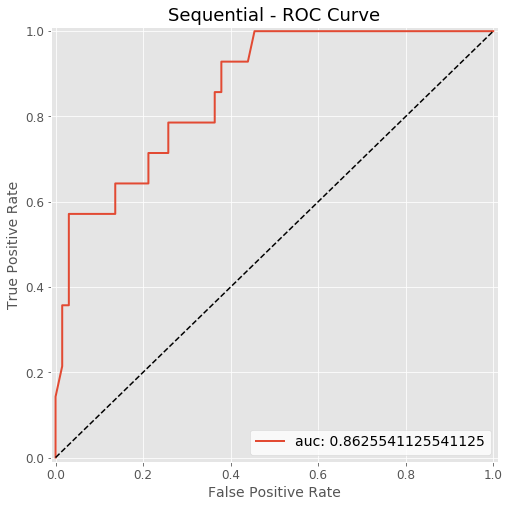

In [107]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(test_df['Severity'], test_probability)
auc_NL = roc_auc_score(test_df['Severity'], test_probability)
plot_roc_curve(fpr, tpr, auc_NL, weighted_model)

In [108]:
test_class=weighted_model.predict_classes(test_Features)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [109]:
pd.crosstab(test_df['Severity'], test_class[:,0])

col_0      0   1
Severity        
0         46  20
1          3  11

In [110]:
test_probability=weighted_model.predict(test_Features)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [111]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [112]:
fpr, tpr, _ = roc_curve(test_df['Severity'], test_probability)
auc_NL = roc_auc_score(test_df['Severity'], test_probability)

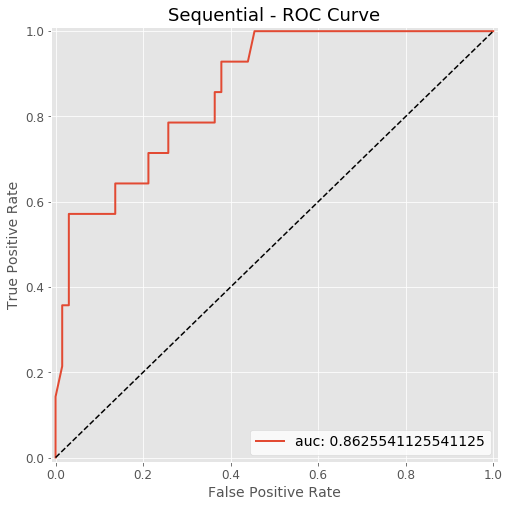

In [113]:
plot_roc_curve(fpr, tpr, auc_NL, weighted_model)

In [114]:
test_probability=weighted_model.predict_classes(test_Features)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [115]:
scores=weighted_model.evaluate(test_Features, test_Label, verbose=0)
from sklearn.metrics import accuracy_score
accu_NL=accuracy_score(test_Label, test_probability)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_59020 in device /job:localhost/replica:0/task:

In [116]:
accu_NL

0.7125

In [117]:
test_reshape=np.reshape(test_probability, test_probability.shape[0])

In [118]:
pd.crosstab(test_Label, test_reshape,
           rownames=['lable'], colnames=['prediction'])

prediction   0   1
lable             
0.0         46  20
1.0          3  11

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD

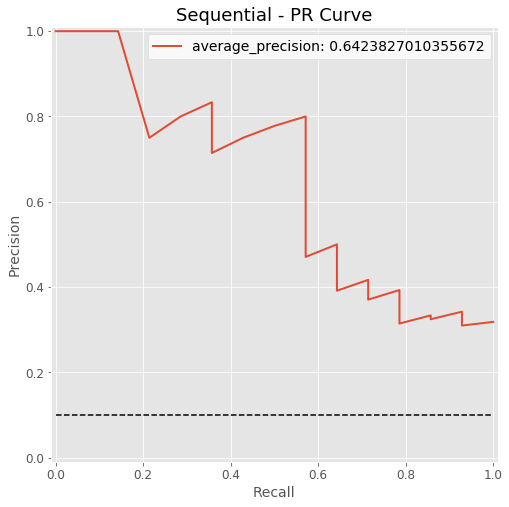

In [119]:
# predict probabilities
test_probability=weighted_model.predict(test_Features)
pred_proba_NL = np.reshape(test_probability, test_probability.shape[0])
# keep probabilities for the positive outcome only
#pred_proba_NL = pred_proba_NL[:, 1]
# predict class values
yhat = weighted_model.predict_classes(test_Features)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_Label, pred_proba_NL)
# calculate F1 score
f1 = f1_score(test_Label, yhat)
# calculate precision-recall AUC
auc_NL_pr=auc(recall, precision)
# calculate average precision score
ap_NL_pr = average_precision_score(test_Label, pred_proba_NL)
print('f1=%.3f auc_NL=%.3f ap=%.3f' % (f1, auc_NL_pr, ap_NL_pr))

plot_precision_recall_curve(recall, precision, auc_NL_pr, weighted_model)

# Hyperparameters of deep learning

In [120]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd


import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [121]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [122]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [123]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [124]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([100, 150, 200, 250, 300])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([100, 150, 200, 250, 300]))
HP_NUM_UNITS3 = hp.HParam('num_units 3', hp.Discrete([100, 150, 200, 250, 300]))
HP_DROPOUT1 = hp.HParam('dropout 1', hp.Discrete([0.1, 0.3, 0.5]))
HP_DROPOUT2= hp.HParam('dropout 2', hp.Discrete([0.1, 0.3, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'ROC_AUC'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_NUM_UNITS3,HP_DROPOUT1, HP_DROPOUT2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='ROC_AUC')],
  )


Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteRawProtoSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [125]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], activation=tf.nn.relu, input_shape=(train_Features.shape[-1],)),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT2]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS3], activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
      
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.AUC()]
  )

  model.fit(train_Features, train_Label, class_weight=class_weight,
          epochs=700, batch_size=100) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(test_Features, test_Label)
  return accuracy

In [126]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


# 10 fold cross-validation

In [127]:
train_Features

array([[1.  , 0.45, 1.  , 0.  , 0.  ],
       [0.  , 0.62, 1.  , 1.  , 0.  ],
       [1.  , 0.31, 1.  , 0.  , 0.  ],
       ...,
       [0.  , 0.39, 1.  , 0.  , 0.  ],
       [0.  , 0.56, 1.  , 0.  , 0.  ],
       [0.  , 0.53, 1.  , 0.  , 0.  ]])

In [128]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for dropout_rate1 in HP_DROPOUT1.domain.values:
                for dropout_rate2 in HP_DROPOUT2.domain.values:
                     for optimizer in HP_OPTIMIZER.domain.values:
          
                            hparams = {
              HP_NUM_UNITS1: num_units1,
              HP_NUM_UNITS2: num_units2,
              HP_NUM_UNITS3: num_units3,
              HP_DROPOUT1: dropout_rate1,
              HP_DROPOUT2: dropout_rate2,
              #HP_L2: l2,
              HP_OPTIMIZER: optimizer
              
          }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            run('logs/hparam_tuning/' + run_name, hparams)
                            session_num += 1

--- Starting trial: run-0
{'num_units 1': 100, 'num_units 2': 100, 'num_units 3': 100, 'dropout 1': 0.1, 'dropout 2': 0.1, 'optimizer': 'adam'}
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
  ...
    to  
  ['...']
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Parall

718/718 [==============================] - 0s 71us/sample - loss: 0.4516 - auc_4: 0.8619
Epoch 132/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4750 - auc_4: 0.8471
Epoch 133/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4592 - auc_4: 0.8584
Epoch 134/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4589 - auc_4: 0.8545
Epoch 135/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4617 - auc_4: 0.8537
Epoch 136/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4670 - auc_4: 0.8490
Epoch 137/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4505 - auc_4: 0.8624
Epoch 138/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4565 - auc_4: 0.8589
Epoch 139/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4637 - auc_4: 0.8517
Epoch 140/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4558 

718/718 [==============================] - 0s 67us/sample - loss: 0.4326 - auc_4: 0.8669
Epoch 290/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4271 - auc_4: 0.8768
Epoch 291/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4401 - auc_4: 0.8648
Epoch 292/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4330 - auc_4: 0.8691
Epoch 293/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4461 - auc_4: 0.8658
Epoch 294/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4290 - auc_4: 0.8737
Epoch 295/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4346 - auc_4: 0.8674
Epoch 296/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4366 - auc_4: 0.8630
Epoch 297/700
718/718 [==============================] - 0s 63us/sample - loss: 0.4267 - auc_4: 0.8715
Epoch 298/700
718/718 [==============================] - 0s 62us/sample - loss: 0.4269 

718/718 [==============================] - 0s 65us/sample - loss: 0.4194 - auc_4: 0.8791
Epoch 448/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4247 - auc_4: 0.8705
Epoch 449/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4193 - auc_4: 0.8793
Epoch 450/700
718/718 [==============================] - 0s 74us/sample - loss: 0.4223 - auc_4: 0.8743
Epoch 451/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4301 - auc_4: 0.8726
Epoch 452/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4223 - auc_4: 0.8764
Epoch 453/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4261 - auc_4: 0.8737
Epoch 454/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4351 - auc_4: 0.8722
Epoch 455/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4220 - auc_4: 0.8771
Epoch 456/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4337 

718/718 [==============================] - 0s 66us/sample - loss: 0.4214 - auc_4: 0.8775
Epoch 606/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4115 - auc_4: 0.8826
Epoch 607/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4162 - auc_4: 0.8806
Epoch 608/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4187 - auc_4: 0.8760
Epoch 609/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4165 - auc_4: 0.8828
Epoch 610/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4124 - auc_4: 0.8812
Epoch 611/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4113 - auc_4: 0.8832
Epoch 612/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4065 - auc_4: 0.8855
Epoch 613/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4180 - auc_4: 0.8790
Epoch 614/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4209 

718/718 [==============================] - 0s 66us/sample - loss: 0.5215 - auc_5: 0.8152
Epoch 24/700
718/718 [==============================] - 0s 66us/sample - loss: 0.5271 - auc_5: 0.8076
Epoch 25/700
718/718 [==============================] - 0s 68us/sample - loss: 0.5162 - auc_5: 0.8189
Epoch 26/700
718/718 [==============================] - 0s 68us/sample - loss: 0.5176 - auc_5: 0.8213
Epoch 27/700
718/718 [==============================] - 0s 71us/sample - loss: 0.5039 - auc_5: 0.8280
Epoch 28/700
718/718 [==============================] - 0s 65us/sample - loss: 0.5048 - auc_5: 0.8314
Epoch 29/700
718/718 [==============================] - 0s 66us/sample - loss: 0.5080 - auc_5: 0.8281
Epoch 30/700
718/718 [==============================] - 0s 69us/sample - loss: 0.5158 - auc_5: 0.8212
Epoch 31/700
718/718 [==============================] - 0s 66us/sample - loss: 0.5115 - auc_5: 0.8233
Epoch 32/700
718/718 [==============================] - 0s 70us/sample - loss: 0.5126 - auc_5: 

718/718 [==============================] - 0s 74us/sample - loss: 0.4544 - auc_5: 0.8605
Epoch 183/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4493 - auc_5: 0.8635
Epoch 184/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4390 - auc_5: 0.8684
Epoch 185/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4455 - auc_5: 0.8636
Epoch 186/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4517 - auc_5: 0.8610
Epoch 187/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4611 - auc_5: 0.8527
Epoch 188/700
718/718 [==============================] - 0s 81us/sample - loss: 0.4619 - auc_5: 0.8510
Epoch 189/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4385 - auc_5: 0.8693
Epoch 190/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4489 - auc_5: 0.8645
Epoch 191/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4531 

718/718 [==============================] - 0s 70us/sample - loss: 0.4333 - auc_5: 0.8719
Epoch 341/700
718/718 [==============================] - 0s 64us/sample - loss: 0.4419 - auc_5: 0.8628
Epoch 342/700
718/718 [==============================] - 0s 76us/sample - loss: 0.4344 - auc_5: 0.8661
Epoch 343/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4301 - auc_5: 0.8704
Epoch 344/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4310 - auc_5: 0.8711
Epoch 345/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4370 - auc_5: 0.8675
Epoch 346/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4315 - auc_5: 0.8702
Epoch 347/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4403 - auc_5: 0.8660
Epoch 348/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4232 - auc_5: 0.8761
Epoch 349/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4290 

718/718 [==============================] - 0s 74us/sample - loss: 0.4280 - auc_5: 0.8712
Epoch 499/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4342 - auc_5: 0.8696
Epoch 500/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4157 - auc_5: 0.8842
Epoch 501/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4279 - auc_5: 0.8705
Epoch 502/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4359 - auc_5: 0.8678
Epoch 503/700
718/718 [==============================] - 0s 61us/sample - loss: 0.4391 - auc_5: 0.8653
Epoch 504/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4172 - auc_5: 0.8791
Epoch 505/700
718/718 [==============================] - 0s 60us/sample - loss: 0.4318 - auc_5: 0.8710
Epoch 506/700
718/718 [==============================] - 0s 62us/sample - loss: 0.4161 - auc_5: 0.8810
Epoch 507/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4314 

718/718 [==============================] - 0s 73us/sample - loss: 0.4041 - auc_5: 0.8851
Epoch 657/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4285 - auc_5: 0.8755
Epoch 658/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4147 - auc_5: 0.8799
Epoch 659/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4079 - auc_5: 0.8888
Epoch 660/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4199 - auc_5: 0.8768
Epoch 661/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4236 - auc_5: 0.8749
Epoch 662/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4051 - auc_5: 0.8850
Epoch 663/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4134 - auc_5: 0.8824
Epoch 664/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4198 - auc_5: 0.8756
Epoch 665/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4104 

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_103892 in device /job:localhost/replica:0/task:0/device:GPU:0
718/718 [==============================] - 1s 936us/sample - loss: 0.6954 - auc_6: 0.5273
Epoch 2/700
718/718 [==============================] - 0s 70us/sample - loss: 0.6822 - auc_6: 0.6073
Epoch 3/700
718/718 [==============================] - 0s 70us/sample - loss: 0.6705 - auc_6: 0.6693
Epoch 4/700
718/718 [==============================] - 0s 66us/sample - loss: 0.6661 - auc_6: 0.6669
Epoch 5/700
718/718 [==============================] - 0s 68us/sample - loss: 0.6634 - auc_6: 0.6515
Epoch 6/700
718/718 [==============================] - 0s 66us/sample - loss: 0.6417 - auc_6: 0.7210
Epoch 7/700
718/718 [==============================] - 0s 68us/sample - loss: 0.6280 - auc_6: 0.7291
Epoch 8/700
718/718 [===============

718/718 [==============================] - 0s 66us/sample - loss: 0.4611 - auc_6: 0.8540
Epoch 158/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4669 - auc_6: 0.8500
Epoch 159/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4648 - auc_6: 0.8512
Epoch 160/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4504 - auc_6: 0.8596
Epoch 161/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4789 - auc_6: 0.8447
Epoch 162/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4750 - auc_6: 0.8427
Epoch 163/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4758 - auc_6: 0.8470
Epoch 164/700
718/718 [==============================] - 0s 65us/sample - loss: 0.4698 - auc_6: 0.8469
Epoch 165/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4514 - auc_6: 0.8623
Epoch 166/700
718/718 [==============================] - 0s 63us/sample - loss: 0.4598 

718/718 [==============================] - 0s 67us/sample - loss: 0.4440 - auc_6: 0.8663
Epoch 316/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4522 - auc_6: 0.8556
Epoch 317/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4354 - auc_6: 0.8668
Epoch 318/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4450 - auc_6: 0.8628
Epoch 319/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4447 - auc_6: 0.8659
Epoch 320/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4414 - auc_6: 0.8627
Epoch 321/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4371 - auc_6: 0.8710
Epoch 322/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4414 - auc_6: 0.8675
Epoch 323/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4368 - auc_6: 0.8670
Epoch 324/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4393 

718/718 [==============================] - 0s 72us/sample - loss: 0.4346 - auc_6: 0.8743
Epoch 474/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4321 - auc_6: 0.8701
Epoch 475/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4403 - auc_6: 0.8658
Epoch 476/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4328 - auc_6: 0.8716
Epoch 477/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4361 - auc_6: 0.8712
Epoch 478/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4276 - auc_6: 0.8737
Epoch 479/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4285 - auc_6: 0.8734
Epoch 480/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4384 - auc_6: 0.8673
Epoch 481/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4385 - auc_6: 0.8674
Epoch 482/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4328 

718/718 [==============================] - 0s 71us/sample - loss: 0.4154 - auc_6: 0.8801
Epoch 632/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4211 - auc_6: 0.8786
Epoch 633/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4426 - auc_6: 0.8704
Epoch 634/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4373 - auc_6: 0.8664
Epoch 635/700
718/718 [==============================] - 0s 74us/sample - loss: 0.4301 - auc_6: 0.8692
Epoch 636/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4289 - auc_6: 0.8728
Epoch 637/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4328 - auc_6: 0.8703
Epoch 638/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4211 - auc_6: 0.8771
Epoch 639/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4293 - auc_6: 0.8681
Epoch 640/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4214 

718/718 [==============================] - 0s 68us/sample - loss: 0.4978 - auc_7: 0.8334
Epoch 53/700
718/718 [==============================] - 0s 70us/sample - loss: 0.5208 - auc_7: 0.8212
Epoch 54/700
718/718 [==============================] - 0s 67us/sample - loss: 0.5094 - auc_7: 0.8270
Epoch 55/700
718/718 [==============================] - 0s 68us/sample - loss: 0.5073 - auc_7: 0.8264
Epoch 56/700
718/718 [==============================] - 0s 67us/sample - loss: 0.5055 - auc_7: 0.8297
Epoch 57/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4970 - auc_7: 0.8316
Epoch 58/700
718/718 [==============================] - ETA: 0s - loss: 0.3839 - auc_7: 0.917 - 0s 68us/sample - loss: 0.5054 - auc_7: 0.8299
Epoch 59/700
718/718 [==============================] - 0s 67us/sample - loss: 0.5058 - auc_7: 0.8279
Epoch 60/700
718/718 [==============================] - 0s 69us/sample - loss: 0.5103 - auc_7: 0.8267
Epoch 61/700
718/718 [==============================] -

718/718 [==============================] - 0s 63us/sample - loss: 0.4659 - auc_7: 0.8484
Epoch 211/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4639 - auc_7: 0.8537
Epoch 212/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4619 - auc_7: 0.8542
Epoch 213/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4607 - auc_7: 0.8544
Epoch 214/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4549 - auc_7: 0.8572
Epoch 215/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4610 - auc_7: 0.8531
Epoch 216/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4626 - auc_7: 0.8515
Epoch 217/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4514 - auc_7: 0.8651
Epoch 218/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4571 - auc_7: 0.8544
Epoch 219/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4547 

718/718 [==============================] - 0s 65us/sample - loss: 0.4372 - auc_7: 0.8686
Epoch 369/700
718/718 [==============================] - 0s 63us/sample - loss: 0.4378 - auc_7: 0.8682
Epoch 370/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4386 - auc_7: 0.8660
Epoch 371/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4271 - auc_7: 0.8745
Epoch 372/700
718/718 [==============================] - 0s 76us/sample - loss: 0.4473 - auc_7: 0.8595
Epoch 373/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4287 - auc_7: 0.8769
Epoch 374/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4428 - auc_7: 0.8655
Epoch 375/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4331 - auc_7: 0.8696
Epoch 376/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4375 - auc_7: 0.8678
Epoch 377/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4280 

718/718 [==============================] - 0s 73us/sample - loss: 0.4328 - auc_7: 0.8707
Epoch 527/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4294 - auc_7: 0.8759
Epoch 528/700
718/718 [==============================] - 0s 73us/sample - loss: 0.4314 - auc_7: 0.8724
Epoch 529/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4301 - auc_7: 0.8703
Epoch 530/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4327 - auc_7: 0.8712
Epoch 531/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4458 - auc_7: 0.8667
Epoch 532/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4435 - auc_7: 0.8629
Epoch 533/700
718/718 [==============================] - 0s 72us/sample - loss: 0.4467 - auc_7: 0.8695
Epoch 534/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4311 - auc_7: 0.8725
Epoch 535/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4363 

718/718 [==============================] - 0s 67us/sample - loss: 0.4251 - auc_7: 0.8727
Epoch 685/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4158 - auc_7: 0.8795
Epoch 686/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4203 - auc_7: 0.8755
Epoch 687/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4226 - auc_7: 0.8724
Epoch 688/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4136 - auc_7: 0.8844
Epoch 689/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4305 - auc_7: 0.8725
Epoch 690/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4342 - auc_7: 0.8693
Epoch 691/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4273 - auc_7: 0.8744
Epoch 692/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4366 - auc_7: 0.8682
Epoch 693/700
718/718 [==============================] - 0s 63us/sample - loss: 0.4334 

Epoch 106/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4794 - auc_8: 0.8450
Epoch 107/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4694 - auc_8: 0.8530
Epoch 108/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4942 - auc_8: 0.8338
Epoch 109/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4832 - auc_8: 0.8445
Epoch 110/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4775 - auc_8: 0.8496
Epoch 111/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4924 - auc_8: 0.8340
Epoch 112/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4809 - auc_8: 0.8412
Epoch 113/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4828 - auc_8: 0.8404
Epoch 114/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4791 - auc_8: 0.8443
Epoch 115/700
718/718 [==============================] - 0s 65us/sample -

718/718 [==============================] - 0s 60us/sample - loss: 0.4628 - auc_8: 0.8506
Epoch 265/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4549 - auc_8: 0.8583
Epoch 266/700
718/718 [==============================] - 0s 67us/sample - loss: 0.4511 - auc_8: 0.8617
Epoch 267/700
718/718 [==============================] - 0s 60us/sample - loss: 0.4610 - auc_8: 0.8516
Epoch 268/700
718/718 [==============================] - 0s 68us/sample - loss: 0.4612 - auc_8: 0.8537
Epoch 269/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4619 - auc_8: 0.8536
Epoch 270/700
718/718 [==============================] - 0s 71us/sample - loss: 0.4590 - auc_8: 0.8560
Epoch 271/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4439 - auc_8: 0.8666
Epoch 272/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4569 - auc_8: 0.8545
Epoch 273/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4554 

718/718 [==============================] - 0s 69us/sample - loss: 0.4298 - auc_8: 0.8764
Epoch 422/700
718/718 [==============================] - 0s 69us/sample - loss: 0.4306 - auc_8: 0.8721
Epoch 423/700
718/718 [==============================] - 0s 66us/sample - loss: 0.4487 - auc_8: 0.8596
Epoch 424/700
718/718 [==============================] - 0s 70us/sample - loss: 0.4511 - auc_8: 0.8628
Epoch 425/700
100/718 [===>..........................] - ETA: 0s - loss: 0.5851 - auc_8: 0.7931

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir logs/hparam_tuning --reload_multifile=true

In [ ]:
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
import numpy

In [ ]:
seed = 7
numpy.random.seed(seed)

In [ ]:
X, Y=PreprocessData(df)

# Deep learning 10-fold cross validation test

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_NL=[]
roc_auc_NL=[]
f1_NL=[]
auc_NL_pr_all=[]
ap_NL_pr_all=[]
for train, test in kfold.split(X, Y):
   # create model
    model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(300, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()]
    )
    # Fit the model
    model.fit(X[train],Y[train], 
          epochs=300, batch_size=100, class_weight=class_weight, verbose=0)
    
    
    scores = model.evaluate(X[test], Y[test], verbose=0)[1]
    test_probability=model.predict(X[test])
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    yhat = model.predict_classes(X[test])
    
    auc_NL = roc_auc_score(Y[test],  pred_proba_NL)
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_NL)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_NL_pr=auc(recall, precision)
    # calculate average precision score
    ap_NL_pr= average_precision_score(Y[test], pred_proba_NL)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_NL.append( scores)
    roc_auc_NL.append(auc_NL)
    f1_NL.append( f1)
    auc_NL_pr_all.append(auc_NL_pr)
    ap_NL_pr_all.append(ap_NL_pr)

In [ ]:
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_NL)*100, numpy.std(scores_NL)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_NL)*100, numpy.std(roc_auc_NL)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_NL)*100, numpy.std(f1_NL)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_NL_pr_all)*100, numpy.std(auc_NL_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_NL_pr_all)*100, numpy.std(ap_NL_pr_all)*100))

# Logistic regression 10-fold cross validation test

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_lr=[]
roc_auc_lr=[]
f1_lr=[]
auc_lr_pr_all=[]
ap_lr_pr_all=[]
for train, test in kfold.split(X, Y):
    # Import model and retrain
    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])
    #class_weight
    unique, counts=numpy.unique(Y[train], return_counts=True)
    severe=counts[1]
    mild=counts[0]
    class_weights={
    1: 1 / severe,
    0: 1 / mild}
    
    accu_lr = accuracy_score(Y[test], lr_clf.predict(X[test]))
   # create model
    pred_proba_lr = lr_clf.predict_proba(X[test])
    pred_proba_lr = pred_proba_lr[:, 1]
    yhat = lr_clf.predict(X[test])
    
    auc_lr = roc_auc_score(Y[test],  pred_proba_lr)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_lr)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_lr_pr=auc(recall, precision)
    # calculate average precision score
    ap_lr_pr= average_precision_score(Y[test], pred_proba_lr)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_lr.append( accu_lr )
    roc_auc_lr.append( auc_lr )
    f1_lr.append( f1)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr_pr_all.append(ap_lr_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_lr)*100, numpy.std(scores_lr)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_lr)*100, numpy.std(roc_auc_lr)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_lr)*100, numpy.std(f1_lr)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_lr_pr_all)*100, numpy.std(auc_lr_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_lr_pr_all)*100, numpy.std(ap_lr_pr_all)*100))

# Random forest 10-fold cross validation test

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_rf=[]
roc_auc_rf=[]
f1_rf=[]
auc_rf_pr_all=[]
ap_rf_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
        rf_clf.fit(X[train], Y[train])
    
        accu_rf = accuracy_score(Y[test], rf_clf.predict(X[test]))
   # create model
        pred_proba_rf = rf_clf.predict_proba(X[test])
        pred_proba_rf = pred_proba_rf[:, 1]
        yhat = rf_clf.predict(X[test])
        auc_rf = roc_auc_score(Y[test],  pred_proba_rf)
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_rf)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_rf_pr=auc(recall, precision)
    # calculate average precision score
        ap_rf_pr= average_precision_score(Y[test], pred_proba_rf)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_rf.append( accu_rf )
        roc_auc_rf.append(auc_rf)
        f1_rf.append( f1)
        auc_rf_pr_all.append(auc_rf_pr)
        ap_rf_pr_all.append(ap_rf_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_rf)*100, numpy.std(roc_auc_rf)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

# Gradient boosting machine learning model

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_gbm=[]
roc_auc_gbm=[]
f1_gbm=[]
auc_gbm_pr_all=[]
ap_gbm_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
        gbm_clf.fit(X[train], Y[train])
    
        accu_gbm = accuracy_score(Y[test], gbm_clf.predict(X[test]))
   # create model
        pred_proba_gbm = gbm_clf.predict_proba(X[test])
        pred_proba_gbm = pred_proba_gbm[:, 1]
        yhat = gbm_clf.predict(X[test])
        
        auc_gbm = roc_auc_score(Y[test],  pred_proba_gbm)
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_gbm)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_gbm_pr=auc(recall, precision)
    # calculate average precision score
        ap_gbm_pr= average_precision_score(Y[test], pred_proba_gbm)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_gbm.append( accu_gbm )
        roc_auc_gbm.append(auc_gbm)
        f1_gbm.append( f1)
        auc_gbm_pr_all.append(auc_gbm_pr)
        ap_gbm_pr_all.append(ap_gbm_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_gbm)*100, numpy.std(roc_auc_gbm)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

# SVC

In [ ]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_svc=[]
roc_auc_svc=[]
f1_svc=[]
auc_svc_pr_all=[]
ap_svc_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
        svc_clf.fit(X[train], Y[train])
    
        accu_svc = accuracy_score(Y[test], svc_clf.predict(X[test]))
   # create model
        pred_proba_svc = svc_clf.predict_proba(X[test])
        pred_proba_svc = pred_proba_svc[:, 1]
        yhat = svc_clf.predict(X[test])
        
        auc_svc = roc_auc_score(Y[test],  pred_proba_svc)
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_svc)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_svc_pr=auc(recall, precision)
    # calculate average precision score
        ap_svc_pr= average_precision_score(Y[test], pred_proba_svc)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_svc.append( accu_svc )
        roc_auc_svc.append(auc_svc)
        f1_svc.append( f1)
        auc_svc_pr_all.append(auc_svc_pr)
        ap_svc_pr_all.append(ap_svc_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_svc)*100, numpy.std(scores_svc)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_svc)*100, numpy.std(roc_auc_svc)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_svc)*100, numpy.std(f1_svc)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_svc_pr_all)*100, numpy.std(auc_svc_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_svc_pr_all)*100, numpy.std(ap_svc_pr_all)*100))

## Summary
Support vector machine, random forests and gradient boosting classifiers are better than Apache 3 and ANZROD in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The Deep learner performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

There are also composite scores that attempt to summarize the precision and recall; three examples include:

F score or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

Average precision: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

Area Under Curve: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

In [ ]:
Finaldf=pd.DataFrame([[numpy.mean(scores_lr), numpy.mean(scores_svc), numpy.mean(scores_rf), numpy.mean(scores_gbm), numpy.mean(scores_NL)],
              [numpy.std(scores_lr), numpy.std(scores_svc), numpy.std(scores_rf), numpy.std(scores_gbm), numpy.std(scores_NL)],
              [numpy.mean(roc_auc_lr), numpy.mean(roc_auc_svc), numpy.mean(roc_auc_rf),numpy.mean(roc_auc_gbm), numpy.mean(roc_auc_NL)],
              [numpy.std(roc_auc_lr), numpy.std(roc_auc_svc), numpy.std(roc_auc_rf),numpy.std(roc_auc_gbm), numpy.std(roc_auc_NL)],
              [numpy.mean(auc_lr_pr_all), numpy.mean(auc_svc_pr_all), numpy.mean(auc_rf_pr_all), numpy.mean(auc_gbm_pr_all),  numpy.mean(auc_NL_pr_all)],
              [numpy.std(auc_lr_pr_all), numpy.std(auc_svc_pr_all), numpy.std(auc_rf_pr_all), numpy.std(auc_gbm_pr_all),  numpy.std(auc_NL_pr_all)],
              [numpy.mean(ap_lr_pr_all), numpy.mean(ap_svc_pr_all), numpy.mean(ap_rf_pr_all), numpy.mean(ap_gbm_pr_all),  numpy.mean(ap_NL_pr_all)],
              [numpy.std(ap_lr_pr_all), numpy.std(ap_svc_pr_all), numpy.std(ap_rf_pr_all), numpy.std(ap_gbm_pr_all),  numpy.std(ap_NL_pr_all)]],
              index=['Accuracy(>=.5)','Accuracy(>=.5)SD','Area Under (ROC) Curve', 'Area Under (ROC) Curve SD','Area Under (Precision-recall) Curve', 'Area Under (Precision-recall) Curve SD','Average precision score', 'Average precision score SD' ],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine',  'Deep Learner'])

In [ ]:
Finaldf

In [ ]:
Finaldf.to_csv('20200312finaltable.csv')

# Deep learning model explaination by SHAP

In [ ]:
df_Features=df.iloc[:,1:]
df_Labels=df.iloc[:,0]

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(df_Features, df_Labels, test_size=.2, 
                                         stratify=df.Severity, random_state=42)

In [ ]:
import sklearn
import shap


# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(300, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
model.fit(X_train,Y_train, 
          class_weight=class_weight,
          epochs=400, batch_size=100, verbose=2)

In [ ]:
test_probability=model.predict(X_test)
pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
#yhat = model.predict_classes(test_Features)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

In [ ]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][4,:], X_test.iloc[4,:])

In [ ]:
Y_test[4]

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [ ]:
shap.summary_plot(shap_values[0], X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.dependence_plot("age", shap_values[0], X_test)

In [ ]:
shap.dependence_plot("NS1", shap_values[0], X_test)

In [ ]:
shap.dependence_plot("IgM", shap_values[0], X_test)

In [ ]:
shap.dependence_plot("IgG", shap_values[0], X_test)

In [ ]:
shap.dependence_plot("sex", shap_values[0], X_test)

In [ ]:
pred_proba_NL.shape

### Concat prediction_proba for each model to test set, save test set

In [ ]:
def pred_proba(train_x, train_y, test_x, test_y):
    data=pd.DataFrame()
    data['severity']= test_y

    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(train_x, train_y)
    pred_proba_lr = lr_clf.predict_proba(test_x)[:, 1]
    data['lr_pred_proba'] = pred_proba_lr


    with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(train_x, train_y)
    pred_proba_rf = rf_clf.predict_proba(test_x)[:, 1]
    data['rf_pred_proba'] = pred_proba_rf


    with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(train_x, train_y)
    pred_proba_svc = svc_clf.predict_proba(test_x)[:, 1]
    data['svc_pred_proba'] = pred_proba_svc

    with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(train_x, train_y)
    pred_proba_gbm = gbm_clf.predict_proba(test_x)[:, 1]
    data['gbm_pred_proba'] = pred_proba_gbm


    model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(train_x.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(300, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
    model.fit(train_x,train_y, 
          class_weight=class_weight,
          epochs=400, batch_size=100, verbose=2)

    test_probability=model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    return data_test

In [ ]:
data_test=pred_proba(train_Features, train_Label, test_Features, test_Label)

In [ ]:
data_test.to_csv('test_set_with_predictions.csv')

## Class breakdown per model

In [ ]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=20, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

In [ ]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='lr', 
                          plot_title='lr Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='rf', 
                          plot_title='rf Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='SVC', 
                          plot_title='SVC Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='GBM', 
                          plot_title='GBM Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist(data_test, 'NL_pred_proba', var_name='NL Risk of Death', 
                          plot_title='NL Class Breakdown', bins=100)

In [ ]:
data_test_all=pred_proba(X_train, Y_train, X, Y)

In [ ]:
def plot_class_breakdown_hist2(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=100, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

In [ ]:
plot_class_breakdown_hist2(data_all, 'lr_pred_proba', var_name='lr Risk of Death', 
                          plot_title='lr Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist2(data_all, 'rf_pred_proba', var_name='rf Risk of Death', 
                          plot_title='rf Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist2(data_all, 'svc_pred_proba', var_name='svc Risk of Death', 
                          plot_title='svc Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist2(data_all, 'gbm_pred_proba', var_name='gbm Risk of Death', 
                          plot_title='gbm Class Breakdown', bins=100)

In [ ]:
plot_class_breakdown_hist2(data_all, 'NL_pred_proba', var_name='NL Risk of Death', 
                          plot_title='NL Class Breakdown', bins=100)

In [ ]:
def pred_proba(train_x, train_y, test_x, test_y):
    data=pd.DataFrame()
    data['severity']= test_y

    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(train_x, train_y)
    pred_proba_lr = lr_clf.predict_proba(test_x)[:, 1]
    data['lr_pred_proba'] = pred_proba_lr


    with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(train_x, train_y)
    pred_proba_rf = rf_clf.predict_proba(test_x)[:, 1]
    data['rf_pred_proba'] = pred_proba_rf


    with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(train_x, train_y)
    pred_proba_svc = svc_clf.predict_proba(test_x)[:, 1]
    data['svc_pred_proba'] = pred_proba_svc

    with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(train_x, train_y)
    pred_proba_gbm = gbm_clf.predict_proba(test_x)[:, 1]
    data['gbm_pred_proba'] = pred_proba_gbm


    model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(train_x.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(300, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
    model.fit(train_x,train_y, 
          class_weight=class_weight,
          epochs=400, batch_size=100, verbose=2)

    test_probability=model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    return data_test

In [ ]:
# define 10-fold cross validation test harness
from scipy import interp
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

tprs_ANN = []
aucs_ANN = []
tprs_lr = []
aucs_lr = []
tprs_rf = []
aucs_rf = []
tprs_gbm = []
aucs_gbm = []
tprs_svc = []
aucs_svc = []
mean_fpr_ANN = np.linspace(0, 1, 100)
mean_fpr_lr = np.linspace(0, 1, 100)
mean_fpr_rf = np.linspace(0, 1, 100)
mean_fpr_gbm = np.linspace(0, 1, 100)
mean_fpr_svc = np.linspace(0, 1, 100)
accus_ANN=[]
accus_lr=[]
accus_rf=[]
accus_gbm=[]
accus_svc=[]
aps_ANN=[]
aps_lr=[]
aps_rf=[]
aps_gbm=[]
aps_svc=[]
auc_ANN_pr_all=[]
auc_lr_pr_all=[]
auc_rf_pr_all=[]
auc_gbm_pr_all=[]
auc_svc_pr_all=[]

i = 0
for train, test in kfold.split(X, Y):
    # Fit the ANN model
    model = keras.Sequential([
      keras.layers.Dense(250, activation='relu', input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(300, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()])
    model.fit(X[train],Y[train], 
          class_weight=class_weight,
          epochs=400, batch_size=100, verbose=0)
    model.fit(X[train],Y[train])
    test_probability_ANN=model.predict(X[test])
    pred_proba_ANN = np.reshape(test_probability_ANN,test_probability_ANN.shape[0])

    fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(Y[test], pred_proba_ANN)
    tprs_ANN.append(interp(mean_fpr_ANN, fpr_ANN, tpr_ANN))
    tprs_ANN[-1][0] = 0.0
    roc_auc_ANN = sklearn.metrics.auc(fpr_ANN, tpr_ANN)
    aucs_ANN.append(roc_auc_ANN)
    accu_ANN=accuracy_score(Y[test], model.predict_classes(X[test]))
    accus_ANN.append(accu_ANN)
    precision_ANN, recall_ANN, thresholds_ANN = precision_recall_curve(Y[test], pred_proba_ANN)
    auc_ANN_pr=sklearn.metrics.auc(recall_ANN, precision_ANN)
    auc_ANN_pr_all.append(auc_ANN_pr)
    ap_ANN= average_precision_score(Y[test], pred_proba_ANN)
    aps_ANN.append(ap_ANN)
    
    # Fit the LR model
    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])
    pred_proba_lr = lr_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y[test],  pred_proba_lr)
    tprs_lr.append(interp(mean_fpr_lr, fpr_lr, tpr_lr))
    tprs_lr[-1][0] = 0.0
    roc_auc_lr = sklearn.metrics.auc(fpr_lr, tpr_lr)
    aucs_lr.append(roc_auc_lr)
    accu_lr = accuracy_score(Y[test],  lr_clf.predict(X[test]))
    accus_lr.append(accu_lr)
    precision_lr, recall_lr, thresholds_lr = precision_recall_curve(Y[test], pred_proba_lr)
    auc_lr_pr=sklearn.metrics.auc(recall_lr, precision_lr)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr= average_precision_score(Y[test], pred_proba_lr)
    aps_lr.append(ap_lr)
    
    # Fit the RF model
    with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(X[train], Y[train])
    pred_proba_rf = rf_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y[test],  pred_proba_rf)
    tprs_rf.append(interp(mean_fpr_rf, fpr_rf, tpr_rf))
    tprs_rf[-1][0] = 0.0
    roc_auc_rf = sklearn.metrics.auc(fpr_rf, tpr_rf)
    aucs_rf.append(roc_auc_rf)
    accu_rf = accuracy_score(Y[test],  rf_clf.predict(X[test]))
    accus_rf.append(accu_rf)
    precision_rf, recall_rf, thresholds_rf = precision_recall_curve(Y[test], pred_proba_rf)
    auc_rf_pr=sklearn.metrics.auc(recall_rf, precision_rf)
    auc_rf_pr_all.append(auc_rf_pr)
    ap_rf= average_precision_score(Y[test], pred_proba_rf)
    aps_rf.append(ap_rf)
    
    # Fit the gbm model
    with open('20200225gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(X[train], Y[train])
    pred_proba_gbm = gbm_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(Y[test],  pred_proba_gbm)
    tprs_gbm.append(interp(mean_fpr_gbm, fpr_gbm, tpr_gbm))
    tprs_gbm[-1][0] = 0.0
    roc_auc_gbm = sklearn.metrics.auc(fpr_gbm, tpr_gbm)
    aucs_gbm.append(roc_auc_gbm)
    accu_gbm = accuracy_score(Y[test],  gbm_clf.predict(X[test]))
    accus_gbm.append(accu_gbm)
    precision_gbm, recall_gbm, thresholds_gbm = precision_recall_curve(Y[test], pred_proba_gbm)
    auc_gbm_pr=sklearn.metrics.auc(recall_gbm, precision_gbm)
    auc_gbm_pr_all.append(auc_gbm_pr)
    ap_gbm= average_precision_score(Y[test], pred_proba_gbm)
    aps_gbm.append(ap_gbm)
    
    # Fit the svc model
    with open('20200225svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(X[train], Y[train])
    pred_proba_svc = svc_clf.predict_proba(X[test])[:, 1]
    # Compute ROC curve and area the curve
    fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y[test],  pred_proba_svc)
    tprs_svc.append(interp(mean_fpr_svc, fpr_svc, tpr_svc))
    tprs_svc[-1][0] = 0.0
    roc_auc_svc = sklearn.metrics.auc(fpr_svc, tpr_svc)
    aucs_svc.append(roc_auc_svc)
    accu_svc = accuracy_score(Y[test],  svc_clf.predict(X[test]))
    accus_svc.append(accu_svc)
    precision_svc, recall_svc, thresholds_svc = precision_recall_curve(Y[test], pred_proba_svc)
    auc_svc_pr=sklearn.metrics.auc(recall_svc, precision_svc)
    auc_svc_pr_all.append(auc_svc_pr)
    ap_svc= average_precision_score(Y[test], pred_proba_svc)
    aps_svc.append(ap_svc)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
# ANN curve
mean_tpr_ANN = np.mean(tprs_ANN, axis=0)
mean_tpr_ANN[-1] = 1.0
mean_auc_ANN = sklearn.metrics.auc(mean_fpr_ANN, mean_tpr_ANN)
std_auc_ANN = np.std(aucs_ANN)
plt.plot(mean_fpr_ANN, mean_tpr_ANN, color='b',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('ANN', mean_auc_ANN, std_auc_ANN),  
                     lw=2, alpha=.8)

std_tpr_ANN = np.std(tprs_ANN, axis=0)
tprs_upper_ANN = np.minimum(mean_tpr_ANN + std_tpr_ANN, 1)
tprs_lower_ANN = np.maximum(mean_tpr_ANN - std_tpr_ANN, 0)
plt.fill_between(mean_fpr_ANN, tprs_lower_ANN, tprs_upper_ANN, color='blue', alpha=.2,
                 label=r'$\pm$ ANN 1 std. dev.')
#LR curve
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = sklearn.metrics.auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(aucs_lr)
plt.plot(mean_fpr_lr, mean_tpr_lr, color='g',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('LR', mean_auc_lr, std_auc_lr),  
         lw=2, alpha=.8)

std_tpr_lr = np.std(tprs_lr, axis=0)
tprs_upper_lr = np.minimum(mean_tpr_lr + std_tpr_lr, 1)
tprs_lower_lr = np.maximum(mean_tpr_lr - std_tpr_lr, 0)
plt.fill_between(mean_fpr_lr, tprs_lower_lr, tprs_upper_lr, color='g', alpha=.2,
                 label=r'$\pm$ LR 1 std. dev.')

#RF curve
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = sklearn.metrics.auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='y',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('RF', mean_auc_rf, std_auc_rf),  
         lw=2, alpha=.8)

std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
plt.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='y', alpha=.2,
                 label=r'$\pm$ RF 1 std. dev.')

#GBM curve
mean_tpr_gbm = np.mean(tprs_gbm, axis=0)
mean_tpr_gbm[-1] = 1.0
mean_auc_gbm = sklearn.metrics.auc(mean_fpr_gbm, mean_tpr_gbm)
std_auc_gbm = np.std(aucs_gbm)
plt.plot(mean_fpr_gbm, mean_tpr_gbm, color='purple',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('GBM', mean_auc_gbm, std_auc_gbm),  
         lw=2, alpha=.8)

std_tpr_gbm = np.std(tprs_gbm, axis=0)
tprs_upper_gbm = np.minimum(mean_tpr_gbm + std_tpr_gbm, 1)
tprs_lower_gbm = np.maximum(mean_tpr_gbm - std_tpr_gbm, 0)
plt.fill_between(mean_fpr_gbm, tprs_lower_gbm, tprs_upper_gbm, color='purple', alpha=.2,
                 label=r'$\pm$ GBM 1 std. dev.')

#SVC curve
mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = sklearn.metrics.auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(aucs_svc)
plt.plot(mean_fpr_svc, mean_tpr_svc, color='orange',
         label='% s Mean ROC (AUC =  %0.3f $\pm$ %0.3f)'% ('SVC', mean_auc_svc, std_auc_svc),  
         lw=2, alpha=.8)

std_tpr_svc = np.std(tprs_svc, axis=0)
tprs_upper_svc = np.minimum(mean_tpr_svc + std_tpr_svc, 1)
tprs_lower_svc = np.maximum(mean_tpr_svc - std_tpr_svc, 0)
plt.fill_between(mean_fpr_svc, tprs_lower_svc, tprs_upper_svc, color='orange', alpha=.2,
                 label=r'$\pm$ SVC 1 std. dev.')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('models_roc_curve_10folds_20200324.tif', dpi=300)
plt.show()
  
print(np.mean(accus_ANN))
print(np.mean(accus_lr))
print(np.mean(accus_rf))
print(np.mean(accus_gbm))
print(np.mean(accus_svc))

print(np.mean(aps_ANN))
print(np.mean(aps_lr))
print(np.mean(aps_rf))
print(np.mean(aps_gbm))
print(np.mean(aps_svc))

In [ ]:
print(np.mean(aucs_ANN))
print(np.mean(aucs_lr))
print(np.mean(aucs_rf))
print(np.mean(aucs_gbm))
print(np.mean(aucs_svc))

In [ ]:
agegroup=[]
for i in range(test_df.shape[0]):
    age=test_df.iloc[i,2]
    if age <=30:
        agegroup.append(30)
    elif age <=40:
        agegroup.append(40)
    elif age <=50:
        agegroup.append(50)
    elif age <=60:
        agegroup.append(60)
    elif age <=70:
        agegroup.append(70)
    else:    
        agegroup.append("over 70")  
        

In [ ]:
test_df_agegroup=test_df
test_df_agegroup['agegroup']=agegroup

In [ ]:
test_df_agegroup

In [ ]:
agegroup_all=[]
for i in range(df.shape[0]):
    age=df.iloc[i,2]
    if age <=30:
        agegroup_all.append(30)
    elif age <=40:
        agegroup_all.append(40)
    elif age <=50:
        agegroup_all.append(50)
    elif age <=60:
        agegroup_all.append(60)
    elif age <=70:
        agegroup_all.append(70)
    else:    
        agegroup_all.append("over 70")  
        

In [ ]:
df_agegroup=df
df_agegroup['agegroup']=agegroup_all

In [ ]:
df_agegroup

In [ ]:
df_over70=df[(df.age>70)]

In [ ]:
df_over70['Severity'].sum()

In [ ]:
with open('20200225rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_Label)
pred_proba_rf = rf_clf.predict_proba(test_Features)[:, 1]

In [ ]:
pred_rf= rf_clf.predict(test_Features)

In [ ]:
pred_rf

In [ ]:
# observed mortality vs predicted mortality
# end result: Table with column per model (and true score on the end), rows are age groups
# get list of observed mortality per model (per age group find % mortality)
# then get df of all series together (per model create dict where key = model, vals = mortality)
# Create df from dict

#calculate observed mortality
df_agegroup['Severity'].sum() / len(df_agegroup['Severity'])

# calculate per age group
agegroup_list=['30','40','50','60','70','over 70']
predicted_mortality = []
for group in agegroup_list:
    severe=df_agegroup[(df_agegroup.agegroup == group)]['Severity'].sum()
    case_num=len(df_agegroup[(df_agegroup.agegroup == group)]['Severity'])
    predicted_mortality.append(severe/case_num)
predicted_mortality

In [269]:
# create list per model
models = ['lr_pred_proba','rf_pred_proba','svc_pred_proba',
          'gbm_pred_proba','NL_pred_proba','died_hosp']
predicted_mortality_dict = {}
for model in models:
    mortality_by_age_group = []
    for group in age_groups:
        mortality_by_age_group.append(data_test[(data_test.age_group == group)
        & (~data_test[model].isna())][model].sum() / len(data_test[(data_test.age_group == group) 
        & (~data_test[model].isna())][model]))
    predicted_mortality_dict[model] = mortality_by_age_group
predicted_dmortality_dict

# Create df from dict
observed_mortality_by_agegroup_df = pd.DataFrame.from_dict(predicted_mortality_dict)
# add age_group col
observed_mortality_by_agegroup_df["Age group"] = age_groups
# set age_group col as index
observed_mortality_by_agegroup_df.set_index("Age group", inplace=True)
#re-order columns
observed_mortality_by_agegroup_df = observed_mortality_by_agegroup_df[models]
#Rename columns
observed_mortality_by_agegroup_df.rename(columns={'died_hosp':'True Ratio',
                                                  'apache3riskofdeath':'Apache 3',
                                                  'anzrodriskofdeath':'ANZROD',
                                                 'lr_pred_proba':'Logistic Regression',
                                                 'rf_pred_proba':'Random Forest Classifier',
                                                 'svc_pred_proba':'Support Vector Classifier',
                                                 'gbm_pred_proba':'Gradient Boosted Machine',
                                                  'h2o_deep_pred_proba':'Deep Learner',
                                                 'ensemble_pred_proba':'Ensemble Classifier'},
                                        inplace=True)
# Rename Index
observed_mortality_by_agegroup_df.rename(index={'[0, 30)':'0-29',
                                               '[30, 40)':'30-39',
                                               '[40, 50)':'40-49',
                                               '[50, 60)':'50-59',
                                               '[60, 70)':'60-69',
                                               '[70, 80)':'70-79',
                                               '[80,)':'80+'},
                                        inplace=True)
observed_mortality_by_agegroup_df.round(3)

Apache 3  ANZROD  Logistic Regression  Random Forest Classifier  \
Age group                                                                    
0-29          0.412   0.287                0.366                     0.433   
30-39         0.405   0.293                0.388                     0.425   
40-49         0.463   0.343                0.442                     0.443   
50-59         0.477   0.350                0.436                     0.419   
60-69         0.566   0.439                0.469                     0.450   
70-79         0.589   0.449                0.479                     0.486   
80+           0.594   0.454                0.491                     0.502   

           Support Vector Classifier  Gradient Boosted Machine  Deep Learner  \
Age group                                                                      
0-29                           0.435                     0.420         0.392   
30-39                          0.394                     0.402         0.385   
40-49                          0.426                     0.426         0.427   
50-59                          0.410                     0.398         0.423   
60-69                          0.450                     0.443         0.472   
70-79                          0.496                     0.498         0.512   
80+                            0.512                     0.529         0.543   

           Ensemble Classifier  True Ratio  
Age group                                   
0-29                     0.429       0.394  
30-39                    0.407       0.426  
40-49                    0.432       0.428  
50-59                    0.409       0.396  
60-69                    0.448       0.445  
70-79                    0.493       0.508  
80+                      0.514       0.521

In [270]:
# Save output
observed_mortality_by_agegroup_df.to_csv('Observed and Predicted Mortality by Age Group.csv')
observed_mortality_by_agegroup_df.round(3).to_csv('Observed and Predicted Mortality by Age Group (Rounded).csv')

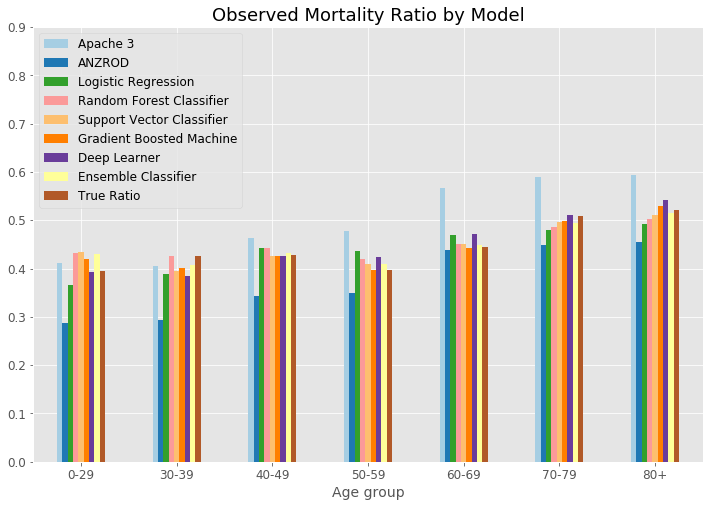

In [271]:
# Create graph
observed_mortality_by_agegroup_df.plot(kind='bar',
                                       ylim=(0,0.9),
                                       rot=0,
                                       title='Observed Mortality Ratio by Model',
                                       colormap='Paired')